# Decision program using machine learning methods
## DuckDB, basic features + DDB features

In [1]:
!pip install scikit-learn
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install tqdm
!pip install dhg

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
import dhg
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import pickle

#### Distribution of the runtimes in orders of magnitude

For the original queries:

In [3]:
df = pd.read_csv('results/DDB_Scala_comparison_TO_augment_server.csv')

df.loc[df['orig mean'] == 'TO', 'orig mean'] = 101
column = df['orig mean'].astype("float64")

count_0_01_orig = 0
count_0_1_orig = 0
count_1_orig = 0
count_10_orig = 0
count_100_orig = 0
count_TO_orig = 0

for value in column:
    if value <= 0.01:
        count_0_01_orig += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_orig += 1
    elif value > 0.1 and value <= 1:
        count_1_orig += 1
    elif value > 1 and value <= 10:
        count_10_orig += 1
    elif value > 10 and value <= 100:
        count_100_orig += 1
    else:
        count_TO_orig += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_orig)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_orig)
print("Number of instances with original runtime (0.1, 1]:", count_1_orig)
print("Number of instances with original runtime (1,10]:", count_10_orig)
print("Number of instances with original runtime (10,100]:", count_100_orig)
print("Number of instances with original runtime TO:", count_TO_orig)

Number of instances with original runtime <= 0.01: 7
Number of instances with original runtime (0.01, 0.1]: 101
Number of instances with original runtime (0.1, 1]: 1706
Number of instances with original runtime (1,10]: 638
Number of instances with original runtime (10,100]: 219
Number of instances with original runtime TO: 265


for the rewritten queries:

In [4]:
df.loc[df['rewr mean'] == 'TO', 'rewr mean'] = 101
column = df['rewr mean'].astype("float64")

count_0_01_rewr = 0
count_0_1_rewr = 0
count_1_rewr = 0
count_10_rewr = 0
count_100_rewr = 0
count_TO_rewr = 0

for value in column:
    if value <= 0.01:
        count_0_01_rewr += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_rewr += 1
    elif value > 0.1 and value <= 1:
        count_1_rewr += 1
    elif value > 1 and value <= 10:
        count_10_rewr += 1
    elif value > 10 and value <= 100:
        count_100_rewr += 1
    else:
        count_TO_rewr += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_rewr)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_rewr)
print("Number of instances with original runtime (0.1, 1]:", count_1_rewr)
print("Number of instances with original runtime (1,10]:", count_10_rewr)
print("Number of instances with original runtime (10,100]:", count_100_rewr)
print("Number of instances with original runtime TO:", count_TO_rewr)

Number of instances with original runtime <= 0.01: 0
Number of instances with original runtime (0.01, 0.1]: 103
Number of instances with original runtime (0.1, 1]: 1930
Number of instances with original runtime (1,10]: 560
Number of instances with original runtime (10,100]: 219
Number of instances with original runtime TO: 124


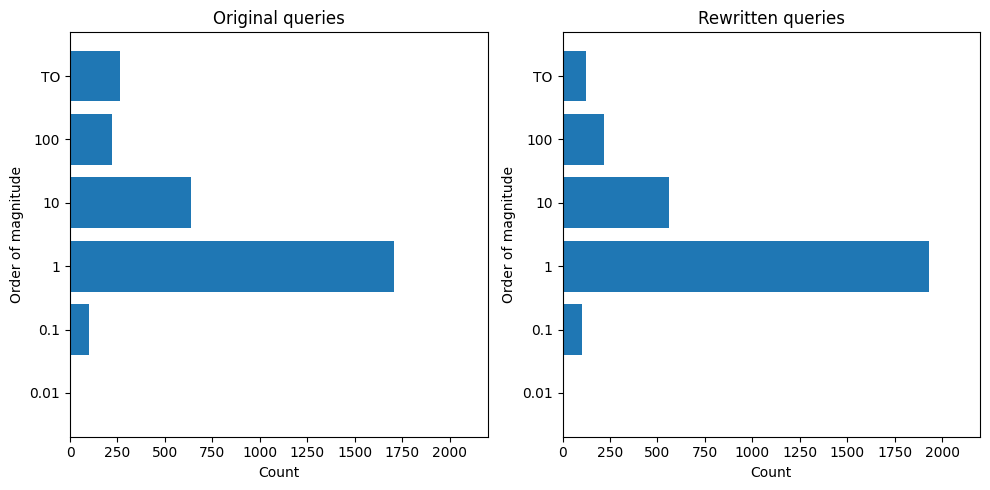

In [5]:
numbers_orig = [count_0_01_orig, count_0_1_orig, count_1_orig, count_10_orig, count_100_orig, count_TO_orig]
numbers_rewr = [count_0_01_rewr, count_0_1_rewr, count_1_rewr, count_10_rewr, count_100_rewr, count_TO_rewr]

# Indices for each number
indices = ["0.01", "0.1", "1", "10", "100", "TO"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original numbers
axs[0].barh(indices, numbers_orig)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Order of magnitude')
axs[0].set_title('Original queries')
axs[0].set_xlim(0, 2200)

# Plot rewritten numbers
axs[1].barh(indices, numbers_rewr)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Order of magnitude')
axs[1].set_title('Rewritten queries')
axs[1].set_xlim(0, 2200)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Import the data

In [6]:
file_path = 'results/features_times_DDB_extra.csv'
df = pd.read_csv(file_path)
df.head()

bench                query orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  \
0  STATS              001-014            rewr                 orig   0.152974   
1  STATS        001-014-augA1            rewr                 orig   0.164154   
2  STATS        001-014-augA2            orig                 orig   0.167567   
3  STATS        001-014-augF1            orig                 orig   0.155335   
4  STATS  001-014-augF1-augA1            rewr                 orig   0.165553   

   rewr mean  rewr mean+rewr  diff rewr-orig  diff rewr+rewr-orig  #relations  \
0   0.111106        2.036514       -0.041868             1.883540           3   
1   0.136223        1.933056       -0.027931             1.768902           3   
2   0.199151        2.017481        0.031583             1.849914           3   
3   0.199072        2.031366        0.043737             1.876031           3   
4   0.139130        1.994132       -0.026423             1.828579           3   

   ...  mean(branching factors)  median(branching factors)  \
0  ...                      2.0                        2.0   
1  ...                      1.0                        1.0   
2  ...                      1.0                        1.0   
3  ...                      2.0                        2.0   
4  ...                      1.0                        1.0   

   q25(branching factors)  q75(branching factors)  balancedness factor  \
0                     2.0                     2.0                  1.0   
1                     1.0                     1.0                  NaN   
2                     1.0                     1.0                  NaN   
3                     2.0                     2.0                  1.0   
4                     1.0                     1.0                  NaN   

                               list est. cardinality  \
0  [10087, 49680, 6935, 6831, 49680, 34675, 34675...   
1  [10087, 49680, 6935, 6831, 49680, 34675, 34675...   
2  [10087, 49680, 6935, 6831, 34675, 49680, 34675...   
3  [10087, 49680, 6935, 6831, 49680, 34675, 34675...   
4  [10087, 49680, 6935, 6831, 49680, 34675, 34675...   

                           container counts list  branching factors list  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                     [2]   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                  [1, 1]   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                  [1, 1]   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                     [2]   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                  [1, 1]   

                                          hypergraph  \
0  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
1  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
2  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
3  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
4  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   

                                                text  
0  SELECT MIN(u.Id) FROM comments as c, votes as ...  
1  SELECT MIN(c.id) FROM comments as c, votes as ...  
2  SELECT MIN(v.id) FROM comments as c, votes as ...  
3  SELECT MIN(u.Id) FROM comments as c, votes as ...  
4  SELECT MIN(c.id) FROM comments as c, votes as ...  

[5 rows x 38 columns]

In [7]:
df.dtypes

bench                         object
query                         object
orig/rewr(mean)               object
orig/rewr+rewr(mean)          object
orig mean                    float64
rewr mean                    float64
rewr mean+rewr               float64
diff rewr-orig               float64
diff rewr+rewr-orig          float64
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
min(est. cardinality)          int64
max(est. cardinality)          int64
mean(est. cardinality)       float64
q25(est. cardinality)        float64
median(est. cardinality)     float64
q75(est. cardinality)        float64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
min(branching factors)         int64
m

Transform the hypergraph, which is saved as pickle object, back to a dhg hypergraph object.

In [8]:
df["hypergraph"] = df["hypergraph"].apply(lambda x: pickle.loads(eval(x)))

#### Delete those examples, where both methods gave a timeout

In [9]:
df[df["orig/rewr(mean)"] == "-"]

bench                 query orig/rewr(mean) orig/rewr+rewr(mean)  \
2031  SNAP        patents-path08               -                    -   
2032  SNAP  patents-path08-augA1               -                    -   
2033  SNAP  patents-path08-augA2               -                    -   
2034  SNAP  patents-path08-augA3               -                    -   
2035  SNAP  patents-path08-augA4               -                    -   
...    ...                   ...             ...                  ...   
2115  SNAP     wiki-tree03-augA3               -                    -   
2116  SNAP     wiki-tree03-augA4               -                    -   
2117  SNAP     wiki-tree03-augA5               -                    -   
2118  SNAP     wiki-tree03-augA6               -                    -   
2119  SNAP     wiki-tree03-augA7               -                    -   

      orig mean  rewr mean  rewr mean+rewr  diff rewr-orig  \
2031      100.0      100.0           100.0             0.0   
2032      100.0      100.0           100.0             0.0   
2033      100.0      100.0           100.0             0.0   
2034      100.0      100.0           100.0             0.0   
2035      100.0      100.0           100.0             0.0   
...         ...        ...             ...             ...   
2115      100.0      100.0           100.0             0.0   
2116      100.0      100.0           100.0             0.0   
2117      100.0      100.0           100.0             0.0   
2118      100.0      100.0           100.0             0.0   
2119      100.0      100.0           100.0             0.0   

      diff rewr+rewr-orig  #relations  ...  mean(branching factors)  \
2031                  0.0           9  ...                 1.142857   
2032                  0.0           9  ...                 1.142857   
2033                  0.0           9  ...                 1.142857   
2034                  0.0           9  ...                 1.142857   
2035                  0.0           9  ...                 1.142857   
...                   ...         ...  ...                      ...   
2115                  0.0           8  ...                 1.750000   
2116                  0.0           8  ...                 1.750000   
2117                  0.0           8  ...                 1.750000   
2118                  0.0           8  ...                 1.750000   
2119                  0.0           8  ...                 1.750000   

      median(branching factors)  q25(branching factors)  \
2031                        1.0                    1.00   
2032                        1.0                    1.00   
2033                        1.0                    1.00   
2034                        1.0                    1.00   
2035                        1.0                    1.00   
...                         ...                     ...   
2115                        1.0                    1.00   
2116                        1.0                    1.00   
2117                        1.5                    1.00   
2118                        1.5                    1.00   
2119                        2.0                    1.75   

      q75(branching factors)  balancedness factor  \
2031                    1.00             1.000000   
2032                    1.00             1.000000   
2033                    1.00             1.000000   
2034                    1.00             1.000000   
2035                    1.00             1.000000   
...                      ...                  ...   
2115                    1.75             1.000000   
2116                    1.75             1.000000   
2117                    2.25             0.666667   
2118                    2.25             0.625000   
2119                    2.00             0.511111   

                                  list est. cardinality  \
2031  [15278736, 15278736, 15278736, 15278735, 15278...   
2032  [15278736, 15278736, 15278736, 15278735, 15278...   
2033  [

For the SNAP dataset the wiki-path06, wiki-path07, wiki-path08 and wiki-tree03 (for all augmentation cases) did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those 32 samples.

In [10]:
df = df[df["orig/rewr(mean)"] != "-"]
df.shape

(2861, 38)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [11]:
X = df.iloc[:, 9:32]
X.head()

#relations  #conditions  #filters  #joins  min(est. cardinality)  \
0           3            7         5       2                   6831   
1           3            7         5       2                   6831   
2           3            7         5       2                   6831   
3           3            7         5       2                   6831   
4           3            7         5       2                   6831   

   max(est. cardinality)  mean(est. cardinality)  q25(est. cardinality)  \
0                  49680                24924.25                 6909.0   
1                  49680                24924.25                 6909.0   
2                  49680                24924.25                 6909.0   
3                  49680                24924.25                 6909.0   
4                  49680                24924.25                 6909.0   

   median(est. cardinality)  q75(est. cardinality)  ...  \
0                   22381.0               38426.25  ...   
1                   22381.0               38426.25  ...   
2                   22381.0               38426.25  ...   
3                   22381.0               38426.25  ...   
4                   22381.0               38426.25  ...   

   mean(container counts)  q25(container counts)  median(container counts)  \
0                1.133333                    1.0                       1.0   
1                1.133333                    1.0                       1.0   
2                1.133333                    1.0                       1.0   
3                1.133333                    1.0                       1.0   
4                1.133333                    1.0                       1.0   

   q75(container counts)  min(branching factors)  max(branching factors)  \
0                    1.0                       2                       2   
1                    1.0                       1                       1   
2                    1.0                       1                       1   
3                    1.0                       2                       2   
4                    1.0                       1                       1   

   mean(branching factors)  median(branching factors)  q25(branching factors)  \
0                      2.0                        2.0                     2.0   
1                      1.0                        1.0                     1.0   
2                      1.0                        1.0                     1.0   
3                      2.0                        2.0                     2.0   
4                      1.0                        1.0                     1.0   

   q75(branching factors)  
0                     2.0  
1                     1.0  
2                     1.0  
3                     2.0  
4                     1.0  

[5 rows x 23 columns]

Get the feature matrix, which additionally includes the hypergraph information/representation.

In [12]:
X_hg = pd.concat([X, df.iloc[:,36]], axis = 1)
X_hg.head()

#relations  #conditions  #filters  #joins  min(est. cardinality)  \
0           3            7         5       2                   6831   
1           3            7         5       2                   6831   
2           3            7         5       2                   6831   
3           3            7         5       2                   6831   
4           3            7         5       2                   6831   

   max(est. cardinality)  mean(est. cardinality)  q25(est. cardinality)  \
0                  49680                24924.25                 6909.0   
1                  49680                24924.25                 6909.0   
2                  49680                24924.25                 6909.0   
3                  49680                24924.25                 6909.0   
4                  49680                24924.25                 6909.0   

   median(est. cardinality)  q75(est. cardinality)  ...  \
0                   22381.0               38426.25  ...   
1                   22381.0               38426.25  ...   
2                   22381.0               38426.25  ...   
3                   22381.0               38426.25  ...   
4                   22381.0               38426.25  ...   

   q25(container counts)  median(container counts)  q75(container counts)  \
0                    1.0                       1.0                    1.0   
1                    1.0                       1.0                    1.0   
2                    1.0                       1.0                    1.0   
3                    1.0                       1.0                    1.0   
4                    1.0                       1.0                    1.0   

   min(branching factors)  max(branching factors)  mean(branching factors)  \
0                       2                       2                      2.0   
1                       1                       1                      1.0   
2                       1                       1                      1.0   
3                       2                       2                      2.0   
4                       1                       1                      1.0   

   median(branching factors)  q25(branching factors)  q75(branching factors)  \
0                        2.0                     2.0                     2.0   
1                        1.0                     1.0                     1.0   
2                        1.0                     1.0                     1.0   
3                        2.0                     2.0                     2.0   
4                        1.0                     1.0                     1.0   

                      hypergraph  
0  Hypergraph(num_v=17, num_e=3)  
1  Hypergraph(num_v=17, num_e=3)  
2  Hypergraph(num_v=17, num_e=3)  
3  Hypergraph(num_v=17, num_e=3)  
4  Hypergraph(num_v=17, num_e=3)  

[5 rows x 24 columns]

#### Log-transformations

In [13]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min           Max          Diff
#relations                 2.000000  1.100000e+01  9.000000e+00
#conditions                2.000000  2.000000e+01  1.800000e+01
#filters                   0.000000  1.600000e+01  1.600000e+01
#joins                     1.000000  1.200000e+01  1.100000e+01
min(est. cardinality)      0.000000  1.527874e+07  1.527874e+07
max(est. cardinality)      1.000000  3.258152e+10  3.258152e+10
mean(est. cardinality)     0.428571  1.923702e+09  1.923702e+09
q25(est. cardinality)      0.000000  1.527874e+07  1.527874e+07
median(est. cardinality)   0.000000  1.527874e+07  1.527874e+07
q75(est. cardinality)      1.000000  1.527874e+07  1.527874e+07
depth                      1.000000  7.000000e+00  6.000000e+00
min(container counts)      1.000000  1.000000e+00  0.000000e+00
max(container counts)      2.000000  5.000000e+00  3.000000e+00
mean(container counts)     1.047619  1.600000e+00  5.523810e-01
q25(container counts)      1.000000  1.000000e+00  0.000000e+00
median(container counts)   1.000000  1.000000e+00  0.000000e+00
q75(container counts)      1.000000  1.000000e+00  0.000000e+00
min(branching factors)     1.000000  6.000000e+00  5.000000e+00
max(branching factors)     1.000000  6.000000e+00  5.000000e+00
mean(branching factors)    1.000000  6.000000e+00  5.000000e+00
median(branching factors)  1.000000  6.000000e+00  5.000000e+00
q25(branching factors)     1.000000  6.000000e+00  5.000000e+00
q75(branching factors)     1.000000  6.000000e+00  5.000000e+00

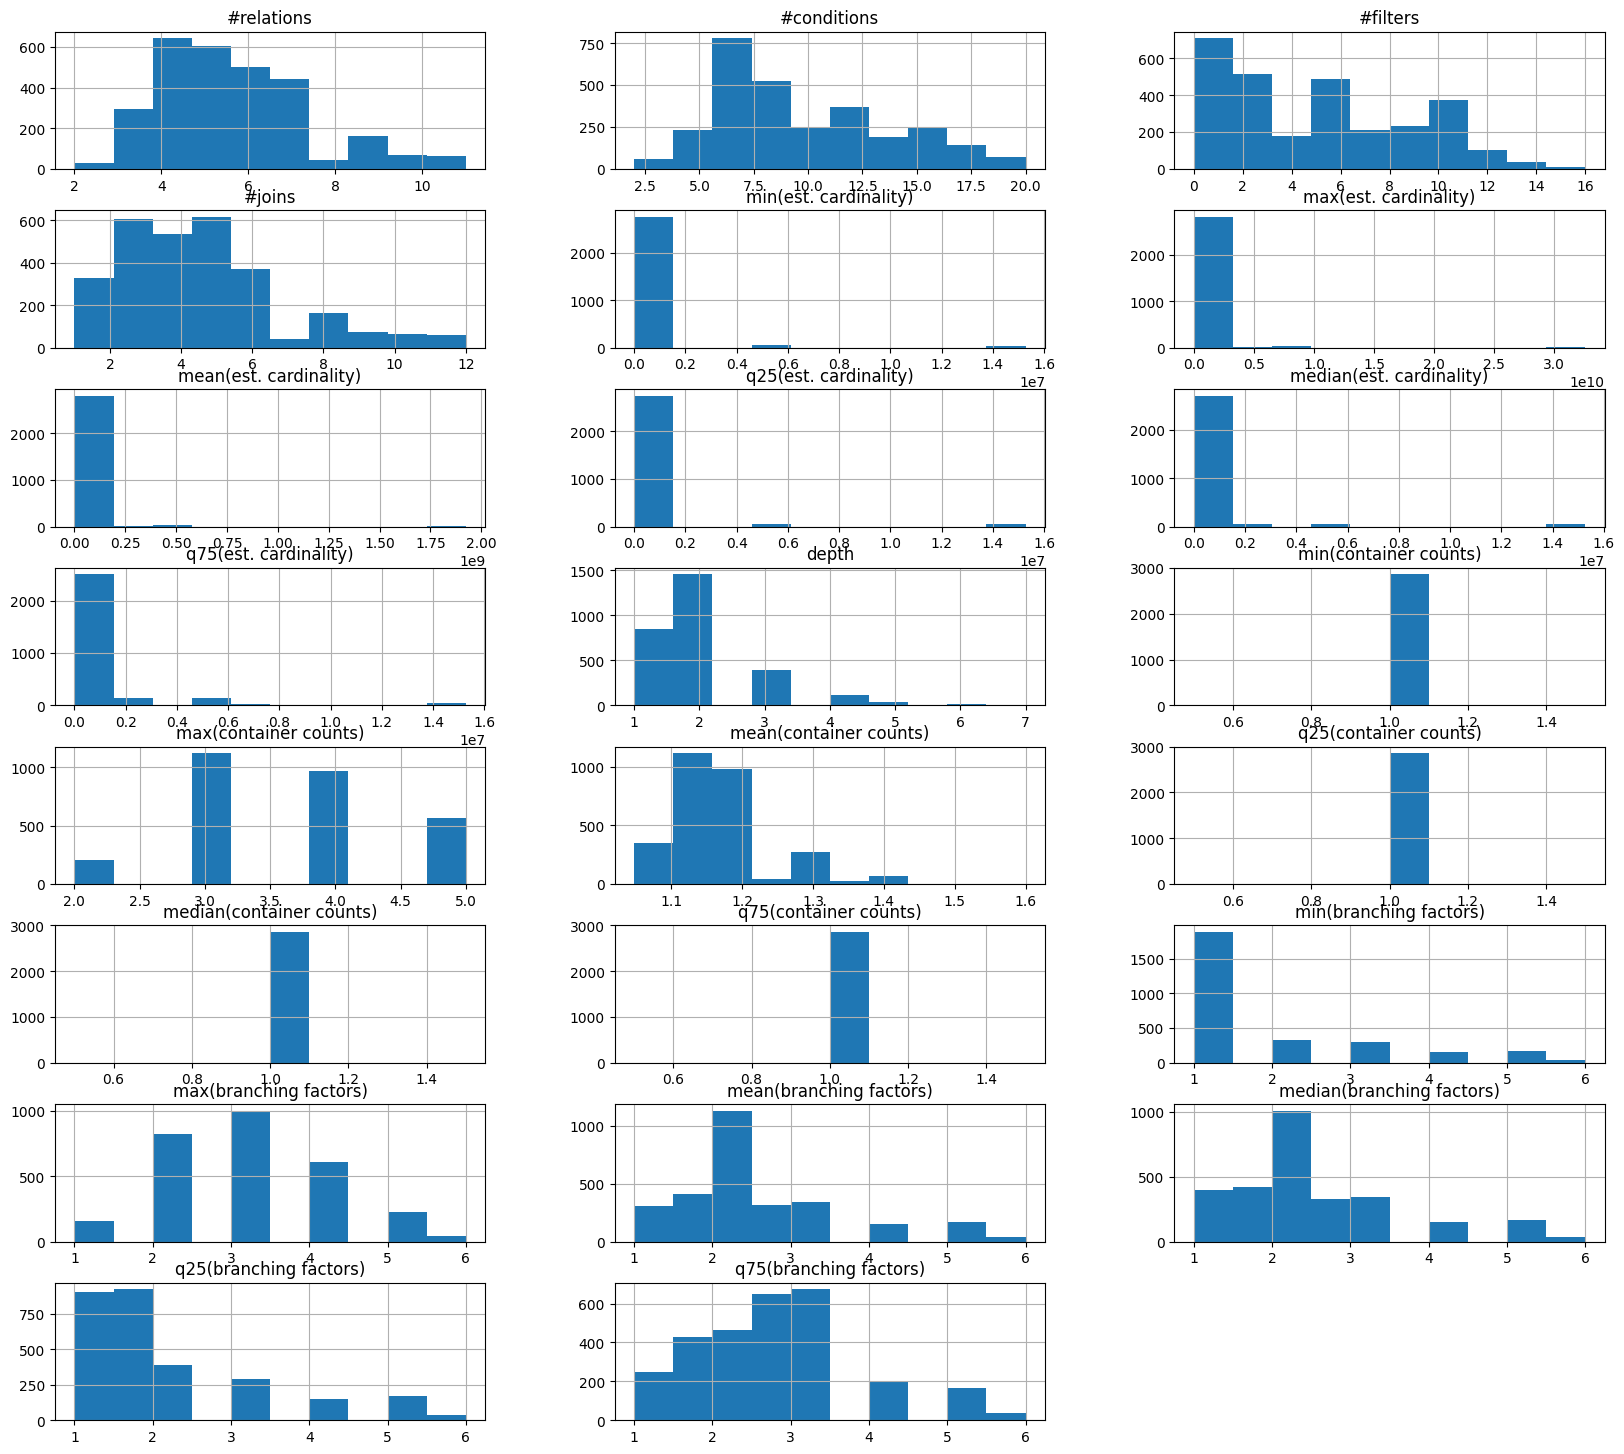

In [14]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

We transform all cardinality variables.

In [15]:
columns_to_log = ['min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)']
X[columns_to_log] = X[columns_to_log].apply(np.log)

Four rows have 0 as minimum cardinality, this leads to -inf when log transforming. We just delete those 4 rows.

In [16]:
X[X["max(est. cardinality)"] == 0]

#relations  #conditions  #filters  #joins  min(est. cardinality)  \
2394           4            3         0       3                   -inf   
2395           4            3         0       3                   -inf   
2396           4            3         0       3                   -inf   
2397           4            3         0       3                   -inf   

      max(est. cardinality)  mean(est. cardinality)  q25(est. cardinality)  \
2394                    0.0               -0.847298                   -inf   
2395                    0.0               -0.847298                   -inf   
2396                    0.0               -0.847298                   -inf   
2397                    0.0               -0.847298                   -inf   

      median(est. cardinality)  q75(est. cardinality)  ...  \
2394                      -inf                    0.0  ...   
2395                      -inf                    0.0  ...   
2396                      -inf                    0.0  ...   
2397                      -inf                    0.0  ...   

      mean(container counts)  q25(container counts)  median(container counts)  \
2394                     1.6                    1.0                       1.0   
2395                     1.6                    1.0                       1.0   
2396                     1.6                    1.0                       1.0   
2397                     1.6                    1.0                       1.0   

      q75(container counts)  min(branching factors)  max(branching factors)  \
2394                    1.0                       3                       3   
2395                    1.0                       3                       3   
2396                    1.0                       1                       2   
2397                    1.0                       1                       2   

      mean(branching factors)  median(branching factors)  \
2394                      3.0                        3.0   
2395                      3.0                        3.0   
2396                      1.5                        1.5   
2397                      1.5                        1.5   

      q25(branching factors)  q75(branching factors)  
2394                    3.00                    3.00  
2395                    3.00                    3.00  
2396                    1.25                    1.75  
2397                    1.25                    1.75  

[4 rows x 23 columns]

In [17]:
df = df[X["max(est. cardinality)"] != 0]
X = X[X["max(est. cardinality)"] != 0]

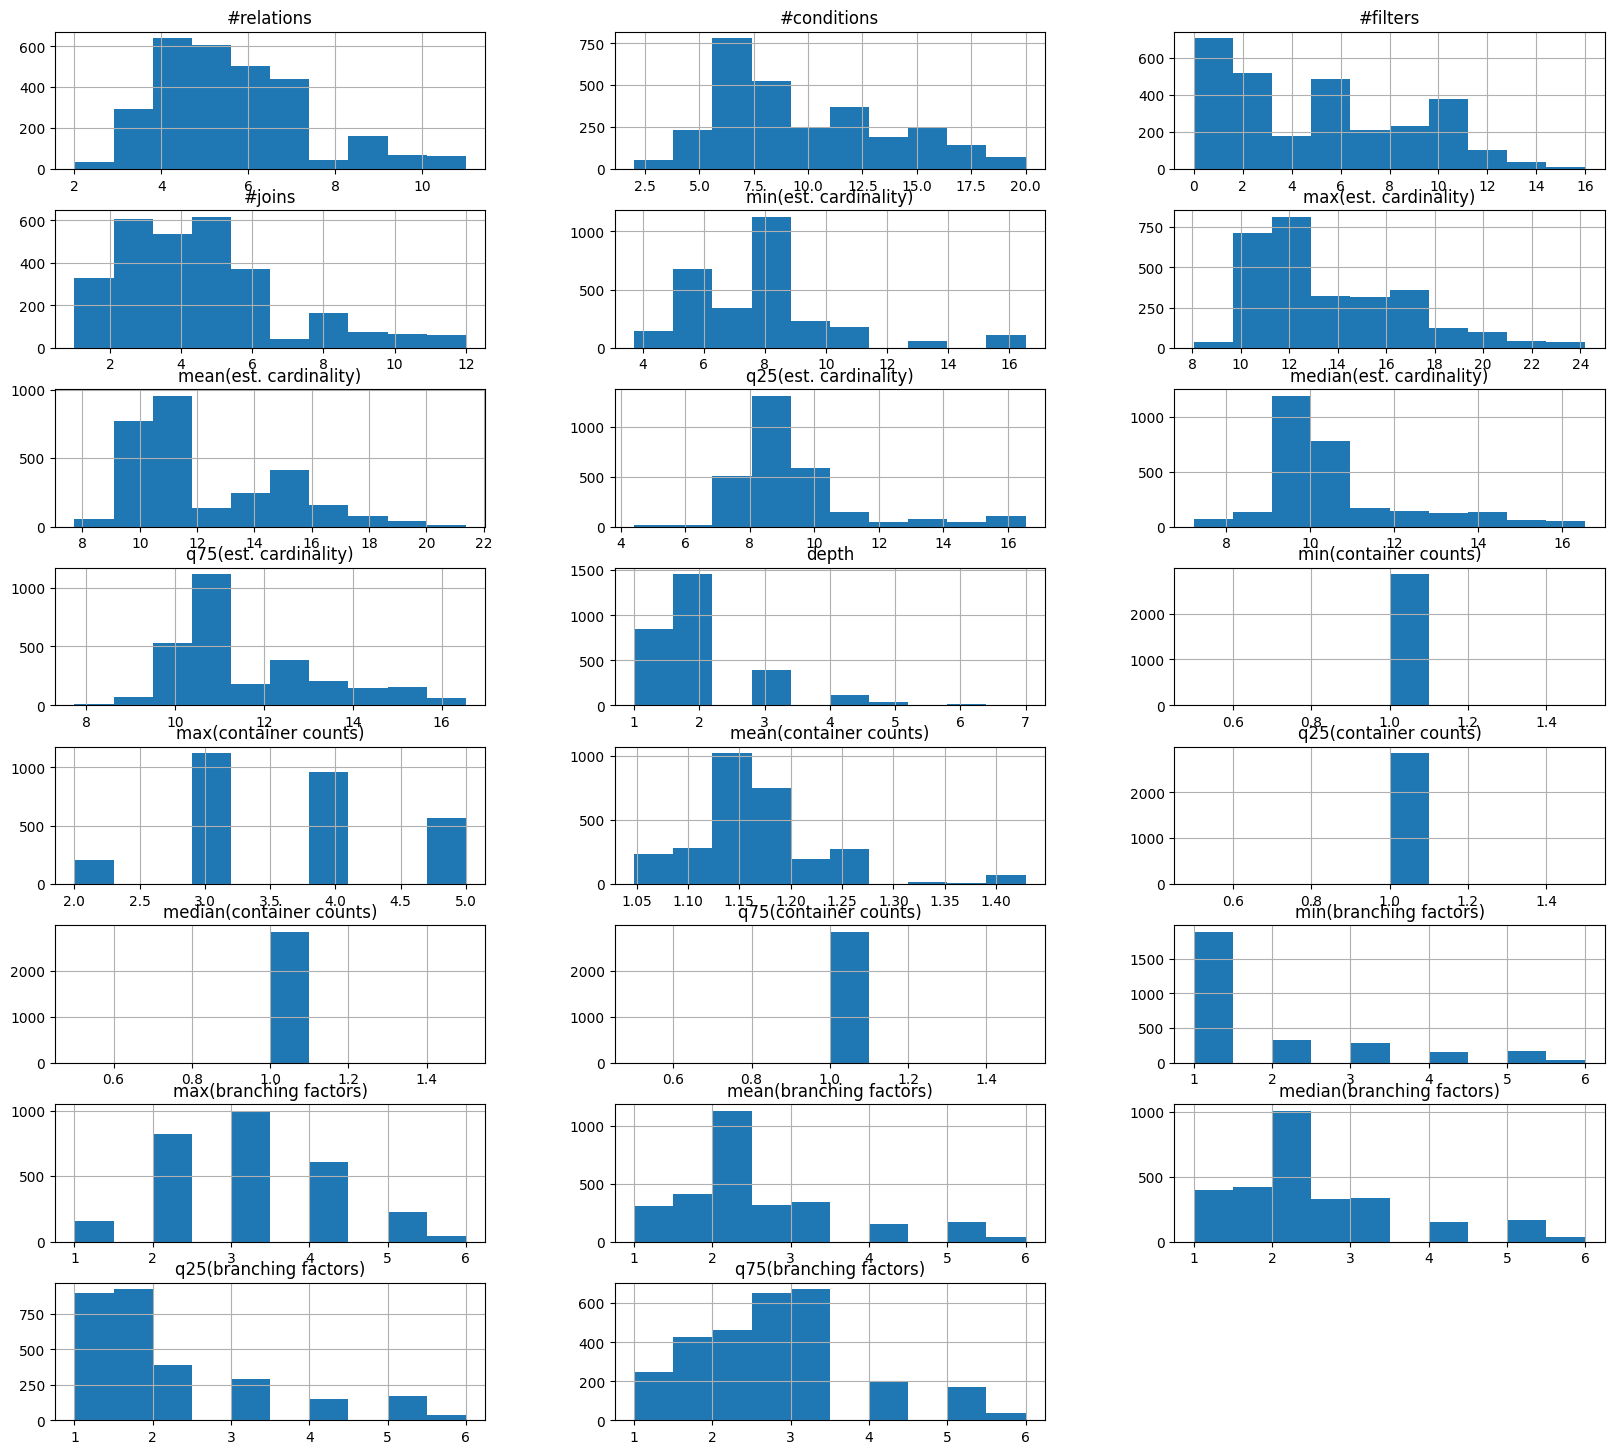

In [18]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Boxplots of running times for both cases (either original or rewritten)

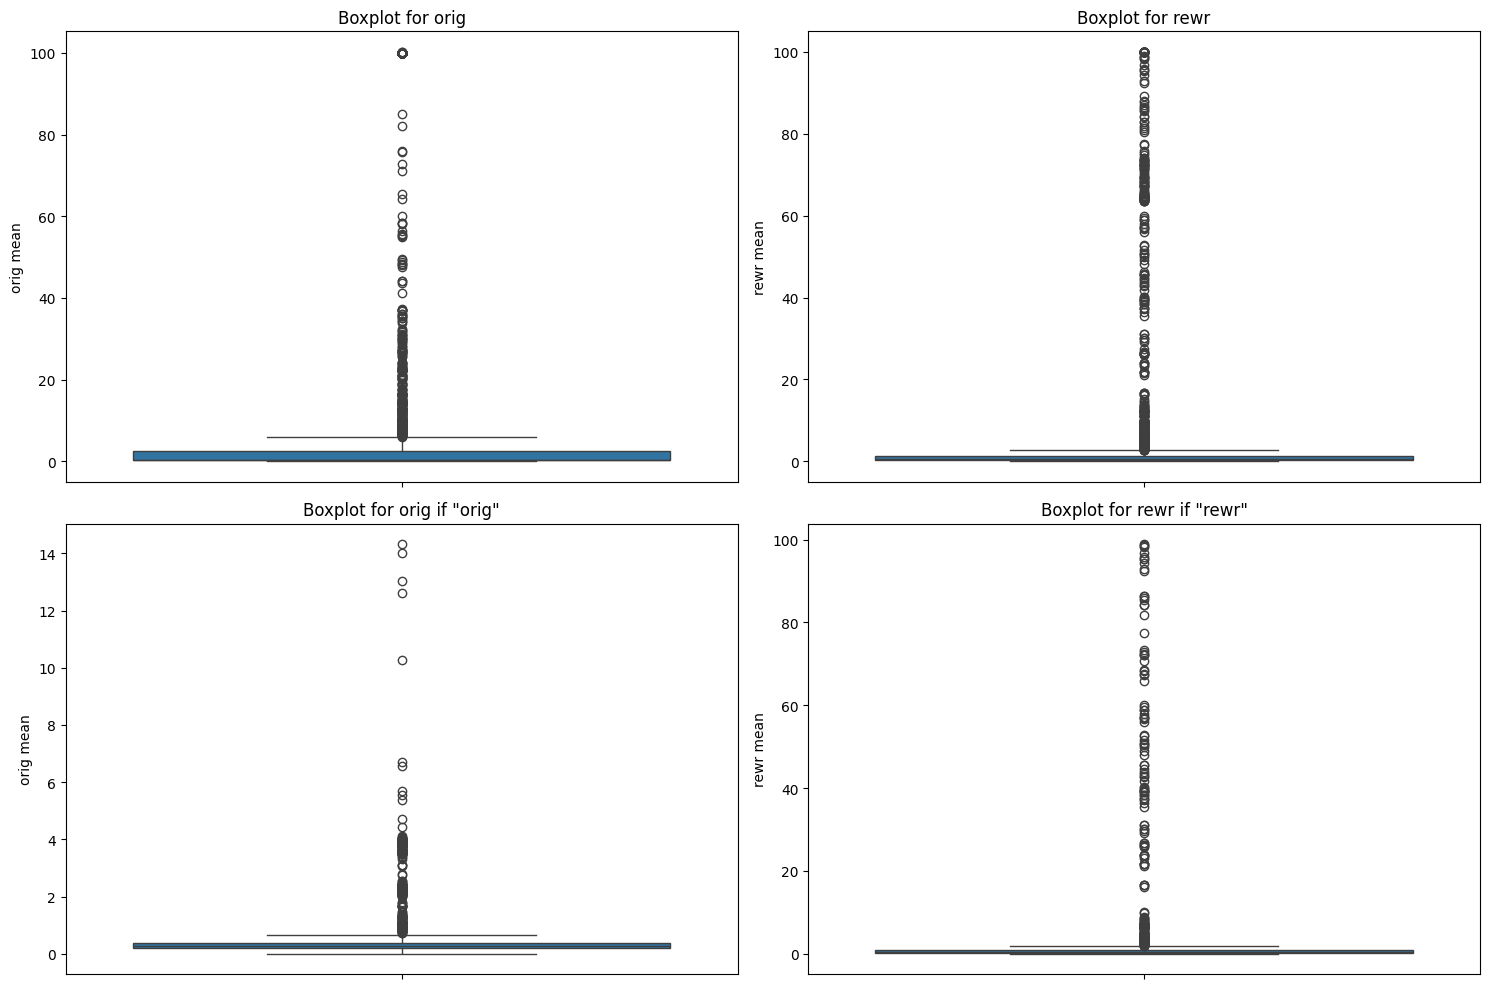

In [19]:
df_orig = df[df['orig/rewr(mean)'] == 'orig']
df_rewr = df[df['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')

sns.boxplot(y='rewr mean', data=df, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr')

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr if "rewr"')

plt.tight_layout()
plt.show()

The runtimes are highly skewed. Therefore, we log transform them

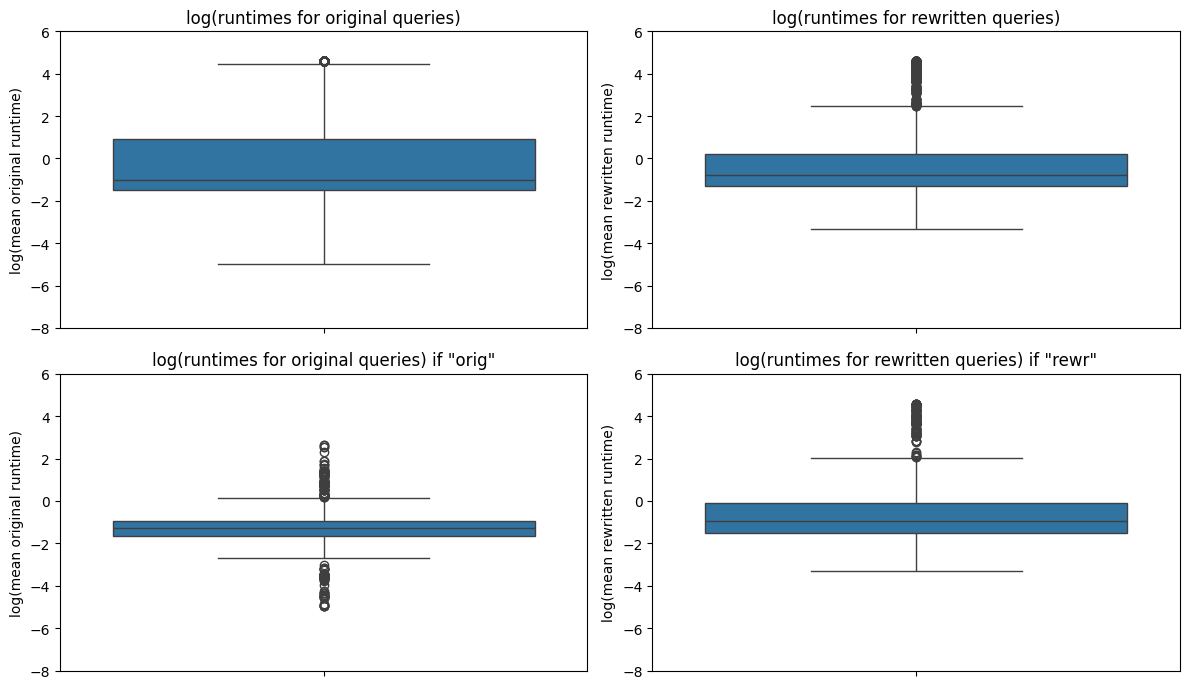

In [20]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(12,7))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0,0])
axes[0,0].set_title(f'log(runtimes for original queries)')
axes[0,0].set_ylabel("log(mean original runtime)")
axes[0,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[0,1])
axes[0,1].set_title(f'log(runtimes for rewritten queries)')
axes[0,1].set_ylabel("log(mean rewritten runtime)")
axes[0,1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'log(runtimes for original queries) if "orig"')
axes[1,0].set_ylabel("log(mean original runtime)")
axes[1,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[1,1].set_ylabel("log(mean rewritten runtime)")
axes[1,1].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

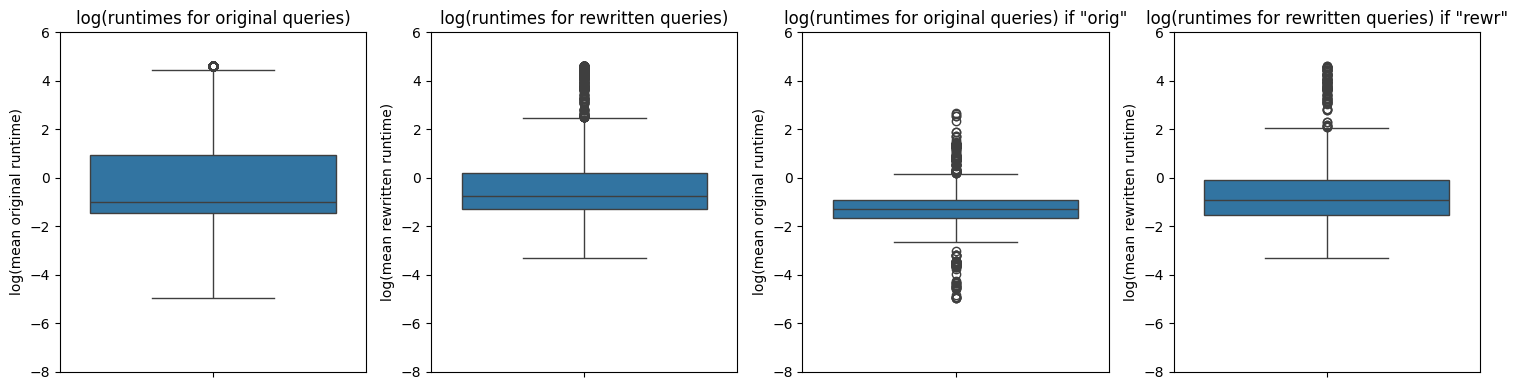

In [21]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(1,4, figsize=(15,4))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0])
axes[0].set_title(f'log(runtimes for original queries)')
axes[0].set_ylabel("log(mean original runtime)")
axes[0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[1])
axes[1].set_title(f'log(runtimes for rewritten queries)')
axes[1].set_ylabel("log(mean rewritten runtime)")
axes[1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[2])
axes[2].set_title(f'log(runtimes for original queries) if "orig"')
axes[2].set_ylabel("log(mean original runtime)")
axes[2].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[3])
axes[3].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[3].set_ylabel("log(mean rewritten runtime)")
axes[3].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

#### Scatterplot of running times

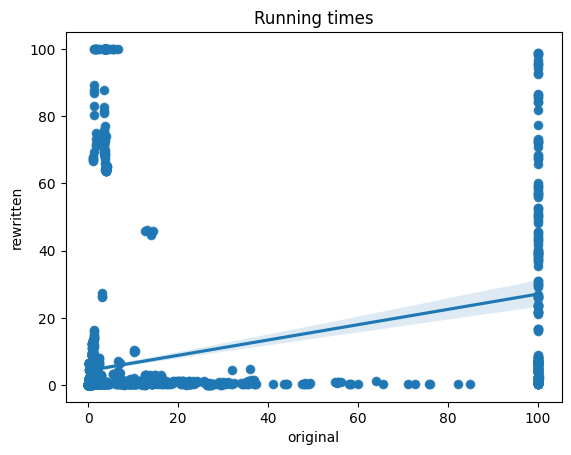

In [22]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df)
sns.regplot(x="orig mean", y="rewr mean", data=df) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

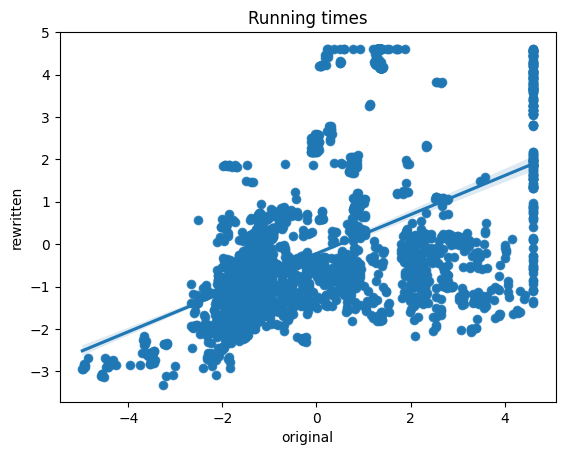

In [23]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df_log)
sns.regplot(x="orig mean", y="rewr mean", data=df_log) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [24]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(mean)'].map(mapping)
y1.head()

0    1
1    1
2    0
3    0
4    1
Name: orig/rewr(mean), dtype: int64

The number of appearances of original and rewritten is very balanced.

In [25]:
y1.value_counts()

orig/rewr(mean)
0    1539
1    1318
Name: count, dtype: int64

In [26]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["orig", "rewr", "equal"]
count

orig     1318
rewr     1539
equal       -
dtype: object

In [27]:
df["orig/rewr(mean)"].value_counts()

orig/rewr(mean)
orig    1539
rewr    1318
Name: count, dtype: int64

#### Classification response with three cases

In [28]:
condition = abs(df["diff rewr-orig"]) < 0.5
df["orig/rewr/equal 0.5"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.5'] = 'equal'

In [29]:
condition = abs(df["diff rewr-orig"]) < 0.1
df["orig/rewr/equal 0.1"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.1'] = 'equal'

In [30]:
condition = abs(df["diff rewr-orig"]) < 0.05
df["orig/rewr/equal 0.05"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.05'] = 'equal'

In [31]:
condition = abs(df["diff rewr-orig"]) < 0.01
df["orig/rewr/equal 0.01"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.01'] = 'equal'

In [32]:
count_05 = df["orig/rewr/equal 0.5"].value_counts()
count_01 = df["orig/rewr/equal 0.1"].value_counts()
count_005 = df["orig/rewr/equal 0.05"].value_counts()
count_001 = df["orig/rewr/equal 0.01"].value_counts()

In [33]:
count_001

orig/rewr/equal 0.01
orig     1500
rewr     1275
equal      82
Name: count, dtype: int64

In [34]:
counts = pd.concat([count_001, count_005, count_01, count_05], axis = 1)
counts.iloc[[0, 1]] = counts.iloc[[1, 0]].values
counts.index = ["orig", "rewr", "equal"]
counts = pd.concat([count, counts], axis = 1)
counts.columns = ["2 classes", "3 classes (0.01)", "3 classes (0.05)", "3 classes (0.1)", "3 classes (0.5)"]
counts

2 classes  3 classes (0.01)  3 classes (0.05)  3 classes (0.1)  \
orig       1318              1275              1112             1008   
rewr       1539              1500              1289             1097   
equal         -                82               456              752   

       3 classes (0.5)  
orig               796  
rewr               547  
equal             1514

In [35]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_05 = df['orig/rewr/equal 0.5'].map(mapping1)
y1_equal_05.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr/equal 0.5, dtype: int64

In [36]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_01 = df['orig/rewr/equal 0.1'].map(mapping1)
y1_equal_01.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr/equal 0.1, dtype: int64

In [37]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_005 = df['orig/rewr/equal 0.05'].map(mapping1)
y1_equal_005.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr/equal 0.05, dtype: int64

In [38]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_001 = df['orig/rewr/equal 0.01'].map(mapping1)
y1_equal_001.head()

0    1
1    1
2   -1
3   -1
4    1
Name: orig/rewr/equal 0.01, dtype: int64

#### Regression response

We also have the time differences between the original and rewritten method and we want to use that as numerical response.

In [39]:
y1_diff = df["diff rewr-orig"]
#y1_diff = df["diff rewr+rewr-orig"]

We can see that the time difference has a wide range of values (or is skewed).

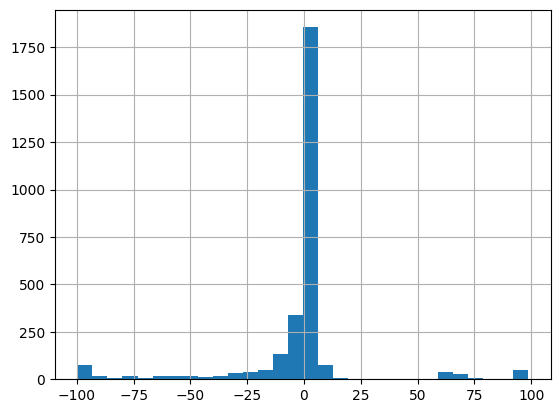

In [40]:
y1_diff.hist(bins = 30)
plt.show()

Therefore, we are going to transform it. As before with the features, we would like to apply a log transformation. Neverthless, since we have negative values this cannot be applied directly. We are going to multiple to log of the absolute values with the sign they had before. Additionally, since we have a lot of values close to zero, which leads to very low log values, we add 1 to the absolute values, which is a common method.   
$x = sgn(x) * log(|x| + 1)$

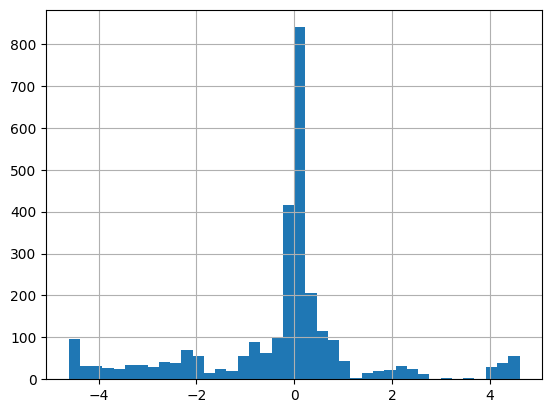

In [41]:
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) +1)
y1_diff_log.hist(bins = 40)
plt.show()

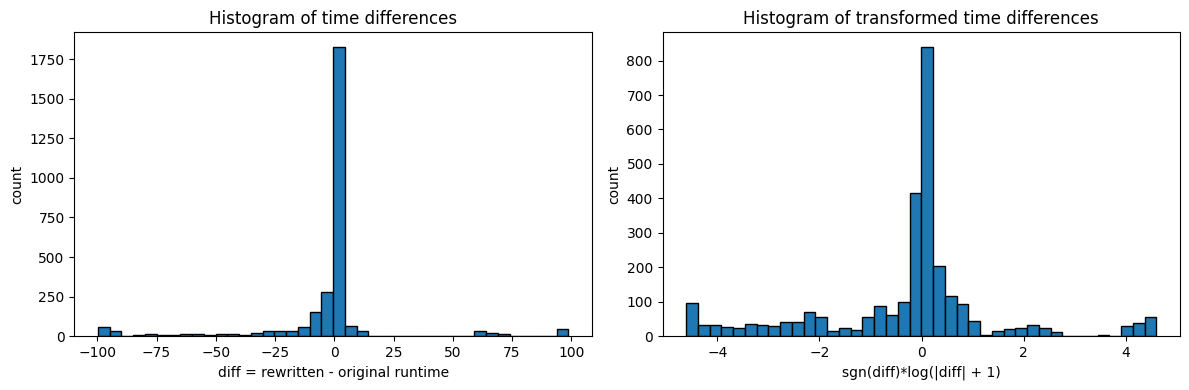

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(y1_diff, bins=40, edgecolor='black')
axs[0].set_title('Histogram of time differences')
axs[0].set_ylabel("count")
axs[0].set_xlabel("diff = rewritten - original runtime")

# Create the second histogram
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) + 1)
axs[1].hist(y1_diff_log, bins=40, edgecolor='black')
axs[1].set_title('Histogram of transformed time differences')
axs[1].set_ylabel("count")
axs[1].set_xlabel("sgn(diff)*log(|diff| + 1)")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [43]:
X.shape

(2857, 23)

In [44]:
y1.shape

(2857,)

In [45]:
df["bench"].shape

(2857,)

In [46]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)
X_train_hg = X_hg.loc[X_train.index]
X_val_hg = X_hg.loc[X_val.index]
X_test_hg = X_hg.loc[X_test.index]
y1_diff_log_train = y1_diff_log.loc[y1_train.index]
y1_diff_log_val = y1_diff_log.loc[y1_val.index]
y1_diff_log_test = y1_diff_log.loc[y1_test.index]
y1_equal_05_train = y1_equal_05.loc[y1_train.index]
y1_equal_05_val = y1_equal_05.loc[y1_val.index]
y1_equal_05_test = y1_equal_05.loc[y1_test.index]
y1_equal_01_train = y1_equal_01.loc[y1_train.index]
y1_equal_01_val = y1_equal_01.loc[y1_val.index]
y1_equal_01_test = y1_equal_01.loc[y1_test.index]
y1_equal_005_train = y1_equal_005.loc[y1_train.index]
y1_equal_005_val = y1_equal_005.loc[y1_val.index]
y1_equal_005_test = y1_equal_005.loc[y1_test.index]
y1_equal_001_train = y1_equal_001.loc[y1_train.index]
y1_equal_001_val = y1_equal_001.loc[y1_val.index]
y1_equal_001_test = y1_equal_001.loc[y1_test.index]

#### Cross-validation split

We take the same 10% as test set and use the rest for cross-validation.

In [47]:
X_train_cv = pd.concat([X_train, X_val], axis = 0)
y1_train_cv = pd.concat([y1_train, y1_val], axis = 0)
y1_diff_log_train_cv = pd.concat([y1_diff_log_train, y1_diff_log_val], axis = 0)
y1_equal_05_train_cv = pd.concat([y1_equal_05_train, y1_equal_05_val], axis = 0)
y1_equal_01_train_cv = pd.concat([y1_equal_01_train, y1_equal_01_val], axis = 0)
y1_equal_005_train_cv = pd.concat([y1_equal_005_train, y1_equal_005_val], axis = 0)
y1_equal_001_train_cv = pd.concat([y1_equal_001_train, y1_equal_001_val], axis = 0)

## ML models

In [48]:
table_2_classes = pd.DataFrame(columns=['acc', 'rec', 'acc', 'rec'])
table_3_classes = pd.DataFrame(columns=['acc', 'rec-mic', 'rec_mac', 'acc', 'rec-mic', 'rec-mac'])
table_time_diff = pd.DataFrame(columns=['MSE', 'MAE', 'R2', 'MSE', 'MAE', 'R2'])

### k-Nearest Neighbors with two classes

Train-test split:

In [49]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_train)
y1_pred_knn = clf.predict(X_val)

In [50]:
accuracy = accuracy_score(y1_val, y1_pred_knn)
recall = recall_score(y1_val, y1_pred_knn)
conf_matrix = confusion_matrix(y1_val, y1_pred_knn)
conf_matrix

array([[135,  19],
       [ 21, 111]])

CV:

In [51]:
y1_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [52]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_knn_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv

array([[1174,  212],
       [ 172, 1013]])

Adding the values to the result table:

In [53]:
table_2_classes.loc["5-NN"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN  0.86014  0.840909  0.850642  0.854852

### k-Nearest Neighbors with three classes

##### equal cut off: 0.5

Train-test split:

In [54]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_knn = clf.predict(X_val)

In [55]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_knn)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_knn)
conf_matrix

array([[ 46,   8,   3],
       [  5, 143,   8],
       [  0,  11,  62]])

CV:

In [56]:
y1_equal_05_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [57]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
conf_matrix_cv

array([[ 365,   98,   28],
       [  40, 1227,   92],
       [   8,   98,  615]])

Adding the values to the result table:

In [58]:
table_3_classes.loc["5-NN 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5  0.877622  0.877622  0.857666  0.858421  0.858421  0.833078

##### equal cut off: 0.1

Train-test split:

In [59]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_knn = clf.predict(X_val)

In [60]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_knn)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_knn)
conf_matrix

array([[89, 12, 11],
       [23, 47,  7],
       [ 7,  9, 81]])

CV:

In [61]:
y1_equal_01_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [62]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
conf_matrix_cv

array([[796, 106,  90],
       [167, 422,  78],
       [ 67,  70, 775]])

Adding the values to the result table:

In [63]:
table_3_classes.loc["5-NN 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5  0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1  0.758741  0.758741  0.746695  0.775185  0.775185  0.761628

##### equal cut off: 0.05

Train-test split:

In [64]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_knn = clf.predict(X_val)

In [65]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_knn)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_knn)
conf_matrix

array([[114,  10,  13],
       [ 15,  20,   6],
       [ 10,   8,  90]])

CV:

In [66]:
y1_equal_005_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [67]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
conf_matrix_cv

array([[980,  70, 118],
       [125, 227,  47],
       [ 94,  60, 850]])

Adding the values to the result table:

In [68]:
table_3_classes.loc["5-NN 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5   0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1   0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05  0.783217  0.783217  0.717752  0.800078  0.800078  0.751526

##### equal cut off: 0.01

Train-test split:

In [69]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_knn = clf.predict(X_val)

In [70]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_knn)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_knn)
conf_matrix

array([[134,   0,  18],
       [  3,   0,   2],
       [ 21,   0, 108]])

CV:

In [71]:
y1_equal_001_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [72]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
conf_matrix_cv

array([[1163,   10,  178],
       [  44,    2,   28],
       [ 161,    8,  977]])

Adding the values to the result table:

In [73]:
table_3_classes.loc["5-NN 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5   0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1   0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05  0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01  0.846154  0.846154  0.572929  0.833139  0.833139  0.580134

### k-Nearest Neighbors with time difference

Train-test split:

In [74]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y1_diff_log_train)
y1_pred_knn = model.predict(X_val)

In [75]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_knn)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_knn)
r2 = r2_score(y1_diff_log_val, y1_pred_knn)

CV:

In [76]:
y1_pred_knn_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [77]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_knn_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_knn_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_knn_cv)

Adding the values to the result table:

In [78]:
table_time_diff.loc["5-NN"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN  0.307589  0.287429  0.903824  0.345085  0.300073  0.892679

### Decision tree with two classes

Train-test split:

In [79]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [80]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
recall = recall_score(y1_val, y1_pred_dec_tree)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

array([[142,  12],
       [ 25, 107]])

CV:

In [81]:
y1_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [82]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_dec_tree_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv

array([[1228,  158],
       [ 187,  998]])

Adding the values to the result table:

In [83]:
table_2_classes.loc["Decision tree"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.860140  0.840909  0.850642  0.854852
Decision tree  0.870629  0.810606  0.865811  0.842194

### Decision tree with three classes

##### equal cut off: 0.5

Train-test split:

In [84]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_dec_tree = clf.predict(X_val)

In [85]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_dec_tree)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_dec_tree)
conf_matrix

array([[ 49,   7,   1],
       [  6, 140,  10],
       [  1,   3,  69]])

CV:

In [86]:
y1_equal_05_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [87]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
conf_matrix_cv

array([[ 385,   92,   14],
       [  54, 1224,   81],
       [  13,   69,  639]])

Adding the values to the result table:

In [88]:
table_3_classes.loc["Decision tree 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5           0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1           0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05          0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01          0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5  0.902098  0.902098  0.900763  0.874368  0.874368  0.857015

##### equal cut off: 0.1

Train-test split:

In [89]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_dec_tree = clf.predict(X_val)

In [90]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_dec_tree)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_dec_tree)
conf_matrix

array([[94, 16,  2],
       [26, 44,  7],
       [ 5,  9, 83]])

CV:

In [91]:
y1_equal_01_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [92]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
conf_matrix_cv

array([[837, 100,  55],
       [184, 416,  67],
       [ 59,  59, 794]])

Adding the values to the result table:

In [93]:
table_3_classes.loc["Decision tree 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5           0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1           0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05          0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01          0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5  0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1  0.772727  0.772727  0.755461  0.796188  0.796188  0.779351

##### equal cut off: 0.05

Train-test split:

In [94]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [95]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

array([[123,   9,   5],
       [ 15,  20,   6],
       [ 10,   8,  90]])

CV:

In [96]:
y1_equal_005_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [97]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
conf_matrix_cv

array([[1027,   56,   85],
       [ 131,  215,   53],
       [  92,   47,  865]])

Adding the values to the result table:

In [98]:
table_3_classes.loc["Decision tree 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894

##### equal cut off: 0.01

Train-test split:

In [99]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [100]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

array([[142,   0,  10],
       [  3,   0,   2],
       [ 21,   1, 107]])

CV:

In [101]:
y1_equal_001_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [102]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
conf_matrix_cv

array([[1205,    7,  139],
       [  41,    4,   29],
       [ 156,   10,  980]])

Adding the values to the result table:

In [103]:
table_3_classes.loc["Decision tree 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378

### Decision tree with time difference

Train-test split:

In [104]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [105]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_dec_tree)
r2 = r2_score(y1_diff_log_val, y1_pred_dec_tree)

CV:

In [106]:
y1_pred_dec_tree_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [107]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_dec_tree_cv)

Adding the values to the result table:

In [108]:
table_time_diff.loc["Decision tree"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.307589  0.287429  0.903824  0.345085  0.300073  0.892679
Decision tree  0.208562  0.238397  0.934787  0.241401  0.252629  0.924925

### Random forest with two classes

Train-test split:

In [109]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_val)

In [110]:
accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
recall = recall_score(y1_val, y1_pred_rand_forest)
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

array([[140,  14],
       [ 21, 111]])

CV:

In [111]:
y1_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [112]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_rand_forest_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv

array([[1197,  189],
       [ 155, 1030]])

Adding the values to the result table:

In [113]:
table_2_classes.loc["Random forest"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.860140  0.840909  0.850642  0.854852
Decision tree  0.870629  0.810606  0.865811  0.842194
Random forest  0.877622  0.840909  0.866200  0.869198

### Random forest with three classes

##### equal cut off: 0.5

Train-test split:

In [114]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_rand_forest = clf.predict(X_val)

In [115]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_rand_forest)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_rand_forest)
conf_matrix

array([[ 48,   8,   1],
       [  4, 140,  12],
       [  1,   3,  69]])

CV:

In [116]:
y1_equal_05_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [117]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
conf_matrix_cv

array([[ 375,   97,   19],
       [  39, 1230,   90],
       [   5,   64,  652]])

Adding the values to the result table:

In [118]:
table_3_classes.loc["Random forest 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708

##### equal cut off: 0.1

Train-test split:

In [119]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_rand_forest = clf.predict(X_val)

In [120]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_rand_forest)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_rand_forest)
conf_matrix

array([[93, 17,  2],
       [25, 44,  8],
       [ 5,  8, 84]])

CV:

In [121]:
y1_equal_01_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [122]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
conf_matrix_cv

array([[813, 112,  67],
       [170, 428,  69],
       [ 42,  59, 811]])

Adding the values to the result table:

In [123]:
table_3_classes.loc["Random forest 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497

##### equal cut off: 0.05

Train-test split:

In [124]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_rand_forest = clf.predict(X_val)

In [125]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_rand_forest)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_rand_forest)
conf_matrix

array([[119,  12,   6],
       [ 14,  20,   7],
       [ 10,   6,  92]])

CV:

In [126]:
y1_equal_005_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [127]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
conf_matrix_cv

array([[995,  74,  99],
       [120, 220,  59],
       [ 72,  47, 885]])

Adding the values to the result table:

In [128]:
table_3_classes.loc["Random forest 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579

##### equal cut off: 0.01

Train-test split:

In [129]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_rand_forest = clf.predict(X_val)

In [130]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_rand_forest)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_rand_forest)
conf_matrix

array([[136,   3,  13],
       [  2,   0,   3],
       [ 17,   1, 111]])

CV:

In [131]:
y1_equal_001_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [132]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
conf_matrix_cv

array([[1170,   16,  165],
       [  38,    5,   31],
       [ 132,    7, 1007]])

Adding the values to the result table:

In [133]:
table_3_classes.loc["Random forest 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100

### Random forest with time difference

Train-test split:

In [134]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_val)

In [135]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_rand_forest)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_rand_forest)
r2 = r2_score(y1_diff_log_val, y1_pred_rand_forest)

CV:

In [136]:
y1_pred_rand_forest_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [137]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_rand_forest_cv)

Adding the values to the result table:

In [138]:
table_time_diff.loc["Random forest"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.307589  0.287429  0.903824  0.345085  0.300073  0.892679
Decision tree  0.208562  0.238397  0.934787  0.241401  0.252629  0.924925
Random forest  0.205523  0.237535  0.935738  0.240157  0.251425  0.925311

### SVM (Support Vector Machine) with two classes, linear kernel

Train-test split:

In [139]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [140]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[119,  35],
       [ 42,  90]])

CV:

In [141]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [142]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1004,  382],
       [ 387,  798]])

Adding the values to the result table:

In [143]:
table_2_classes.loc["SVM linear"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.860140  0.840909  0.850642  0.854852
Decision tree  0.870629  0.810606  0.865811  0.842194
Random forest  0.877622  0.840909  0.866200  0.869198
SVM linear     0.730769  0.681818  0.700895  0.673418

### SVM with three classes, linear kernel

##### equal cut off: 0.5

Train-test split:

In [144]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [145]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 42,  13,   2],
       [  6, 135,  15],
       [  3,  27,  43]])

CV:

In [146]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [147]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 327,  142,   22],
       [  32, 1195,  132],
       [  24,  254,  443]])

Adding the values to the result table:

In [148]:
table_3_classes.loc["SVM linear 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912

##### equal cut off: 0.1

Train-test split:

In [149]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [150]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[67, 37,  8],
       [10, 46, 21],
       [12, 16, 69]])

CV:

In [151]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [152]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[563, 270, 159],
       [ 77, 451, 139],
       [ 94, 131, 687]])

Adding the values to the result table:

In [153]:
table_3_classes.loc["SVM linear 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664

##### equal cut off: 0.05

Train-test split:

In [154]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [155]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[116,   2,  19],
       [ 26,   1,  14],
       [ 29,   0,  79]])

CV:

In [156]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [157]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[950,   2, 216],
       [288,  13,  98],
       [292,   0, 712]])

Adding the values to the result table:

In [158]:
table_3_classes.loc["SVM linear 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367

##### equal cut off: 0.01

Train-test split:

In [159]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [160]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[118,   0,  34],
       [  3,   0,   2],
       [ 41,   0,  88]])

CV:

In [161]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [162]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1002,    0,  349],
       [  38,    0,   36],
       [ 361,    0,  785]])

Adding the values to the result table:

In [163]:
table_3_classes.loc["SVM linear 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367
SVM linear 0.01     0.720280  0.720280  0.486162  0.695060  0.695060  0.475555

### SVM with time difference, linear kernel

Train-test split:

In [164]:
model = SVR(kernel='linear')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [165]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [166]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [167]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [168]:
table_time_diff.loc["SVM linear"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.307589  0.287429  0.903824  0.345085  0.300073  0.892679
Decision tree  0.208562  0.238397  0.934787  0.241401  0.252629  0.924925
Random forest  0.205523  0.237535  0.935738  0.240157  0.251425  0.925311
SVM linear     1.230208  0.702908  0.615342  1.359709  0.757120  0.577132

### SVM (Support Vector Machine) with two classes, polynomial kernel

Train-test split:

In [169]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [170]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[122,  32],
       [ 55,  77]])

CV:

In [171]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [172]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1050,  336],
       [ 455,  730]])

Adding the values to the result table:

In [173]:
table_2_classes.loc["SVM poly"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.860140  0.840909  0.850642  0.854852
Decision tree  0.870629  0.810606  0.865811  0.842194
Random forest  0.877622  0.840909  0.866200  0.869198
SVM linear     0.730769  0.681818  0.700895  0.673418
SVM poly       0.695804  0.583333  0.692338  0.616034

### SVM with three classes, polynomial kernel

##### equal cut off: 0.5

Train-test split:

In [174]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [175]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 41,  15,   1],
       [  1, 148,   7],
       [  1,  27,  45]])

CV:

In [176]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [177]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 326,  155,   10],
       [  24, 1250,   85],
       [  22,  262,  437]])

Adding the values to the result table:

In [178]:
table_3_classes.loc["SVM poly 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367
SVM linear 0.01     0.720280  0.720280  0.486162  0.695060  0.695060  0.475555
SVM poly 0.5        0.818182  0.818182  0.761485  0.782964  0.782964  0.729949

##### equal cut off: 0.1

Train-test split:

In [179]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [180]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[64, 38, 10],
       [15, 48, 14],
       [11, 23, 63]])

CV:

In [181]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [182]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[550, 282, 160],
       [ 73, 478, 116],
       [114, 180, 618]])

Adding the values to the result table:

In [183]:
table_3_classes.loc["SVM poly 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367
SVM linear 0.01     0.720280  0.720280  0.486162  0.695060  0.695060  0.475555
SVM poly 0.5        0.818182  0.818182  0.761485  0.782964  0.782964  0.729949
SVM poly 0.1        0.611888  0.611888  0.614763  0.640218  0.640218  0.649570

##### equal cut off: 0.05

Train-test split:

In [184]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [185]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[117,   0,  20],
       [ 29,   2,  10],
       [ 41,   0,  67]])

CV:

In [186]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [187]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[958,   1, 209],
       [300,   8,  91],
       [334,   6, 664]])

Adding the values to the result table:

In [188]:
table_3_classes.loc["SVM poly 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367
SVM linear 0.01     0.720280  0.720280  0.486162  0.695060  0.695060  0.475555
SVM poly 0.5        0.818182  0.818182  0.761485  0.782964  0.782964  0.729949
SVM poly 0.1        0.611888  0.611888  0.614763  0.640218  0.640218  0.649570
SVM poly 0.05       0.650350  0.650350  0.507722  0.633995  0.633995  0.500537

##### equal cut off: 0.01

Train-test split:

In [189]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [190]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[123,   0,  29],
       [  4,   0,   1],
       [ 52,   0,  77]])

CV:

In [191]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [192]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1032,    0,  319],
       [  45,    0,   29],
       [ 428,    0,  718]])

Adding the values to the result table:

In [193]:
table_3_classes.loc["SVM poly 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367
SVM linear 0.01     0.720280  0.720280  0.486162  0.695060  0.695060  0.475555
SVM poly 0.5        0.818182  0.818182  0.761485  0.782964  0.782964  0.729949
SVM poly 0.1        0.611888  0.611888  0.614763  0.640218  0.640218  0.649570
SVM poly 0.05       0.650350  0.650350  0.507722  0.633995  0.633995  0.500537
SVM poly 0.01       0.699301  0.699301  0.468703  0.680669  0.680669  0.463469

### SVM with time difference, polynomial kernel

Train-test split:

In [194]:
model = SVR(kernel='poly')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [195]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [196]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [197]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [198]:
table_time_diff.loc["SVM poly"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.307589  0.287429  0.903824  0.345085  0.300073  0.892679
Decision tree  0.208562  0.238397  0.934787  0.241401  0.252629  0.924925
Random forest  0.205523  0.237535  0.935738  0.240157  0.251425  0.925311
SVM linear     1.230208  0.702908  0.615342  1.359709  0.757120  0.577132
SVM poly       1.095519  0.594105  0.657456  1.205821  0.637837  0.624991

### SVM (Support Vector Machine) with two classes, rbf kernel

Train-test split:

In [199]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [200]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[122,  32],
       [ 53,  79]])

CV:

In [201]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [202]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1079,  307],
       [ 460,  725]])

Adding the values to the result table:

In [203]:
table_2_classes.loc["SVM rbf"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.860140  0.840909  0.850642  0.854852
Decision tree  0.870629  0.810606  0.865811  0.842194
Random forest  0.877622  0.840909  0.866200  0.869198
SVM linear     0.730769  0.681818  0.700895  0.673418
SVM poly       0.695804  0.583333  0.692338  0.616034
SVM rbf        0.702797  0.598485  0.701673  0.611814

### SVM with three classes, rbf kernel

##### equal cut off: 0.5

Train-test split:

In [204]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [205]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 38,  15,   4],
       [  1, 152,   3],
       [  1,  37,  35]])

CV:

In [206]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [207]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 305,  165,   21],
       [  23, 1309,   27],
       [  12,  376,  333]])

Adding the values to the result table:

In [208]:
table_3_classes.loc["SVM rbf 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367
SVM linear 0.01     0.720280  0.720280  0.486162  0.695060  0.695060  0.475555
SVM poly 0.5        0.818182  0.818182  0.761485  0.782964  0.782964  0.729949
SVM poly 0.1        0.611888  0.611888  0.614763  0.640218  0.640218  0.649570
SVM poly 0.05       0.650350  0.650350  0.507722  0.633995  0.633995  0.500537
SVM poly 0.01       0.699301  0.699301  0.468703  0.680669  0.680669  0.463469
SVM rbf 0.5         0.786713  0.786713  0.706826  0.757293  0.757293  0.682083

##### equal cut off: 0.1

Train-test split:

In [209]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [210]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[56, 38, 18],
       [10, 49, 18],
       [ 7, 31, 59]])

CV:

In [211]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [212]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[532, 255, 205],
       [ 52, 448, 167],
       [ 88, 224, 600]])

Adding the values to the result table:

In [213]:
table_3_classes.loc["SVM rbf 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367
SVM linear 0.01     0.720280  0.720280  0.486162  0.695060  0.695060  0.475555
SVM poly 0.5        0.818182  0.818182  0.761485  0.782964  0.782964  0.729949
SVM poly 0.1        0.611888  0.611888  0.614763  0.640218  0.640218  0.649570
SVM poly 0.05       0.650350  0.650350  0.507722  0.633995  0.633995  0.500537
SVM poly 0.01       0.699301  0.699301  0.468703  0.680669  0.680669  0.463469
SVM rbf 0.5         0.786713  0.786713  0.706826  0.757293  0.757293  0.682083
SVM rbf 0.1         0.573427  0.573427  0.581537  0.614547  0.614547  0.621950

##### equal cut off: 0.05

Train-test split:

In [214]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [215]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[111,   0,  26],
       [ 25,   0,  16],
       [ 41,   0,  67]])

CV:

In [216]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [217]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[923,   0, 245],
       [255,   0, 144],
       [350,   0, 654]])

Adding the values to the result table:

In [218]:
table_3_classes.loc["SVM rbf 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367
SVM linear 0.01     0.720280  0.720280  0.486162  0.695060  0.695060  0.475555
SVM poly 0.5        0.818182  0.818182  0.761485  0.782964  0.782964  0.729949
SVM poly 0.1        0.611888  0.611888  0.614763  0.640218  0.640218  0.649570
SVM poly 0.05       0.650350  0.650350  0.507722  0.633995  0.633995  0.500537
SVM poly 0.01       0.699301  0.699301  0.468703  0.680669  0.680669  0.463469
SVM rbf 0.5         0.786713  0.786713  0.706826  0.757293  0.757293  0.682083
SVM rbf 0.1         0.573427  0.573427  0.581537  0.614547  0.614547  0.621950
SVM rbf 0.05        0.622378  0.622378  0.476863  0.613380  0.613380  0.480545

##### equal cut off: 0.01

Train-test split:

In [219]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [220]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[122,   0,  30],
       [  2,   0,   3],
       [ 51,   0,  78]])

CV:

In [221]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [222]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1062,    0,  289],
       [  43,    0,   31],
       [ 427,    0,  719]])

Adding the values to the result table:

In [223]:
table_3_classes.loc["SVM rbf 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.877622  0.877622  0.857666  0.858421  0.858421  0.833078
5-NN 0.1            0.758741  0.758741  0.746695  0.775185  0.775185  0.761628
5-NN 0.05           0.783217  0.783217  0.717752  0.800078  0.800078  0.751526
5-NN 0.01           0.846154  0.846154  0.572929  0.833139  0.833139  0.580134
Decision tree 0.5   0.902098  0.902098  0.900763  0.874368  0.874368  0.857015
Decision tree 0.1   0.772727  0.772727  0.755461  0.796188  0.796188  0.779351
Decision tree 0.05  0.814685  0.814685  0.739649  0.819525  0.819525  0.759894
Decision tree 0.01  0.870629  0.870629  0.587889  0.851420  0.851420  0.600378
Random forest 0.5   0.898601  0.898601  0.894916  0.877869  0.877869  0.857708
Random forest 0.1   0.772727  0.772727  0.755922  0.798133  0.798133  0.783497
Random forest 0.05  0.807692  0.807692  0.736090  0.816803  0.816803  0.761579
Random forest 0.01  0.863636  0.863636  0.585067  0.848697  0.848697  0.604100
SVM linear 0.5      0.769231  0.769231  0.730423  0.764294  0.764294  0.719912
SVM linear 0.1      0.636364  0.636364  0.635652  0.661610  0.661610  0.665664
SVM linear 0.05     0.685315  0.685315  0.534196  0.651497  0.651497  0.518367
SVM linear 0.01     0.720280  0.720280  0.486162  0.695060  0.695060  0.475555
SVM poly 0.5        0.818182  0.818182  0.761485  0.782964  0.782964  0.729949
SVM poly 0.1        0.611888  0.611888  0.614763  0.640218  0.640218  0.649570
SVM poly 0.05       0.650350  0.650350  0.507722  0.633995  0.633995  0.500537
SVM poly 0.01       0.699301  0.699301  0.468703  0.680669  0.680669  0.463469
SVM rbf 0.5         0.786713  0.786713  0.706826  0.757293  0.757293  0.682083
SVM rbf 0.1         0.573427  0.573427  0.581537  0.614547  0.614547  0.621950
SVM rbf 0.05        0.622378  0.622378  0.476863  0.613380  0.613380  0.480545
SVM rbf 0.01        0.699301  0.699301  0.469094  0.692727  0.692727  0.471161

### SVM with time difference, rbf kernel

Train-test split:

In [224]:
model = SVR(kernel='rbf')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [225]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [226]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [227]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [228]:
table_time_diff.loc["SVM rbf"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.307589  0.287429  0.903824  0.345085  0.300073  0.892679
Decision tree  0.208562  0.238397  0.934787  0.241401  0.252629  0.924925
Random forest  0.205523  0.237535  0.935738  0.240157  0.251425  0.925311
SVM linear     1.230208  0.702908  0.615342  1.359709  0.757120  0.577132
SVM poly       1.095519  0.594105  0.657456  1.205821  0.637837  0.624991
SVM rbf        1.334367  0.663318  0.582773  1.396830  0.715909  0.565587

### Deep MLP with two classes

In [229]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [230]:
def MLP_classification(X_training, y_training, X_validation, y_validation, type, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

    mlp = MLPClassifier(random_seed=20)

    loss_function = nn.CrossEntropyLoss()  
        
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            targets = targets.long()  # Convert target tensor to torch.long data type
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data).squeeze()
            val_targets = val_targets.long()
            val_loss = loss_function(val_outputs, val_targets).item()
            #print(f'Validation loss: {val_loss}')
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    print("Training has completed")


    mlp2 = MLPClassifier(random_seed=20)
    mlp2.load_state_dict(best_model_state)
    
    mlp2.eval() 
    
    with torch.no_grad():
        outputs = mlp2(val_data).squeeze()
        predicted_labels = torch.argmax(outputs, dim=1).numpy()
    
    predicted_labels = np.array(predicted_labels)
    val_targets = np.array(val_targets)

    if type == "2_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall = recall_score(val_targets, predicted_labels)
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall_micro = recall_score(val_targets, predicted_labels, average='micro')
        recall_macro = recall_score(val_targets, predicted_labels, average='macro')
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 23 - 5 - 2

In [231]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
            
        )

    def forward(self, x):
        return self.layers(x)

In [232]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-5-2")

Starting Epoch 1
1.029028806997382
New best model found at epoch 1 with validation loss 0.6795765161514282
Starting Epoch 2
0.6713417923968771
New best model found at epoch 2 with validation loss 0.671380877494812
Starting Epoch 3
0.6617721396943798
Starting Epoch 4
0.6585797149202098
New best model found at epoch 4 with validation loss 0.6630623936653137
Starting Epoch 5
0.6509568198867466
New best model found at epoch 5 with validation loss 0.657301127910614
Starting Epoch 6
0.6451732283053191
Starting Epoch 7
0.6395935442136682
New best model found at epoch 7 with validation loss 0.6515275835990906
Starting Epoch 8
0.6355573949606522
New best model found at epoch 8 with validation loss 0.650415301322937
Starting Epoch 9
0.6326128503550654
New best model found at epoch 9 with validation loss 0.6442148685455322
Starting Epoch 10
0.6287016635355742
Starting Epoch 11
0.6245649716128474
New best model found at epoch 11 with validation loss 0.6419077515602112
Starting Epoch 12
0.620854191

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 23 - 10 - 2

In [233]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [234]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-10-2")

Starting Epoch 1
0.8281134444734325
New best model found at epoch 1 with validation loss 0.689944326877594
Starting Epoch 2
0.6903885888016742
Starting Epoch 3
0.6904795221660448
Starting Epoch 4
0.6901866301246311
Starting Epoch 5
0.6904322038526121
Starting Epoch 6
0.6904321468394735
Starting Epoch 7
0.6902135740155759
Starting Epoch 8
0.690249388632567
Starting Epoch 9
0.6902097308117411
Starting Epoch 10
0.690260622812354
Starting Epoch 11
0.690344864907472
Starting Epoch 12
0.690222125986348
Starting Epoch 13
0.6903357739033906
Starting Epoch 14
0.6903519708177318
Starting Epoch 15
0.6904013260551121
Starting Epoch 16
0.6902170051699099
Starting Epoch 17
0.6902396342028743
Starting Epoch 18
0.6904210862906083
Starting Epoch 19
0.6902144318041594
Starting Epoch 20
0.690229032350623
Starting Epoch 21
0.6903463990791984
Starting Epoch 22
0.6902674695719844
Starting Epoch 23
0.6901990745378577
Starting Epoch 24
0.690214462902235
Starting Epoch 25
0.6903245915537295
Starting Epoch 26
0

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 23 - 20 - 2

In [235]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [236]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-20-2")

Starting Epoch 1
1.8136303450750269
New best model found at epoch 1 with validation loss 0.67631596326828
Starting Epoch 2
0.6699376054432081
New best model found at epoch 2 with validation loss 0.6723745465278625
Starting Epoch 3
0.6649532810501431
New best model found at epoch 3 with validation loss 0.6691548824310303
Starting Epoch 4
0.6599527778832809
New best model found at epoch 4 with validation loss 0.65720534324646
Starting Epoch 5
0.6501023510228032
New best model found at epoch 5 with validation loss 0.6417620182037354
Starting Epoch 6
0.6387152827304342
New best model found at epoch 6 with validation loss 0.6278424859046936
Starting Epoch 7
0.6269673471865447
New best model found at epoch 7 with validation loss 0.6154298186302185
Starting Epoch 8
0.6157004496325618
New best model found at epoch 8 with validation loss 0.603929877281189
Starting Epoch 9
0.6076195291850878
New best model found at epoch 9 with validation loss 0.5963390469551086
Starting Epoch 10
0.6032955853835

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 23 - 25 - 2

In [237]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 25),
            nn.ReLU(),
            nn.Linear(25, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [238]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-25-2")

Starting Epoch 1
2.0604667715404346
New best model found at epoch 1 with validation loss 0.7836201190948486
Starting Epoch 2
0.721976865892825
New best model found at epoch 2 with validation loss 0.6829647421836853
Starting Epoch 3
0.6815025961917379
Starting Epoch 4
0.6816428251888441
New best model found at epoch 4 with validation loss 0.6602002382278442
Starting Epoch 5
0.659650761148204
Starting Epoch 6
0.653567902419878
New best model found at epoch 6 with validation loss 0.6405666470527649
Starting Epoch 7
0.6375990043515745
Starting Epoch 8
0.6348640348600305
New best model found at epoch 8 with validation loss 0.6342907547950745
Starting Epoch 9
0.628680918527686
New best model found at epoch 9 with validation loss 0.6111725568771362
Starting Epoch 10
0.6095453034276548
Starting Epoch 11
0.6214050961577374
Starting Epoch 12
0.6034910730693651
New best model found at epoch 12 with validation loss 0.604581892490387
Starting Epoch 13
0.6051784105922865
New best model found at epoc

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 23 - 40 - 2

In [239]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [240]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-40-2")

Starting Epoch 1
2.031376379987468
New best model found at epoch 1 with validation loss 0.6830629706382751
Starting Epoch 2
0.6904598293097123
New best model found at epoch 2 with validation loss 0.6750614047050476
Starting Epoch 3
0.6714823531067889
New best model found at epoch 3 with validation loss 0.6673343181610107
Starting Epoch 4
0.6688610678133757
New best model found at epoch 4 with validation loss 0.6537350416183472
Starting Epoch 5
0.6760217547416687
Starting Epoch 6
0.6518468519915706
New best model found at epoch 6 with validation loss 0.647411048412323
Starting Epoch 7
0.6412190095238064
New best model found at epoch 7 with validation loss 0.633773684501648
Starting Epoch 8
0.6418224313984746
Starting Epoch 9
0.6251475525938947
Starting Epoch 10
0.63769022796465
New best model found at epoch 10 with validation loss 0.612842321395874
Starting Epoch 11
0.6128189200940339
Starting Epoch 12
0.6153188399646593
New best model found at epoch 12 with validation loss 0.6011238694

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 23 - 60 - 2

In [241]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [242]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-60-2")

Starting Epoch 1
2.1732435122780176
New best model found at epoch 1 with validation loss 0.6812390685081482
Starting Epoch 2
0.6796855149061783
New best model found at epoch 2 with validation loss 0.6724841594696045
Starting Epoch 3
0.6720399286435998
New best model found at epoch 3 with validation loss 0.6627779603004456
Starting Epoch 4
0.663237452507019
New best model found at epoch 4 with validation loss 0.6535336971282959
Starting Epoch 5
0.6457243587659753
New best model found at epoch 5 with validation loss 0.645984947681427
Starting Epoch 6
0.6323578202206156
Starting Epoch 7
0.6276668387910594
New best model found at epoch 7 with validation loss 0.6160778403282166
Starting Epoch 8
0.6064842265585194
New best model found at epoch 8 with validation loss 0.6024831533432007
Starting Epoch 9
0.6109251509542051
Starting Epoch 10
0.6069632716800856
New best model found at epoch 10 with validation loss 0.5875128507614136
Starting Epoch 11
0.5888999881951705
Starting Epoch 12
0.5910492

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 23 - 10 - 5 - 2

In [243]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [244]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-10-5-2")

Starting Epoch 1
0.725056300992551
New best model found at epoch 1 with validation loss 0.6905759572982788
Starting Epoch 2
0.6907480022181636
New best model found at epoch 2 with validation loss 0.6902613043785095
Starting Epoch 3
0.6905830476595007
New best model found at epoch 3 with validation loss 0.6901943683624268
Starting Epoch 4
0.6905636061792788
New best model found at epoch 4 with validation loss 0.6901933550834656
Starting Epoch 5
0.690292547578397
New best model found at epoch 5 with validation loss 0.6901875734329224
Starting Epoch 6
0.6902956159218497
Starting Epoch 7
0.6904394419296928
Starting Epoch 8
0.6903529763221741
Starting Epoch 9
0.6903894854628522
Starting Epoch 10
0.6902240722075753
New best model found at epoch 10 with validation loss 0.6901857852935791
Starting Epoch 11
0.6903260583462922
Starting Epoch 12
0.6902537501376608
Starting Epoch 13
0.690076760623766
Starting Epoch 14
0.6904630401860112
Starting Epoch 15
0.6902621388435364
Starting Epoch 16
0.6903

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 23 - 20 - 10 - 2

In [245]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [246]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-20-10-2")

Starting Epoch 1
0.7859311103820801
New best model found at epoch 1 with validation loss 0.6926895380020142
Starting Epoch 2
0.6921061951181163
New best model found at epoch 2 with validation loss 0.6891089081764221
Starting Epoch 3
0.691304642221202
New best model found at epoch 3 with validation loss 0.6885225772857666
Starting Epoch 4
0.6904319939406022
New best model found at epoch 4 with validation loss 0.6881762146949768
Starting Epoch 5
0.6899866539499034
New best model found at epoch 5 with validation loss 0.6875499486923218
Starting Epoch 6
0.6894165407056394
New best model found at epoch 6 with validation loss 0.6868258714675903
Starting Epoch 7
0.6884170641069827
New best model found at epoch 7 with validation loss 0.6857436895370483
Starting Epoch 8
0.6874993858130082
New best model found at epoch 8 with validation loss 0.6840234994888306
Starting Epoch 9
0.6860198922779249
New best model found at epoch 9 with validation loss 0.6818398833274841
Starting Epoch 10
0.682582549

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 23 - 40 - 20 - 2

In [247]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [248]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-40-20-2")

Starting Epoch 1
1.7815066757409468
New best model found at epoch 1 with validation loss 0.7010674476623535
Starting Epoch 2
0.6898238866225533
New best model found at epoch 2 with validation loss 0.6900248527526855
Starting Epoch 3
0.6843916955201522
New best model found at epoch 3 with validation loss 0.6814690232276917
Starting Epoch 4
0.6779833280521891
New best model found at epoch 4 with validation loss 0.6736589074134827
Starting Epoch 5
0.6736571477807086
New best model found at epoch 5 with validation loss 0.6730057001113892
Starting Epoch 6
0.6627881319626517
New best model found at epoch 6 with validation loss 0.6493133902549744
Starting Epoch 7
0.6592732201451841
New best model found at epoch 7 with validation loss 0.635642945766449
Starting Epoch 8
0.6428724397783694
New best model found at epoch 8 with validation loss 0.6352912187576294
Starting Epoch 9
0.6311140319575435
New best model found at epoch 9 with validation loss 0.6130592226982117
Starting Epoch 10
0.610067336

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 23 - 40 - 10 - 2

In [249]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [250]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-40-10-2")

Starting Epoch 1
1.1554877628450808
New best model found at epoch 1 with validation loss 0.6874452829360962
Starting Epoch 2
0.6851167575172756
New best model found at epoch 2 with validation loss 0.6810462474822998
Starting Epoch 3
0.6785775941351185
Starting Epoch 4
0.6743725926979728
New best model found at epoch 4 with validation loss 0.6675170063972473
Starting Epoch 5
0.6678769743960836
New best model found at epoch 5 with validation loss 0.6618404388427734
Starting Epoch 6
0.6630911567936772
New best model found at epoch 6 with validation loss 0.6585251092910767
Starting Epoch 7
0.64783826859101
New best model found at epoch 7 with validation loss 0.6444360017776489
Starting Epoch 8
0.6452629073806431
Starting Epoch 9
0.6403045317401057
New best model found at epoch 9 with validation loss 0.6348947882652283
Starting Epoch 10
0.6221313139666682
New best model found at epoch 10 with validation loss 0.625434935092926
Starting Epoch 11
0.6156067303989244
New best model found at epoc

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 23 - 60 - 40 - 2

In [251]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [252]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-60-40-2")

Starting Epoch 1
3.265776833762293
New best model found at epoch 1 with validation loss 0.6931546926498413
Starting Epoch 2
0.6887597519418468
New best model found at epoch 2 with validation loss 0.6802458167076111
Starting Epoch 3
0.6804026624430781
New best model found at epoch 3 with validation loss 0.6649042367935181
Starting Epoch 4
0.6769775048546169
Starting Epoch 5
0.6764138988826586
Starting Epoch 6
0.6371125449304995
New best model found at epoch 6 with validation loss 0.61408531665802
Starting Epoch 7
0.659135103225708
Starting Epoch 8
0.6438129311022551
Starting Epoch 9
0.624546564143637
Starting Epoch 10
0.6124092314554297
Starting Epoch 11
0.6118607754292695
New best model found at epoch 11 with validation loss 0.6069087982177734
Starting Epoch 12
0.5885699857836184
Starting Epoch 13
0.6007224736006364
New best model found at epoch 13 with validation loss 0.5988446474075317
Starting Epoch 14
0.5797037119450776
Starting Epoch 15
0.5883115387481191
Starting Epoch 16
0.57279

##### 4-layer MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 23 - 60 - 20 - 2

In [253]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [254]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-60-20-2")

Starting Epoch 1
1.9081697982290518
New best model found at epoch 1 with validation loss 0.6858515739440918
Starting Epoch 2
0.6836472853370335
New best model found at epoch 2 with validation loss 0.6800349354743958
Starting Epoch 3
0.6770230479862379
New best model found at epoch 3 with validation loss 0.6738492846488953
Starting Epoch 4
0.6719654124716054
New best model found at epoch 4 with validation loss 0.6715502738952637
Starting Epoch 5
0.6647620097450588
New best model found at epoch 5 with validation loss 0.6642206907272339
Starting Epoch 6
0.6587580701579219
New best model found at epoch 6 with validation loss 0.6626737117767334
Starting Epoch 7
0.6504451295603877
New best model found at epoch 7 with validation loss 0.6537409424781799
Starting Epoch 8
0.6429177082103231
New best model found at epoch 8 with validation loss 0.6468076705932617
Starting Epoch 9
0.6414676541867463
New best model found at epoch 9 with validation loss 0.6351878643035889
Starting Epoch 10
0.62523976

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 23 - 80 - 50 - 2

In [255]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [256]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 23-80-50-2")

Starting Epoch 1
8.047143550022788
New best model found at epoch 1 with validation loss 0.6788557767868042
Starting Epoch 2
0.6647023247635883
New best model found at epoch 2 with validation loss 0.6598357558250427
Starting Epoch 3
0.6568040303561998
Starting Epoch 4
0.6524435178093289
Starting Epoch 5
0.6482142080431399
New best model found at epoch 5 with validation loss 0.6377754211425781
Starting Epoch 6
0.6253800625386445
New best model found at epoch 6 with validation loss 0.6157422661781311
Starting Epoch 7
0.6341765289721282
Starting Epoch 8
0.6211888893790867
New best model found at epoch 8 with validation loss 0.6048796772956848
Starting Epoch 9
0.6161885728006777
Starting Epoch 10
0.6128674719644629
Starting Epoch 11
0.6252414117688718
Starting Epoch 12
0.6018033520035122
Starting Epoch 13
0.6219721410585486
New best model found at epoch 13 with validation loss 0.5900617837905884
Starting Epoch 14
0.6030529426491779
Starting Epoch 15
0.5864244543987772
Starting Epoch 16
0.59

In [257]:
table_2_classes

acc       rec       acc       rec
5-NN             0.860140  0.840909  0.850642  0.854852
Decision tree    0.870629  0.810606  0.865811  0.842194
Random forest    0.877622  0.840909    0.8662  0.869198
SVM linear       0.730769  0.681818  0.700895  0.673418
SVM poly         0.695804  0.583333  0.692338  0.616034
SVM rbf          0.702797  0.598485  0.701673  0.611814
MLP: 23-5-2      0.730769  0.856061         -         -
MLP: 23-10-2     0.538462  0.000000         -         -
MLP: 23-20-2     0.765734  0.787879         -         -
MLP: 23-25-2     0.783217  0.734848         -         -
MLP: 23-40-2     0.793706  0.795455         -         -
MLP: 23-60-2     0.786713  0.780303         -         -
MLP: 23-10-5-2   0.538462  0.000000         -         -
MLP: 23-20-10-2  0.713287  0.689394         -         -
MLP: 23-40-20-2  0.751748  0.840909         -         -
MLP: 23-40-10-2  0.793706  0.795455         -         -
MLP: 23-60-40-2  0.755245  0.765152         -         -
MLP: 23-60-20-2  0.807692  0.818182         -         -
MLP: 23-80-50-2  0.804196  0.810606         -         -

best performing model until now: 4 layers, 23-60-20-2

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the median

In [258]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [259]:
X_train_small = X_train.iloc[:,[0,1,2,3,8,10,15,20]]
X_val_small = X_val.iloc[:,[0,1,2,3,8,10,15,20]]
X_test_small = X_test.iloc[:,[0,1,2,3,8,10,15,20]]

In [260]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'median(est. cardinality)', 'depth', 'median(container counts)',
       'median(branching factors)'],
      dtype='object')

In [261]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [262]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-median: 8-60-20-2")

Starting Epoch 1
1.2297539918319038
New best model found at epoch 1 with validation loss 0.6815327405929565
Starting Epoch 2
0.683637085168258
New best model found at epoch 2 with validation loss 0.6670224666595459
Starting Epoch 3
0.6604657950608627
New best model found at epoch 3 with validation loss 0.6519365906715393
Starting Epoch 4
0.6474907657374507
New best model found at epoch 4 with validation loss 0.6299571990966797
Starting Epoch 5
0.6291084341380907
New best model found at epoch 5 with validation loss 0.6140943169593811
Starting Epoch 6
0.6212974709013234
Starting Epoch 7
0.6125324005665986
New best model found at epoch 7 with validation loss 0.6108273863792419
Starting Epoch 8
0.6032227951547374
New best model found at epoch 8 with validation loss 0.5941540598869324
Starting Epoch 9
0.5976050314695939
New best model found at epoch 9 with validation loss 0.5903470516204834
Starting Epoch 10
0.5966725660407025
New best model found at epoch 10 with validation loss 0.58356106

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the mean

In [263]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [264]:
X_train_small = X_train.iloc[:,[0,1,2,3,6,10,13,19]]
X_val_small = X_val.iloc[:,[0,1,2,3,6,10,13,19]]
X_test_small = X_test.iloc[:,[0,1,2,3,6,10,13,19]]

In [265]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'mean(est. cardinality)', 'depth', 'mean(container counts)',
       'mean(branching factors)'],
      dtype='object')

In [266]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [267]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-mean: 8-60-20-2")

Starting Epoch 1
1.293068598146024
New best model found at epoch 1 with validation loss 0.6857638359069824
Starting Epoch 2
0.679083518359972
New best model found at epoch 2 with validation loss 0.6669429540634155
Starting Epoch 3
0.6776625436285267
New best model found at epoch 3 with validation loss 0.6650986075401306
Starting Epoch 4
0.6654143514840499
New best model found at epoch 4 with validation loss 0.6627329587936401
Starting Epoch 5
0.658132016658783
New best model found at epoch 5 with validation loss 0.6304830312728882
Starting Epoch 6
0.6454364165015842
New best model found at epoch 6 with validation loss 0.6284372806549072
Starting Epoch 7
0.6406925113304801
New best model found at epoch 7 with validation loss 0.6113115549087524
Starting Epoch 8
0.6258684215338334
New best model found at epoch 8 with validation loss 0.5955151915550232
Starting Epoch 9
0.6162275542383608
Starting Epoch 10
0.626566980196082
Starting Epoch 11
0.6224068221838578
New best model found at epoch 

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the min

In [268]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [269]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,11,17]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,11,17]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,11,17]]

In [270]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'depth', 'min(container counts)',
       'min(branching factors)'],
      dtype='object')

In [271]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [272]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-min: 8-60-20-2")

Starting Epoch 1
1.194052462992461
New best model found at epoch 1 with validation loss 0.6802397966384888
Starting Epoch 2
0.6645229666129403
New best model found at epoch 2 with validation loss 0.6645865440368652
Starting Epoch 3
0.6531063862468885
New best model found at epoch 3 with validation loss 0.6579210162162781
Starting Epoch 4
0.6437696503556293
New best model found at epoch 4 with validation loss 0.6563599705696106
Starting Epoch 5
0.6376001005587371
New best model found at epoch 5 with validation loss 0.6466542482376099
Starting Epoch 6
0.6340308681778286
New best model found at epoch 6 with validation loss 0.644598662853241
Starting Epoch 7
0.6317725596220597
Starting Epoch 8
0.6258760224217954
New best model found at epoch 8 with validation loss 0.6401848793029785
Starting Epoch 9
0.6259116945059403
New best model found at epoch 9 with validation loss 0.6305520534515381
Starting Epoch 10
0.6216841573300569
New best model found at epoch 10 with validation loss 0.628998100

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the max

In [273]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [274]:
X_train_small = X_train.iloc[:,[0,1,2,3,5,10,12,18]]
X_val_small = X_val.iloc[:,[0,1,2,3,5,10,12,18]]
X_test_small = X_test.iloc[:,[0,1,2,3,5,10,12,18]]

In [275]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'max(est. cardinality)', 'depth', 'max(container counts)',
       'max(branching factors)'],
      dtype='object')

In [276]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [277]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-max: 8-60-20-2")

Starting Epoch 1
1.320776597313259
New best model found at epoch 1 with validation loss 0.6625587344169617
Starting Epoch 2
0.6626044770945674
New best model found at epoch 2 with validation loss 0.6460354924201965
Starting Epoch 3
0.6516722673955171
New best model found at epoch 3 with validation loss 0.6425501704216003
Starting Epoch 4
0.6588500867719236
New best model found at epoch 4 with validation loss 0.6359832286834717
Starting Epoch 5
0.6345300907674043
New best model found at epoch 5 with validation loss 0.6157404184341431
Starting Epoch 6
0.6354491658832716
Starting Epoch 7
0.6321912563365438
Starting Epoch 8
0.6187924716783606
New best model found at epoch 8 with validation loss 0.5927197933197021
Starting Epoch 9
0.6188447190367657
New best model found at epoch 9 with validation loss 0.5884039998054504
Starting Epoch 10
0.6165419013603873
New best model found at epoch 10 with validation loss 0.5866310000419617
Starting Epoch 11
0.6089596955672555
Starting Epoch 12
0.598246

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [278]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [279]:
X_train_small = X_train.iloc[:,[0,1,2,3,7,10,14,21]]
X_val_small = X_val.iloc[:,[0,1,2,3,7,10,14,21]]
X_test_small = X_test.iloc[:,[0,1,2,3,7,10,14,21]]

In [280]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'q25(est. cardinality)', 'depth', 'q25(container counts)',
       'q25(branching factors)'],
      dtype='object')

In [281]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [282]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q25: 8-60-20-2")

Starting Epoch 1
1.2174137027367302
New best model found at epoch 1 with validation loss 0.6771044135093689
Starting Epoch 2
0.6671875456105107
Starting Epoch 3
0.6511077777199124
New best model found at epoch 3 with validation loss 0.6468762755393982
Starting Epoch 4
0.6422348773997762
New best model found at epoch 4 with validation loss 0.636066198348999
Starting Epoch 5
0.6293369376141092
New best model found at epoch 5 with validation loss 0.618409276008606
Starting Epoch 6
0.6201546451319819
New best model found at epoch 6 with validation loss 0.6125259399414062
Starting Epoch 7
0.6118874446205471
Starting Epoch 8
0.601064567980559
New best model found at epoch 8 with validation loss 0.5935872793197632
Starting Epoch 9
0.599744465040124
New best model found at epoch 9 with validation loss 0.5931668877601624
Starting Epoch 10
0.5926996054856674
New best model found at epoch 10 with validation loss 0.572575032711029
Starting Epoch 11
0.5836680946142777
New best model found at epoch 

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [283]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [284]:
X_train_small = X_train.iloc[:,[0,1,2,3,9,10,16,22]]
X_val_small = X_val.iloc[:,[0,1,2,3,9,10,16,22]]
X_test_small = X_test.iloc[:,[0,1,2,3,9,10,16,22]]

In [285]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'q75(est. cardinality)', 'depth', 'q75(container counts)',
       'q75(branching factors)'],
      dtype='object')

In [286]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [287]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q75: 8-60-20-2")

Starting Epoch 1
1.299623279467873
New best model found at epoch 1 with validation loss 0.677223801612854
Starting Epoch 2
0.6709571558496227
New best model found at epoch 2 with validation loss 0.653770923614502
Starting Epoch 3
0.6569387394448986
New best model found at epoch 3 with validation loss 0.6521517038345337
Starting Epoch 4
0.6523065877997357
New best model found at epoch 4 with validation loss 0.6397747993469238
Starting Epoch 5
0.6420043007187222
New best model found at epoch 5 with validation loss 0.6284563541412354
Starting Epoch 6
0.6365728767021842
New best model found at epoch 6 with validation loss 0.6266149878501892
Starting Epoch 7
0.634841457657192
New best model found at epoch 7 with validation loss 0.6177747845649719
Starting Epoch 8
0.6263646379761074
Starting Epoch 9
0.6239605856978375
New best model found at epoch 9 with validation loss 0.6108072996139526
Starting Epoch 10
0.6231301115906757
Starting Epoch 11
0.6203982337661411
Starting Epoch 12
0.6186712591

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 20 - 2 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [288]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [289]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [290]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(6, 1)  
        self.fc6 = nn.Linear(1, 1)  
        self.fc7 = nn.Linear(6, 1) 
        self.fc8 = nn.Linear(6, 1)

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:10]), self.fc6(x[:, 10:11]), self.fc7(x[:, 11:17]), self.fc8(x[:, 17:23])), dim=1)
        
        return grouped_features

In [291]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [292]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP, custom: 8-60-20-2")

Starting Epoch 1
0.8246095698812733
New best model found at epoch 1 with validation loss 0.6811948418617249
Starting Epoch 2
0.6874476697133935
Starting Epoch 3
0.6822569214779398
New best model found at epoch 3 with validation loss 0.6619158387184143
Starting Epoch 4
0.664156657198201
New best model found at epoch 4 with validation loss 0.6418668031692505
Starting Epoch 5
0.6514808613321056
Starting Epoch 6
0.6250958753668744
New best model found at epoch 6 with validation loss 0.626212477684021
Starting Epoch 7
0.6553161558897599
Starting Epoch 8
0.6827541201010995
Starting Epoch 9
0.6807633197825887
Starting Epoch 10
0.6800883179125579
Starting Epoch 11
0.662088886551235
Starting Epoch 12
0.6203998197679934
New best model found at epoch 12 with validation loss 0.578467607498169
Starting Epoch 13
0.591167820536572
New best model found at epoch 13 with validation loss 0.5743750929832458
Starting Epoch 14
0.5820236063521841
Starting Epoch 15
0.5733963458434396
New best model found at e

In [293]:
table_2_classes

acc       rec       acc       rec
5-NN                          0.860140  0.840909  0.850642  0.854852
Decision tree                 0.870629  0.810606  0.865811  0.842194
Random forest                 0.877622  0.840909    0.8662  0.869198
SVM linear                    0.730769  0.681818  0.700895  0.673418
SVM poly                      0.695804  0.583333  0.692338  0.616034
SVM rbf                       0.702797  0.598485  0.701673  0.611814
MLP: 23-5-2                   0.730769  0.856061         -         -
MLP: 23-10-2                  0.538462  0.000000         -         -
MLP: 23-20-2                  0.765734  0.787879         -         -
MLP: 23-25-2                  0.783217  0.734848         -         -
MLP: 23-40-2                  0.793706  0.795455         -         -
MLP: 23-60-2                  0.786713  0.780303         -         -
MLP: 23-10-5-2                0.538462  0.000000         -         -
MLP: 23-20-10-2               0.713287  0.689394         -         -
MLP: 23-40-20-2               0.751748  0.840909         -         -
MLP: 23-40-10-2               0.793706  0.795455         -         -
MLP: 23-60-40-2               0.755245  0.765152         -         -
MLP: 23-60-20-2               0.807692  0.818182         -         -
MLP: 23-80-50-2               0.804196  0.810606         -         -
MLP, small-median: 8-60-20-2  0.720280  0.674242         -         -
MLP, small-mean: 8-60-20-2    0.737762  0.787879         -         -
MLP, small-min: 8-60-20-2     0.741259  0.712121         -         -
MLP, small-max: 8-60-20-2     0.769231  0.810606         -         -
MLP, small-q25: 8-60-20-2     0.713287  0.696970         -         -
MLP, small-q75: 8-60-20-2     0.667832  0.507576         -         -
MLP, custom: 8-60-20-2        0.856643  0.893939         -         -

### Deep MLP with three classes

In [394]:
y1_equal_05_train_mlp = y1_equal_05_train + 1
y1_equal_05_val_mlp = y1_equal_05_val + 1
y1_equal_01_train_mlp = y1_equal_01_train + 1
y1_equal_01_val_mlp = y1_equal_01_val + 1
y1_equal_005_train_mlp = y1_equal_005_train + 1
y1_equal_005_val_mlp = y1_equal_005_val + 1
y1_equal_001_train_mlp = y1_equal_001_train + 1
y1_equal_001_val_mlp = y1_equal_001_val + 1

In [232]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 23 - 5 - 3

In [233]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [234]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-5-3")

Starting Epoch 1
1.0593671980111494
New best model found at epoch 1 with validation loss 1.0060220956802368
Starting Epoch 2
1.0128666058830593
New best model found at epoch 2 with validation loss 1.002054214477539
Starting Epoch 3
1.0118896753891655
New best model found at epoch 3 with validation loss 1.0019017457962036
Starting Epoch 4
1.0105131994123044
Starting Epoch 5
1.0111711802689924
Starting Epoch 6
1.0104882717132568
Starting Epoch 7
1.01071602365245
Starting Epoch 8
1.0111235613408296
Starting Epoch 9
1.0108493100041929
Starting Epoch 10
1.011142733304397
Starting Epoch 11
1.0106263342111006
Starting Epoch 12
1.0111058276632559
Starting Epoch 13
1.0112435817718506
Starting Epoch 14
1.0109945509744727
Starting Epoch 15
1.0107466422993203
Starting Epoch 16
1.0111010307851045
Starting Epoch 17
1.0111087793889253
Starting Epoch 18
1.0110449402228645
Starting Epoch 19
1.0106222785037497
Starting Epoch 20
1.0106740593910217
Starting Epoch 21
1.0113076930460723
Starting Epoch 22
1.

In [235]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-5-3")

Starting Epoch 1
1.1209625990494438
New best model found at epoch 1 with validation loss 1.0873537063598633
Starting Epoch 2
1.0860479292662248
Starting Epoch 3
1.0855608504751455
Starting Epoch 4
1.0851798524027285
Starting Epoch 5
1.0853358766307002
Starting Epoch 6
1.0853594178738801
Starting Epoch 7
1.0851903220881587
Starting Epoch 8
1.0850678734157397
Starting Epoch 9
1.0850156701129416
Starting Epoch 10
1.0852517096892647
Starting Epoch 11
1.0850127417108286
Starting Epoch 12
1.084992590157882
Starting Epoch 13
1.0850978882416435
Starting Epoch 14
1.0851369733395784
Starting Epoch 15
1.0851141629011736
Starting Epoch 16
1.0849989341652913
Starting Epoch 17
1.085169978763746
Starting Epoch 18
1.085265558698903
Starting Epoch 19
1.0851631112720654
Starting Epoch 20
1.0850131770838862
Starting Epoch 21
1.0850571808607683
Starting Epoch 22
1.0848873335382212
Starting Epoch 23
1.0849114397297734
Starting Epoch 24
1.0851100268571272
Starting Epoch 25
1.085229402003081
Starting Epoch 2

In [236]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-5-3")

Starting Epoch 1
1.0965155311252759
New best model found at epoch 1 with validation loss 1.0165002346038818
Starting Epoch 2
1.0244435642076575
New best model found at epoch 2 with validation loss 1.0060768127441406
Starting Epoch 3
1.0184813400973445
New best model found at epoch 3 with validation loss 1.0019073486328125
Starting Epoch 4
1.0170974575954934
New best model found at epoch 4 with validation loss 1.0015203952789307
Starting Epoch 5
1.0171410208163054
New best model found at epoch 5 with validation loss 1.001478910446167
Starting Epoch 6
1.0175251183302507
New best model found at epoch 6 with validation loss 1.0005710124969482
Starting Epoch 7
1.0169064221174822
Starting Epoch 8
1.0167079956635185
New best model found at epoch 8 with validation loss 1.0003786087036133
Starting Epoch 9
1.016912097516267
Starting Epoch 10
1.0167837117029273
New best model found at epoch 10 with validation loss 1.000373125076294
Starting Epoch 11
1.0164432085078696
Starting Epoch 12
1.01694276

In [237]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-5-3")

Starting Epoch 1
1.0249911209811335
New best model found at epoch 1 with validation loss 0.8968828320503235
Starting Epoch 2
0.8817726995633997
New best model found at epoch 2 with validation loss 0.8443935513496399
Starting Epoch 3
0.8496158252591672
New best model found at epoch 3 with validation loss 0.8206257224082947
Starting Epoch 4
0.8339465778806935
New best model found at epoch 4 with validation loss 0.8068621158599854
Starting Epoch 5
0.8251946672149326
New best model found at epoch 5 with validation loss 0.7982901930809021
Starting Epoch 6
0.8203644493351812
New best model found at epoch 6 with validation loss 0.792426347732544
Starting Epoch 7
0.8159358734669893
New best model found at epoch 7 with validation loss 0.7882076501846313
Starting Epoch 8
0.813569856726605
New best model found at epoch 8 with validation loss 0.7850127220153809
Starting Epoch 9
0.8111538731533549
New best model found at epoch 9 with validation loss 0.7825426459312439
Starting Epoch 10
0.8103112682

##### 3-layer MLP: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 23 - 10 - 3

In [238]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [239]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-10-3")

Starting Epoch 1
1.405911772147469
New best model found at epoch 1 with validation loss 1.0037150382995605
Starting Epoch 2
0.9234853464624156
New best model found at epoch 2 with validation loss 0.9119100570678711
Starting Epoch 3
0.9138558195984882
New best model found at epoch 3 with validation loss 0.8894460201263428
Starting Epoch 4
0.8921037601388019
New best model found at epoch 4 with validation loss 0.872667670249939
Starting Epoch 5
0.8734595931094625
Starting Epoch 6
0.8675179922062418
New best model found at epoch 6 with validation loss 0.8571889400482178
Starting Epoch 7
0.8572196649468463
New best model found at epoch 7 with validation loss 0.8483905792236328
Starting Epoch 8
0.854472683823627
Starting Epoch 9
0.8560122743896816
New best model found at epoch 9 with validation loss 0.8470684885978699
Starting Epoch 10
0.8259251506432242
New best model found at epoch 10 with validation loss 0.8181090354919434
Starting Epoch 11
0.8233336210250854
New best model found at epoc

In [240]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-10-3")

Starting Epoch 1
1.2856678029765254
New best model found at epoch 1 with validation loss 1.0396885871887207
Starting Epoch 2
1.0377684702043948
New best model found at epoch 2 with validation loss 1.032517671585083
Starting Epoch 3
1.0302272853644
Starting Epoch 4
1.028235629848812
New best model found at epoch 4 with validation loss 1.0319467782974243
Starting Epoch 5
1.0201408344766367
New best model found at epoch 5 with validation loss 1.0232574939727783
Starting Epoch 6
1.0194925821345786
New best model found at epoch 6 with validation loss 1.021822214126587
Starting Epoch 7
1.0185604302779487
Starting Epoch 8
1.010703154232191
New best model found at epoch 8 with validation loss 1.021388292312622
Starting Epoch 9
1.011362910270691
Starting Epoch 10
1.0057533564774885
New best model found at epoch 10 with validation loss 1.0176923274993896
Starting Epoch 11
1.0017345547676086
New best model found at epoch 11 with validation loss 1.0164684057235718
Starting Epoch 12
1.0056150063224

In [241]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-10-3")

Starting Epoch 1
1.2252737905668176
New best model found at epoch 1 with validation loss 0.9529461860656738
Starting Epoch 2
0.9792293387910594
Starting Epoch 3
0.9751461329667465
Starting Epoch 4
0.9744230223738629
New best model found at epoch 4 with validation loss 0.948661744594574
Starting Epoch 5
0.966392211292101
New best model found at epoch 5 with validation loss 0.9477840065956116
Starting Epoch 6
0.966249608475229
Starting Epoch 7
0.9647270207819731
Starting Epoch 8
0.9608130247696586
New best model found at epoch 8 with validation loss 0.9453532695770264
Starting Epoch 9
0.9594698185506074
New best model found at epoch 9 with validation loss 0.9444393515586853
Starting Epoch 10
0.9574334465939066
Starting Epoch 11
0.9590185854745947
New best model found at epoch 11 with validation loss 0.9426064491271973
Starting Epoch 12
0.9618530143862185
Starting Epoch 13
0.9570095746413522
Starting Epoch 14
0.9569785024808801
Starting Epoch 15
0.9594679345255313
Starting Epoch 16
0.9564

In [242]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-10-3")

Starting Epoch 1
1.0361845804297405
New best model found at epoch 1 with validation loss 0.7697033286094666
Starting Epoch 2
0.8012014782947042
Starting Epoch 3
0.7997061843457429
New best model found at epoch 3 with validation loss 0.7613924145698547
Starting Epoch 4
0.7977942150572072
New best model found at epoch 4 with validation loss 0.7591387629508972
Starting Epoch 5
0.8000051949335181
Starting Epoch 6
0.7963335643643918
Starting Epoch 7
0.7979951656383016
Starting Epoch 8
0.7987290620803833
Starting Epoch 9
0.7970025746718697
Starting Epoch 10
0.7962973221488621
Starting Epoch 11
0.7974289241044418
Starting Epoch 12
0.7959517318269481
Starting Epoch 13
0.7953589584516443
Starting Epoch 14
0.7966029644012451
Starting Epoch 15
0.7956401550251505
Starting Epoch 16
0.7938078097675157
Starting Epoch 17
0.7952584313309711
Starting Epoch 18
0.7950066613114398
Starting Epoch 19
0.795927687831547
Starting Epoch 20
0.7940954151360885
Starting Epoch 21
0.7963813543319702
Starting Epoch 22

##### 3-layer MLP: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 23 - 20 - 3

In [243]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [244]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-20-3")

Starting Epoch 1
1.8871559422949087
New best model found at epoch 1 with validation loss 0.971876323223114
Starting Epoch 2
0.9492098274438278
New best model found at epoch 2 with validation loss 0.9500300288200378
Starting Epoch 3
0.9281388521194458
New best model found at epoch 3 with validation loss 0.9258745908737183
Starting Epoch 4
0.9089264610539312
Starting Epoch 5
0.9044511033141095
New best model found at epoch 5 with validation loss 0.9084774851799011
Starting Epoch 6
0.8933816137521163
Starting Epoch 7
0.8843875294146331
Starting Epoch 8
0.8751340352970621
New best model found at epoch 8 with validation loss 0.8930091857910156
Starting Epoch 9
0.8680537239364956
New best model found at epoch 9 with validation loss 0.8824030160903931
Starting Epoch 10
0.8610942622889644
New best model found at epoch 10 with validation loss 0.8687859177589417
Starting Epoch 11
0.8605290651321411
New best model found at epoch 11 with validation loss 0.8660234808921814
Starting Epoch 12
0.84744

In [245]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-20-3")

Starting Epoch 1
2.2323996761570806
New best model found at epoch 1 with validation loss 1.0813146829605103
Starting Epoch 2
1.0610261844552082
New best model found at epoch 2 with validation loss 1.0641217231750488
Starting Epoch 3
1.0467888427817302
New best model found at epoch 3 with validation loss 1.0572644472122192
Starting Epoch 4
1.03913458533909
Starting Epoch 5
1.0319559211316316
New best model found at epoch 5 with validation loss 1.0420070886611938
Starting Epoch 6
1.0240966884986213
New best model found at epoch 6 with validation loss 1.035140872001648
Starting Epoch 7
1.0185676165249036
New best model found at epoch 7 with validation loss 1.0336146354675293
Starting Epoch 8
1.0132062227829643
New best model found at epoch 8 with validation loss 1.022896409034729
Starting Epoch 9
1.008503188257632
New best model found at epoch 9 with validation loss 1.018423318862915
Starting Epoch 10
1.0050155572269275
Starting Epoch 11
1.0024101008539614
New best model found at epoch 11

In [246]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-20-3")

Starting Epoch 1
1.9495803998864216
New best model found at epoch 1 with validation loss 1.0268141031265259
Starting Epoch 2
1.0283622508463652
New best model found at epoch 2 with validation loss 1.0091651678085327
Starting Epoch 3
1.0185405922972637
New best model found at epoch 3 with validation loss 1.0006142854690552
Starting Epoch 4
1.0119274103123208
New best model found at epoch 4 with validation loss 0.99385005235672
Starting Epoch 5
1.0082418374393298
New best model found at epoch 5 with validation loss 0.9884894490242004
Starting Epoch 6
1.004431786744491
New best model found at epoch 6 with validation loss 0.9846638441085815
Starting Epoch 7
1.0018488790677942
New best model found at epoch 7 with validation loss 0.9811208248138428
Starting Epoch 8
0.9987627423327902
New best model found at epoch 8 with validation loss 0.9774166941642761
Starting Epoch 9
0.9974321412003558
Starting Epoch 10
0.9965529234512992
Starting Epoch 11
0.9948933487353118
New best model found at epoch

In [247]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-20-3")

Starting Epoch 1
1.9710370950076892
New best model found at epoch 1 with validation loss 0.7643622756004333
Starting Epoch 2
0.7854776848917422
New best model found at epoch 2 with validation loss 0.755630373954773
Starting Epoch 3
0.7817967015763988
Starting Epoch 4
0.7787216849949049
Starting Epoch 5
0.7763771259266398
New best model found at epoch 5 with validation loss 0.7475768327713013
Starting Epoch 6
0.768210654673369
New best model found at epoch 6 with validation loss 0.7441245913505554
Starting Epoch 7
0.7632876401362212
New best model found at epoch 7 with validation loss 0.7429052591323853
Starting Epoch 8
0.7610927353734556
New best model found at epoch 8 with validation loss 0.739569365978241
Starting Epoch 9
0.7579966291137363
New best model found at epoch 9 with validation loss 0.7329307198524475
Starting Epoch 10
0.7535767373831376
New best model found at epoch 10 with validation loss 0.7294873595237732
Starting Epoch 11
0.7440172848494156
New best model found at epoc

##### 3-layer MLP: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 23 - 25 - 3

In [248]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [249]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-25-3")

Starting Epoch 1
1.862006436223569
New best model found at epoch 1 with validation loss 0.9215822815895081
Starting Epoch 2
0.9016562104225159
New best model found at epoch 2 with validation loss 0.9053066372871399
Starting Epoch 3
0.876180244528729
New best model found at epoch 3 with validation loss 0.8894168138504028
Starting Epoch 4
0.8716521496358125
Starting Epoch 5
0.8390244582424993
New best model found at epoch 5 with validation loss 0.8731273412704468
Starting Epoch 6
0.8290255691694177
New best model found at epoch 6 with validation loss 0.8129857778549194
Starting Epoch 7
0.8234646657238835
New best model found at epoch 7 with validation loss 0.8048657178878784
Starting Epoch 8
0.7881795634394106
Starting Epoch 9
0.7872230462405992
Starting Epoch 10
0.764684990696285
New best model found at epoch 10 with validation loss 0.7692140936851501
Starting Epoch 11
0.7454191990520643
New best model found at epoch 11 with validation loss 0.7560391426086426
Starting Epoch 12
0.7661771

In [250]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-25-3")

Starting Epoch 1
1.92511501778727
New best model found at epoch 1 with validation loss 1.0591944456100464
Starting Epoch 2
1.0432904544083967
New best model found at epoch 2 with validation loss 1.0485159158706665
Starting Epoch 3
1.0296181336693142
New best model found at epoch 3 with validation loss 1.0376898050308228
Starting Epoch 4
1.0248249561890312
New best model found at epoch 4 with validation loss 1.031354308128357
Starting Epoch 5
1.0141410827636719
New best model found at epoch 5 with validation loss 1.0291321277618408
Starting Epoch 6
0.9999892193338146
New best model found at epoch 6 with validation loss 1.0117374658584595
Starting Epoch 7
0.9892086697661359
New best model found at epoch 7 with validation loss 1.008293867111206
Starting Epoch 8
0.9779329429502073
Starting Epoch 9
0.9620418315348418
New best model found at epoch 9 with validation loss 0.9753705859184265
Starting Epoch 10
0.955850020698879
Starting Epoch 11
0.9540018698443538
Starting Epoch 12
0.96115157137

In [251]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-25-3")

Starting Epoch 1
1.7975073560424473
New best model found at epoch 1 with validation loss 0.9730890393257141
Starting Epoch 2
0.978501584218896
New best model found at epoch 2 with validation loss 0.9545544385910034
Starting Epoch 3
0.9706965347994929
New best model found at epoch 3 with validation loss 0.9474987983703613
Starting Epoch 4
0.9674977712009264
New best model found at epoch 4 with validation loss 0.94474196434021
Starting Epoch 5
0.962922795959141
New best model found at epoch 5 with validation loss 0.9407404065132141
Starting Epoch 6
0.9593474761299465
Starting Epoch 7
0.9558554758196292
New best model found at epoch 7 with validation loss 0.9372529983520508
Starting Epoch 8
0.9554424130398295
Starting Epoch 9
0.9515968120616415
New best model found at epoch 9 with validation loss 0.9349259734153748
Starting Epoch 10
0.9488086493118949
Starting Epoch 11
0.9474856490674226
Starting Epoch 12
0.9443513958350472
New best model found at epoch 12 with validation loss 0.933752954

In [252]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-25-3")

Starting Epoch 1
1.5970601206240447
New best model found at epoch 1 with validation loss 0.7449700832366943
Starting Epoch 2
0.7727052439814028
Starting Epoch 3
0.7708191793897877
New best model found at epoch 3 with validation loss 0.7278547286987305
Starting Epoch 4
0.7643661058467367
New best model found at epoch 4 with validation loss 0.72458416223526
Starting Epoch 5
0.7509949336881223
New best model found at epoch 5 with validation loss 0.7085206508636475
Starting Epoch 6
0.7451314356016077
Starting Epoch 7
0.7346936127413874
New best model found at epoch 7 with validation loss 0.6858212947845459
Starting Epoch 8
0.7185628155003423
New best model found at epoch 8 with validation loss 0.6745975017547607
Starting Epoch 9
0.7170653498691061
Starting Epoch 10
0.7001411448354307
New best model found at epoch 10 with validation loss 0.6704557538032532
Starting Epoch 11
0.6958987738775171
New best model found at epoch 11 with validation loss 0.648135244846344
Starting Epoch 12
0.6939249

##### 3-layer MLP: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 23 - 40 - 3

In [253]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [254]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-40-3")

Starting Epoch 1
2.0221923019575034
New best model found at epoch 1 with validation loss 0.9044524431228638
Starting Epoch 2
0.9068739647450654
New best model found at epoch 2 with validation loss 0.8794116377830505
Starting Epoch 3
0.8789860994919486
Starting Epoch 4
0.8507324405338453
New best model found at epoch 4 with validation loss 0.8417962193489075
Starting Epoch 5
0.8262418897255607
New best model found at epoch 5 with validation loss 0.8179522156715393
Starting Epoch 6
0.8192891841349395
New best model found at epoch 6 with validation loss 0.8040080070495605
Starting Epoch 7
0.7908342117848604
New best model found at epoch 7 with validation loss 0.7838355898857117
Starting Epoch 8
0.7763977880063264
Starting Epoch 9
0.7763207917628081
New best model found at epoch 9 with validation loss 0.7525113224983215
Starting Epoch 10
0.7459505329961362
Starting Epoch 11
0.7373005540474601
New best model found at epoch 11 with validation loss 0.724269688129425
Starting Epoch 12
0.707220

In [255]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-40-3")

Starting Epoch 1
2.0378816438757856
New best model found at epoch 1 with validation loss 1.0462926626205444
Starting Epoch 2
1.03638036613879
New best model found at epoch 2 with validation loss 1.0236977338790894
Starting Epoch 3
1.0158129049384075
Starting Epoch 4
0.9984764327173647
New best model found at epoch 4 with validation loss 0.9927775859832764
Starting Epoch 5
0.981224510980689
New best model found at epoch 5 with validation loss 0.9916332960128784
Starting Epoch 6
0.9729367986969326
New best model found at epoch 6 with validation loss 0.955237627029419
Starting Epoch 7
0.9518507097078406
New best model found at epoch 7 with validation loss 0.9465250968933105
Starting Epoch 8
0.9344600231751151
New best model found at epoch 8 with validation loss 0.9356117248535156
Starting Epoch 9
0.9335270472194838
New best model found at epoch 9 with validation loss 0.915758490562439
Starting Epoch 10
0.907310250012771
Starting Epoch 11
0.9244359835334446
New best model found at epoch 11

In [256]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-40-3")

Starting Epoch 1
1.7704659570818362
New best model found at epoch 1 with validation loss 0.9694058299064636
Starting Epoch 2
0.9837680666343026
New best model found at epoch 2 with validation loss 0.9484123587608337
Starting Epoch 3
0.9665207681448563
Starting Epoch 4
0.9611415422481039
New best model found at epoch 4 with validation loss 0.929046094417572
Starting Epoch 5
0.9478627572888914
New best model found at epoch 5 with validation loss 0.9171757102012634
Starting Epoch 6
0.9378922555757605
New best model found at epoch 6 with validation loss 0.9038745164871216
Starting Epoch 7
0.9275299518004708
New best model found at epoch 7 with validation loss 0.8952060341835022
Starting Epoch 8
0.9184579564177472
Starting Epoch 9
0.916087611861851
New best model found at epoch 9 with validation loss 0.8789764046669006
Starting Epoch 10
0.900137748407281
Starting Epoch 11
0.9029334420743196
New best model found at epoch 11 with validation loss 0.8686780333518982
Starting Epoch 12
0.87925767

In [257]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-40-3")

Starting Epoch 1
2.0378370233204053
New best model found at epoch 1 with validation loss 0.7637197375297546
Starting Epoch 2
0.8004432372424913
New best model found at epoch 2 with validation loss 0.7538617253303528
Starting Epoch 3
0.7897539242454197
Starting Epoch 4
0.7816131037214528
New best model found at epoch 4 with validation loss 0.7417951226234436
Starting Epoch 5
0.7786658561748007
New best model found at epoch 5 with validation loss 0.7334752082824707
Starting Epoch 6
0.7731541809828385
New best model found at epoch 6 with validation loss 0.7279689908027649
Starting Epoch 7
0.767276204150656
New best model found at epoch 7 with validation loss 0.7149611115455627
Starting Epoch 8
0.7544866903968479
New best model found at epoch 8 with validation loss 0.7084376215934753
Starting Epoch 9
0.7512951933819315
New best model found at epoch 9 with validation loss 0.695591390132904
Starting Epoch 10
0.7346565645674
Starting Epoch 11
0.7370760907297549
New best model found at epoch 1

##### 3-layer MLP: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes: 23 - 60 - 3

In [258]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [259]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-60-3")

Starting Epoch 1
2.3057636333548506
New best model found at epoch 1 with validation loss 0.9128267765045166
Starting Epoch 2
0.8932731592136881
New best model found at epoch 2 with validation loss 0.9093461632728577
Starting Epoch 3
0.8744418180507162
New best model found at epoch 3 with validation loss 0.877440869808197
Starting Epoch 4
0.8544326087702876
New best model found at epoch 4 with validation loss 0.8588916659355164
Starting Epoch 5
0.8418964899104574
New best model found at epoch 5 with validation loss 0.8434998989105225
Starting Epoch 6
0.8290918935900149
New best model found at epoch 6 with validation loss 0.8332599401473999
Starting Epoch 7
0.8104147548260896
New best model found at epoch 7 with validation loss 0.8154700398445129
Starting Epoch 8
0.7915935879168303
New best model found at epoch 8 with validation loss 0.7886343598365784
Starting Epoch 9
0.7663451666417329
Starting Epoch 10
0.7537291101787401
New best model found at epoch 10 with validation loss 0.77157568

In [260]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-60-3")

Starting Epoch 1
3.0637618873430337
New best model found at epoch 1 with validation loss 1.042843222618103
Starting Epoch 2
1.0201418995857239
New best model found at epoch 2 with validation loss 1.0317667722702026
Starting Epoch 3
1.003625346266705
New best model found at epoch 3 with validation loss 0.9930167198181152
Starting Epoch 4
0.9827050644418468
New best model found at epoch 4 with validation loss 0.9840965270996094
Starting Epoch 5
0.9669878612393918
New best model found at epoch 5 with validation loss 0.9579142332077026
Starting Epoch 6
0.9588633568390555
New best model found at epoch 6 with validation loss 0.9384371042251587
Starting Epoch 7
0.947744141454282
New best model found at epoch 7 with validation loss 0.9274932146072388
Starting Epoch 8
0.9286128178886746
New best model found at epoch 8 with validation loss 0.9240776896476746
Starting Epoch 9
0.9167628521504609
Starting Epoch 10
0.910653425299603
New best model found at epoch 10 with validation loss 0.91341018676

In [261]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-60-3")

Starting Epoch 1
3.0447851263958476
New best model found at epoch 1 with validation loss 0.9528407454490662
Starting Epoch 2
0.9550393223762512
New best model found at epoch 2 with validation loss 0.9523901343345642
Starting Epoch 3
0.9457521023957626
New best model found at epoch 3 with validation loss 0.9127773642539978
Starting Epoch 4
0.9282653150351151
New best model found at epoch 4 with validation loss 0.8910953998565674
Starting Epoch 5
0.909861992234769
New best model found at epoch 5 with validation loss 0.8800075650215149
Starting Epoch 6
0.9059914765150651
New best model found at epoch 6 with validation loss 0.8690478205680847
Starting Epoch 7
0.8928945427355559
New best model found at epoch 7 with validation loss 0.8515788316726685
Starting Epoch 8
0.8795199238735697
Starting Epoch 9
0.8667498878810717
Starting Epoch 10
0.8685192102971284
New best model found at epoch 10 with validation loss 0.8395113348960876
Starting Epoch 11
0.8532908247864764
New best model found at ep

In [262]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-60-3")

Starting Epoch 1
2.730969955091891
New best model found at epoch 1 with validation loss 0.7582179307937622
Starting Epoch 2
0.7864440575889919
New best model found at epoch 2 with validation loss 0.7448331117630005
Starting Epoch 3
0.7722969599392103
New best model found at epoch 3 with validation loss 0.7251787185668945
Starting Epoch 4
0.7635552883148193
New best model found at epoch 4 with validation loss 0.70824134349823
Starting Epoch 5
0.7445841664853303
New best model found at epoch 5 with validation loss 0.6910858750343323
Starting Epoch 6
0.7284032857936361
Starting Epoch 7
0.7271573465803395
New best model found at epoch 7 with validation loss 0.6764649152755737
Starting Epoch 8
0.7135385300802148
Starting Epoch 9
0.701921838781108
Starting Epoch 10
0.6970731875170832
Starting Epoch 11
0.6897698329842609
New best model found at epoch 11 with validation loss 0.6377291083335876
Starting Epoch 12
0.6813197913377181
Starting Epoch 13
0.677342396715413
Starting Epoch 14
0.69004204

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 23 - 10 - 5 - 3

In [263]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [264]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-10-5-3")

Starting Epoch 1
1.0364178626433662
New best model found at epoch 1 with validation loss 1.0027161836624146
Starting Epoch 2
1.0114658397176992
Starting Epoch 3
1.011174966459689
New best model found at epoch 3 with validation loss 1.0021311044692993
Starting Epoch 4
1.0113031734590945
Starting Epoch 5
1.011314386906831
Starting Epoch 6
1.010750024215035
Starting Epoch 7
1.0109153493590977
Starting Epoch 8
1.010961571465368
Starting Epoch 9
1.0108172660288604
Starting Epoch 10
1.0111320329749065
Starting Epoch 11
1.0106631569240405
Starting Epoch 12
1.0109697087951328
Starting Epoch 13
1.0113466615262239
Starting Epoch 14
1.0115015247593755
Starting Epoch 15
1.0110682974690977
Starting Epoch 16
1.0110436444697173
Starting Epoch 17
1.0115210517593052
Starting Epoch 18
1.0106746528459631
Starting Epoch 19
1.0107415214828823
Starting Epoch 20
1.0111791802489238
Starting Epoch 21
1.0109360321708347
Starting Epoch 22
1.0110014651132666
Starting Epoch 23
1.0111461515011995
Starting Epoch 24


In [265]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-10-5-3")

Starting Epoch 1
1.1189938628155252
New best model found at epoch 1 with validation loss 1.0879207849502563
Starting Epoch 2
1.0856149352115134
Starting Epoch 3
1.0853057063144187
New best model found at epoch 3 with validation loss 1.0876609086990356
Starting Epoch 4
1.0853240282639214
Starting Epoch 5
1.0856374761332637
Starting Epoch 6
1.0853245310161426
New best model found at epoch 6 with validation loss 1.0876498222351074
Starting Epoch 7
1.0852469102196072
Starting Epoch 8
1.0849247341570647
Starting Epoch 9
1.085210276686627
Starting Epoch 10
1.0851302302402
Starting Epoch 11
1.0853311393571936
Starting Epoch 12
1.0849179495935855
Starting Epoch 13
1.0849876351978467
Starting Epoch 14
1.0850228537683901
Starting Epoch 15
1.0851780383483223
Starting Epoch 16
1.08507167774698
Starting Epoch 17
1.0848076343536377
Starting Epoch 18
1.0852059955182283
Starting Epoch 19
1.0849679552990457
Starting Epoch 20
1.0849594551583994
Starting Epoch 21
1.0851318369741025
Starting Epoch 22
1.08

In [266]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-10-5-3")

Starting Epoch 1
1.0506712120512258
New best model found at epoch 1 with validation loss 0.9627704620361328
Starting Epoch 2
0.9847712568614794
New best model found at epoch 2 with validation loss 0.9616449475288391
Starting Epoch 3
0.9705969147060228
New best model found at epoch 3 with validation loss 0.9480535387992859
Starting Epoch 4
0.9664433391197867
Starting Epoch 5
0.9667342071947844
New best model found at epoch 5 with validation loss 0.9460789561271667
Starting Epoch 6
0.9604584989340409
New best model found at epoch 6 with validation loss 0.9406964778900146
Starting Epoch 7
0.9562722055808358
Starting Epoch 8
0.951170978338822
Starting Epoch 9
0.9488064439400382
New best model found at epoch 9 with validation loss 0.9293965101242065
Starting Epoch 10
0.9391581260639689
Starting Epoch 11
0.9345470718715502
New best model found at epoch 11 with validation loss 0.9223889112472534
Starting Epoch 12
0.920714909615724
New best model found at epoch 12 with validation loss 0.913187

In [267]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-10-5-3")

Starting Epoch 1
0.880052582077358
New best model found at epoch 1 with validation loss 0.7701029181480408
Starting Epoch 2
0.8024112452631411
New best model found at epoch 2 with validation loss 0.7688122987747192
Starting Epoch 3
0.799982171991597
New best model found at epoch 3 with validation loss 0.7638711929321289
Starting Epoch 4
0.8007047850152721
Starting Epoch 5
0.7986927058385767
New best model found at epoch 5 with validation loss 0.7612839341163635
Starting Epoch 6
0.795313070649686
Starting Epoch 7
0.7966308179108993
New best model found at epoch 7 with validation loss 0.7600600123405457
Starting Epoch 8
0.7948767439178799
Starting Epoch 9
0.7955753932828489
Starting Epoch 10
0.7896750517513441
Starting Epoch 11
0.7912732725558074
New best model found at epoch 11 with validation loss 0.7572373151779175
Starting Epoch 12
0.7845491248628368
New best model found at epoch 12 with validation loss 0.7468860745429993
Starting Epoch 13
0.7799406077550806
New best model found at e

##### 4-layer MLP: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 23 - 20 - 10 - 3

In [268]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [269]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-20-10-3")

Starting Epoch 1
1.0939316956893257
New best model found at epoch 1 with validation loss 0.9939953088760376
Starting Epoch 2
0.9827985322993734
New best model found at epoch 2 with validation loss 0.9574819803237915
Starting Epoch 3
0.9406093307163405
New best model found at epoch 3 with validation loss 0.9311707019805908
Starting Epoch 4
0.9227034034936324
Starting Epoch 5
0.9126811312592548
New best model found at epoch 5 with validation loss 0.9023903012275696
Starting Epoch 6
0.8864347364591516
New best model found at epoch 6 with validation loss 0.897203266620636
Starting Epoch 7
0.8842202269512675
Starting Epoch 8
0.8676291445027227
New best model found at epoch 8 with validation loss 0.8739906549453735
Starting Epoch 9
0.8434028651403345
Starting Epoch 10
0.8269954790239749
New best model found at epoch 10 with validation loss 0.8474747538566589
Starting Epoch 11
0.8109251675398453
New best model found at epoch 11 with validation loss 0.8361567258834839
Starting Epoch 12
0.80168

In [270]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-20-10-3")

Starting Epoch 1
1.222895394200864
New best model found at epoch 1 with validation loss 1.085773229598999
Starting Epoch 2
1.0707287477410359
New best model found at epoch 2 with validation loss 1.0673332214355469
Starting Epoch 3
1.0538297580636067
New best model found at epoch 3 with validation loss 1.0564405918121338
Starting Epoch 4
1.0412261278732964
New best model found at epoch 4 with validation loss 1.0500211715698242
Starting Epoch 5
1.0383946999259617
New best model found at epoch 5 with validation loss 1.0387455224990845
Starting Epoch 6
1.0296665119088215
Starting Epoch 7
1.0251877048741216
New best model found at epoch 7 with validation loss 1.034042477607727
Starting Epoch 8
1.0272386203641477
Starting Epoch 9
1.0187119193699048
Starting Epoch 10
1.0168731601341912
New best model found at epoch 10 with validation loss 1.032038688659668
Starting Epoch 11
1.0130277923915698
Starting Epoch 12
1.014021484748177
New best model found at epoch 12 with validation loss 1.029028773

In [271]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-20-10-3")

Starting Epoch 1
1.1766305539918982
New best model found at epoch 1 with validation loss 0.9886274933815002
Starting Epoch 2
0.9978373957716901
New best model found at epoch 2 with validation loss 0.9757197499275208
Starting Epoch 3
0.9869422912597656
New best model found at epoch 3 with validation loss 0.9636547565460205
Starting Epoch 4
0.9782171845436096
Starting Epoch 5
0.975429363872694
New best model found at epoch 5 with validation loss 0.9580985903739929
Starting Epoch 6
0.9692949652671814
New best model found at epoch 6 with validation loss 0.951087236404419
Starting Epoch 7
0.9657325304072836
Starting Epoch 8
0.9649563224419303
New best model found at epoch 8 with validation loss 0.9494947791099548
Starting Epoch 9
0.9621816925380541
Starting Epoch 10
0.9626677632331848
Starting Epoch 11
0.9632961957351022
New best model found at epoch 11 with validation loss 0.9487816691398621
Starting Epoch 12
0.9593396264573802
New best model found at epoch 12 with validation loss 0.947214

In [272]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-20-10-3")

Starting Epoch 1
1.0411492171494856
New best model found at epoch 1 with validation loss 0.7743566632270813
Starting Epoch 2
0.802623873171599
New best model found at epoch 2 with validation loss 0.770529568195343
Starting Epoch 3
0.7990858658500339
New best model found at epoch 3 with validation loss 0.7703549265861511
Starting Epoch 4
0.7988687727762305
New best model found at epoch 4 with validation loss 0.7665146589279175
Starting Epoch 5
0.7983829612317292
Starting Epoch 6
0.7987080345983091
New best model found at epoch 6 with validation loss 0.7657817602157593
Starting Epoch 7
0.798556255257648
Starting Epoch 8
0.7988740050274393
Starting Epoch 9
0.7967456864274066
Starting Epoch 10
0.7968934903974119
Starting Epoch 11
0.7967814025671586
Starting Epoch 12
0.7969632692958998
Starting Epoch 13
0.7960903592731642
Starting Epoch 14
0.7966992803241896
Starting Epoch 15
0.7954858904299529
New best model found at epoch 15 with validation loss 0.765224814414978
Starting Epoch 16
0.79556

##### 4-layer MLP: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 23 - 40 - 20 - 3

In [273]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [274]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-40-20-3")

Starting Epoch 1
2.763200599214305
New best model found at epoch 1 with validation loss 0.9423214793205261
Starting Epoch 2
0.9276606699694758
New best model found at epoch 2 with validation loss 0.9188926815986633
Starting Epoch 3
0.8984218784000563
Starting Epoch 4
0.8889964507973712
Starting Epoch 5
0.8795868909877279
New best model found at epoch 5 with validation loss 0.8858608603477478
Starting Epoch 6
0.8714444455893143
New best model found at epoch 6 with validation loss 0.8760606646537781
Starting Epoch 7
0.8607811124428458
New best model found at epoch 7 with validation loss 0.8644487857818604
Starting Epoch 8
0.8556527961855349
New best model found at epoch 8 with validation loss 0.8502002954483032
Starting Epoch 9
0.8432895385700724
Starting Epoch 10
0.8240306429241014
New best model found at epoch 10 with validation loss 0.830800473690033
Starting Epoch 11
0.81558983222298
New best model found at epoch 11 with validation loss 0.8129024505615234
Starting Epoch 12
0.80045803

In [275]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-40-20-3")

Starting Epoch 1
1.692048886547918
New best model found at epoch 1 with validation loss 1.0734717845916748
Starting Epoch 2
1.049434086550837
New best model found at epoch 2 with validation loss 1.0149601697921753
Starting Epoch 3
1.0352534107539966
Starting Epoch 4
1.0135206994803057
New best model found at epoch 4 with validation loss 1.0011171102523804
Starting Epoch 5
0.9960586558217588
New best model found at epoch 5 with validation loss 0.9830177426338196
Starting Epoch 6
0.9855489005213198
New best model found at epoch 6 with validation loss 0.9612738490104675
Starting Epoch 7
0.9715529213780942
New best model found at epoch 7 with validation loss 0.9452313780784607
Starting Epoch 8
0.9493116969647615
New best model found at epoch 8 with validation loss 0.9125732183456421
Starting Epoch 9
0.9413301866987477
New best model found at epoch 9 with validation loss 0.9038515090942383
Starting Epoch 10
0.9174702012020609
New best model found at epoch 10 with validation loss 0.896214187

In [276]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-40-20-3")

Starting Epoch 1
1.7010851321013079
New best model found at epoch 1 with validation loss 0.9635093212127686
Starting Epoch 2
0.9809571245442266
New best model found at epoch 2 with validation loss 0.9580945372581482
Starting Epoch 3
0.9755468549935714
New best model found at epoch 3 with validation loss 0.949417233467102
Starting Epoch 4
0.9685572022977083
New best model found at epoch 4 with validation loss 0.9474608898162842
Starting Epoch 5
0.965264864589857
New best model found at epoch 5 with validation loss 0.9421668648719788
Starting Epoch 6
0.9652337794718535
New best model found at epoch 6 with validation loss 0.938675045967102
Starting Epoch 7
0.9586694655211075
New best model found at epoch 7 with validation loss 0.9365386962890625
Starting Epoch 8
0.9533269353534864
New best model found at epoch 8 with validation loss 0.9303432106971741
Starting Epoch 9
0.9532653041507887
New best model found at epoch 9 with validation loss 0.9140361547470093
Starting Epoch 10
0.93081357168

In [277]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-40-20-3")

Starting Epoch 1
1.398329566354337
New best model found at epoch 1 with validation loss 0.7654081583023071
Starting Epoch 2
0.8014677322429159
New best model found at epoch 2 with validation loss 0.7531936764717102
Starting Epoch 3
0.7872761928516886
New best model found at epoch 3 with validation loss 0.7310602068901062
Starting Epoch 4
0.7834668807361437
Starting Epoch 5
0.7660111318463865
New best model found at epoch 5 with validation loss 0.7137607932090759
Starting Epoch 6
0.7629386938136556
New best model found at epoch 6 with validation loss 0.7111531496047974
Starting Epoch 7
0.7537734534429468
New best model found at epoch 7 with validation loss 0.6970542669296265
Starting Epoch 8
0.7524127934290015
New best model found at epoch 8 with validation loss 0.6942400336265564
Starting Epoch 9
0.7452713795330214
Starting Epoch 10
0.7080394962559575
New best model found at epoch 10 with validation loss 0.6690971255302429
Starting Epoch 11
0.7062800578449083
New best model found at ep

##### 4-layer MLP: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 23 - 40 - 10 - 3

In [278]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [279]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-40-10-3")

Starting Epoch 1
1.1455387810002202
New best model found at epoch 1 with validation loss 0.9559195041656494
Starting Epoch 2
0.960625163886858
Starting Epoch 3
0.934376237185105
New best model found at epoch 3 with validation loss 0.9305446743965149
Starting Epoch 4
0.924351982448412
Starting Epoch 5
0.911374929158584
New best model found at epoch 5 with validation loss 0.9074062705039978
Starting Epoch 6
0.9069009112275165
New best model found at epoch 6 with validation loss 0.9013057351112366
Starting Epoch 7
0.9066995226818583
Starting Epoch 8
0.9069412894870924
New best model found at epoch 8 with validation loss 0.89924556016922
Starting Epoch 9
0.8974883297215337
New best model found at epoch 9 with validation loss 0.8934561014175415
Starting Epoch 10
0.8922527924827908
New best model found at epoch 10 with validation loss 0.8867685794830322
Starting Epoch 11
0.8892030327216439
New best model found at epoch 11 with validation loss 0.883274257183075
Starting Epoch 12
0.88230613262

In [280]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-40-10-3")

Starting Epoch 1
1.3612206189528755
New best model found at epoch 1 with validation loss 1.0828922986984253
Starting Epoch 2
1.075993916262751
New best model found at epoch 2 with validation loss 1.0713496208190918
Starting Epoch 3
1.0607051590214605
New best model found at epoch 3 with validation loss 1.054006576538086
Starting Epoch 4
1.0487026572227478
New best model found at epoch 4 with validation loss 1.0369021892547607
Starting Epoch 5
1.0354599071585613
Starting Epoch 6
1.0276402235031128
New best model found at epoch 6 with validation loss 1.0238587856292725
Starting Epoch 7
1.020228087902069
Starting Epoch 8
1.0148981680040774
New best model found at epoch 8 with validation loss 1.011096715927124
Starting Epoch 9
1.0021054692890332
New best model found at epoch 9 with validation loss 1.0077627897262573
Starting Epoch 10
0.9986411281253981
New best model found at epoch 10 with validation loss 1.0041987895965576
Starting Epoch 11
0.9986126474712206
Starting Epoch 12
0.991413829

In [281]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-40-10-3")

Starting Epoch 1
1.3308428422264431
New best model found at epoch 1 with validation loss 1.0304783582687378
Starting Epoch 2
1.0299935392711475
New best model found at epoch 2 with validation loss 1.010749101638794
Starting Epoch 3
1.020588201025258
New best model found at epoch 3 with validation loss 1.004509449005127
Starting Epoch 4
1.0178376306658206
New best model found at epoch 4 with validation loss 1.001994252204895
Starting Epoch 5
1.0176425550294959
New best model found at epoch 5 with validation loss 1.0016183853149414
Starting Epoch 6
1.0168840081795403
New best model found at epoch 6 with validation loss 1.0011576414108276
Starting Epoch 7
1.0171961888023044
New best model found at epoch 7 with validation loss 1.0008164644241333
Starting Epoch 8
1.0170162864353345
New best model found at epoch 8 with validation loss 1.0005649328231812
Starting Epoch 9
1.0172786997712178
Starting Epoch 10
1.0169532635937566
New best model found at epoch 10 with validation loss 1.00052845478

In [282]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-40-10-3")

Starting Epoch 1
1.1877021063929019
New best model found at epoch 1 with validation loss 0.9219192862510681
Starting Epoch 2
0.8995782551558121
New best model found at epoch 2 with validation loss 0.8596611022949219
Starting Epoch 3
0.8609050797379535
New best model found at epoch 3 with validation loss 0.8311787247657776
Starting Epoch 4
0.8419287256572557
New best model found at epoch 4 with validation loss 0.8149464726448059
Starting Epoch 5
0.8306005778520004
New best model found at epoch 5 with validation loss 0.804451584815979
Starting Epoch 6
0.8239779809246892
New best model found at epoch 6 with validation loss 0.7973704934120178
Starting Epoch 7
0.8192268506340359
New best model found at epoch 7 with validation loss 0.7922178506851196
Starting Epoch 8
0.8160525404888651
New best model found at epoch 8 with validation loss 0.7883460521697998
Starting Epoch 9
0.8137606123219365
New best model found at epoch 9 with validation loss 0.785418689250946
Starting Epoch 10
0.8115822154

##### 4-layer MLP: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 23 - 60 - 40 - 3

In [283]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [284]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-60-40-3")

Starting Epoch 1
2.8860829964928003
New best model found at epoch 1 with validation loss 0.9257732629776001
Starting Epoch 2
0.9057427230088607
New best model found at epoch 2 with validation loss 0.9000056385993958
Starting Epoch 3
0.890167464380679
New best model found at epoch 3 with validation loss 0.8713061213493347
Starting Epoch 4
0.8533688213514246
New best model found at epoch 4 with validation loss 0.8459525108337402
Starting Epoch 5
0.8359725034755209
New best model found at epoch 5 with validation loss 0.8180873990058899
Starting Epoch 6
0.8214366306429324
Starting Epoch 7
0.8191438265468763
New best model found at epoch 7 with validation loss 0.8091870546340942
Starting Epoch 8
0.7820745447407598
New best model found at epoch 8 with validation loss 0.7728744149208069
Starting Epoch 9
0.7920946997144948
New best model found at epoch 9 with validation loss 0.7597674131393433
Starting Epoch 10
0.7700115416360938
New best model found at epoch 10 with validation loss 0.73344230

In [285]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-60-40-3")

Starting Epoch 1
2.8570754450300466
New best model found at epoch 1 with validation loss 1.054065465927124
Starting Epoch 2
1.007668137550354
New best model found at epoch 2 with validation loss 1.0381159782409668
Starting Epoch 3
1.0359189691750899
Starting Epoch 4
0.9790860518165256
New best model found at epoch 4 with validation loss 0.9526098370552063
Starting Epoch 5
0.9389626280121182
Starting Epoch 6
0.9461850472118544
New best model found at epoch 6 with validation loss 0.9120734930038452
Starting Epoch 7
0.8897694245628689
New best model found at epoch 7 with validation loss 0.8882002830505371
Starting Epoch 8
0.8789497976717742
New best model found at epoch 8 with validation loss 0.8856092095375061
Starting Epoch 9
0.8850562028262926
New best model found at epoch 9 with validation loss 0.8614962100982666
Starting Epoch 10
0.8747096191281858
New best model found at epoch 10 with validation loss 0.842299222946167
Starting Epoch 11
0.8330494709636854
Starting Epoch 12
0.83734086

In [286]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-60-40-3")

Starting Epoch 1
3.285772276961285
New best model found at epoch 1 with validation loss 0.9380525350570679
Starting Epoch 2
0.9256858903428783
New best model found at epoch 2 with validation loss 0.8700647950172424
Starting Epoch 3
0.912366509437561
Starting Epoch 4
0.9135022500286931
New best model found at epoch 4 with validation loss 0.8263801336288452
Starting Epoch 5
0.8689024111498957
Starting Epoch 6
0.8512501975764399
New best model found at epoch 6 with validation loss 0.8137770295143127
Starting Epoch 7
0.8359189344489056
New best model found at epoch 7 with validation loss 0.7883139848709106
Starting Epoch 8
0.8205183148384094
New best model found at epoch 8 with validation loss 0.7789361476898193
Starting Epoch 9
0.8238399702569713
New best model found at epoch 9 with validation loss 0.7646631598472595
Starting Epoch 10
0.8146377983300582
New best model found at epoch 10 with validation loss 0.7586338520050049
Starting Epoch 11
0.8031116775844408
Starting Epoch 12
0.8038850

In [287]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-60-40-3")

Starting Epoch 1
3.012424665948619
New best model found at epoch 1 with validation loss 0.8048676252365112
Starting Epoch 2
0.8100827232651089
New best model found at epoch 2 with validation loss 0.7627459764480591
Starting Epoch 3
0.7966245127760846
Starting Epoch 4
0.7590520045031672
New best model found at epoch 4 with validation loss 0.707816481590271
Starting Epoch 5
0.7341192209202311
Starting Epoch 6
0.7147671165673629
New best model found at epoch 6 with validation loss 0.6681795120239258
Starting Epoch 7
0.7146730889444766
Starting Epoch 8
0.7002890524656876
Starting Epoch 9
0.7016221777252529
Starting Epoch 10
0.7153479405071425
New best model found at epoch 10 with validation loss 0.6490184664726257
Starting Epoch 11
0.682778335135916
Starting Epoch 12
0.6679038198097892
New best model found at epoch 12 with validation loss 0.6398722529411316
Starting Epoch 13
0.6567861515542736
Starting Epoch 14
0.6699886477511862
Starting Epoch 15
0.6588359578796055
New best model found at

##### 4-layers MLP: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 23 - 60 - 20 - 3

In [288]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [289]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-60-20-3")

Starting Epoch 1
1.6353329420089722
New best model found at epoch 1 with validation loss 1.0258625745773315
Starting Epoch 2
0.9978703104931376
New best model found at epoch 2 with validation loss 0.9667706489562988
Starting Epoch 3
0.9516980311144954
New best model found at epoch 3 with validation loss 0.9064075946807861
Starting Epoch 4
0.9331604942031528
New best model found at epoch 4 with validation loss 0.9049527049064636
Starting Epoch 5
0.8435456208560778
New best model found at epoch 5 with validation loss 0.7941399216651917
Starting Epoch 6
0.8030857677045076
New best model found at epoch 6 with validation loss 0.7849146723747253
Starting Epoch 7
0.7819006987240004
New best model found at epoch 7 with validation loss 0.7352169752120972
Starting Epoch 8
0.7621385869772538
Starting Epoch 9
0.722376419150311
New best model found at epoch 9 with validation loss 0.7228958606719971
Starting Epoch 10
0.7065288165341252
New best model found at epoch 10 with validation loss 0.68511545

In [290]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-60-20-3")

Starting Epoch 1
1.6805230482764866
New best model found at epoch 1 with validation loss 1.0904080867767334
Starting Epoch 2
1.0881822316542915
New best model found at epoch 2 with validation loss 1.0875061750411987
Starting Epoch 3
1.085973454558331
New best model found at epoch 3 with validation loss 1.087446689605713
Starting Epoch 4
1.0854528468588125
Starting Epoch 5
1.0851754105609397
Starting Epoch 6
1.085203538770261
Starting Epoch 7
1.085162665532983
Starting Epoch 8
1.0851050511650417
Starting Epoch 9
1.0850421967713728
Starting Epoch 10
1.085092974745709
Starting Epoch 11
1.0849149797273718
Starting Epoch 12
1.0852930182996003
Starting Epoch 13
1.0851376782292905
Starting Epoch 14
1.0848575623139092
Starting Epoch 15
1.0851698595544566
Starting Epoch 16
1.0850113215653792
Starting Epoch 17
1.0851526104885598
Starting Epoch 18
1.0852924585342407
Starting Epoch 19
1.0850194070650183
Starting Epoch 20
1.085037604622219
Starting Epoch 21
1.0850800534953242
Starting Epoch 22
1.08

In [291]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-60-20-3")

Starting Epoch 1
2.023900029451951
New best model found at epoch 1 with validation loss 0.9962587952613831
Starting Epoch 2
0.98154674405637
New best model found at epoch 2 with validation loss 0.9567382335662842
Starting Epoch 3
0.9657940372176792
New best model found at epoch 3 with validation loss 0.9436241984367371
Starting Epoch 4
0.9470537900924683
Starting Epoch 5
0.9371139925459157
New best model found at epoch 5 with validation loss 0.8991891145706177
Starting Epoch 6
0.9197497341943823
New best model found at epoch 6 with validation loss 0.8859903812408447
Starting Epoch 7
0.9621652364730835
Starting Epoch 8
0.9723178044609402
Starting Epoch 9
0.9427095625711523
New best model found at epoch 9 with validation loss 0.869127631187439
Starting Epoch 10
0.8758327598157136
Starting Epoch 11
0.8581774649412736
New best model found at epoch 11 with validation loss 0.8180869817733765
Starting Epoch 12
0.8592837193737859
Starting Epoch 13
0.8472117677978848
Starting Epoch 14
0.8482181

In [292]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-60-20-3")

Starting Epoch 1
2.005360455616661
New best model found at epoch 1 with validation loss 0.7708207964897156
Starting Epoch 2
0.7975903542145438
New best model found at epoch 2 with validation loss 0.7385141253471375
Starting Epoch 3
0.783188768055128
New best model found at epoch 3 with validation loss 0.7354980707168579
Starting Epoch 4
0.7450532731802567
New best model found at epoch 4 with validation loss 0.7066850066184998
Starting Epoch 5
0.727066343245299
Starting Epoch 6
0.6960052614626677
Starting Epoch 7
0.6847112463868182
New best model found at epoch 7 with validation loss 0.6891080737113953
Starting Epoch 8
0.6907694624817889
New best model found at epoch 8 with validation loss 0.6164873838424683
Starting Epoch 9
0.6804168120674465
New best model found at epoch 9 with validation loss 0.6139815449714661
Starting Epoch 10
0.6594332067862801
New best model found at epoch 10 with validation loss 0.6067873239517212
Starting Epoch 11
0.654177435066389
New best model found at epoch

##### 4-layer MLP: Version 7, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 23 - 80 - 50 - 3

In [293]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [294]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 23-80-50-3")

Starting Epoch 1
5.113289973010188
New best model found at epoch 1 with validation loss 0.8833788633346558
Starting Epoch 2
0.9360059292420096
New best model found at epoch 2 with validation loss 0.8717316389083862
Starting Epoch 3
0.861079190088355
New best model found at epoch 3 with validation loss 0.8366345167160034
Starting Epoch 4
0.8169654167216757
Starting Epoch 5
0.8097997955653978
New best model found at epoch 5 with validation loss 0.8360722661018372
Starting Epoch 6
0.7860316219537155
New best model found at epoch 6 with validation loss 0.7527064085006714
Starting Epoch 7
0.7592714636222176
Starting Epoch 8
0.7221880114596823
New best model found at epoch 8 with validation loss 0.7067362070083618
Starting Epoch 9
0.7300305936647498
Starting Epoch 10
0.7148461315942847
New best model found at epoch 10 with validation loss 0.7015386819839478
Starting Epoch 11
0.6910147226375082
New best model found at epoch 11 with validation loss 0.6706347465515137
Starting Epoch 12
0.672786

In [295]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 23-80-50-3")

Starting Epoch 1
3.6120002114254497
New best model found at epoch 1 with validation loss 1.07350754737854
Starting Epoch 2
1.052901319835497
New best model found at epoch 2 with validation loss 1.058268427848816
Starting Epoch 3
1.0220289204431616
New best model found at epoch 3 with validation loss 1.0393424034118652
Starting Epoch 4
1.0089226157768914
New best model found at epoch 4 with validation loss 1.0073307752609253
Starting Epoch 5
0.9810162964074508
New best model found at epoch 5 with validation loss 0.9890409708023071
Starting Epoch 6
0.9703678229580754
Starting Epoch 7
0.9524682475172955
New best model found at epoch 7 with validation loss 0.9889615774154663
Starting Epoch 8
0.944740248763043
Starting Epoch 9
0.9221057269884192
New best model found at epoch 9 with validation loss 0.9379335641860962
Starting Epoch 10
0.9382269486137058
Starting Epoch 11
0.905142410941746
Starting Epoch 12
0.89315207367358
Starting Epoch 13
0.8753030248310255
New best model found at epoch 13

In [296]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 23-80-50-3")

Starting Epoch 1
3.122687702593596
New best model found at epoch 1 with validation loss 0.9668393731117249
Starting Epoch 2
1.001998712187228
Starting Epoch 3
0.9744911686233853
New best model found at epoch 3 with validation loss 0.9324941635131836
Starting Epoch 4
0.9562057723169741
Starting Epoch 5
0.9331157777620398
New best model found at epoch 5 with validation loss 0.8967748284339905
Starting Epoch 6
0.9268523947052334
Starting Epoch 7
0.9234804303749747
New best model found at epoch 7 with validation loss 0.882796049118042
Starting Epoch 8
0.8951343194298123
New best model found at epoch 8 with validation loss 0.8626419305801392
Starting Epoch 9
0.9110834468965945
Starting Epoch 10
0.8925765882367673
Starting Epoch 11
0.8990959939749344
New best model found at epoch 11 with validation loss 0.8433732390403748
Starting Epoch 12
0.870851967645728
Starting Epoch 13
0.8694297541742739
New best model found at epoch 13 with validation loss 0.8239635229110718
Starting Epoch 14
0.857888

In [297]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 23-80-50-3")

Starting Epoch 1
2.3436791093453118
New best model found at epoch 1 with validation loss 0.7684277892112732
Starting Epoch 2
0.7955359220504761
New best model found at epoch 2 with validation loss 0.7551670670509338
Starting Epoch 3
0.7955602614775948
Starting Epoch 4
0.7882217091062794
New best model found at epoch 4 with validation loss 0.743931233882904
Starting Epoch 5
0.7818187501119531
Starting Epoch 6
0.7899095545644346
New best model found at epoch 6 with validation loss 0.7342055439949036
Starting Epoch 7
0.778311330339183
New best model found at epoch 7 with validation loss 0.719537615776062
Starting Epoch 8
0.7696691673734913
Starting Epoch 9
0.7490043277325837
New best model found at epoch 9 with validation loss 0.7094164490699768
Starting Epoch 10
0.801049618617348
Starting Epoch 11
0.7681793985159501
Starting Epoch 12
0.7431653116060339
New best model found at epoch 12 with validation loss 0.7027574181556702
Starting Epoch 13
0.7255936290906824
New best model found at epo

In [298]:
pd.set_option('display.max_rows', None)
table_3_classes[:76]

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5              0.877622  0.877622  0.857666  0.858421  0.858421   
5-NN 0.1              0.758741  0.758741  0.746695  0.775185  0.775185   
5-NN 0.05             0.783217  0.783217  0.717752  0.800078  0.800078   
5-NN 0.01             0.846154  0.846154  0.572929  0.833139  0.833139   
Decision tree 0.5     0.902098  0.902098  0.900763  0.874368  0.874368   
Decision tree 0.1     0.772727  0.772727  0.755461  0.796188  0.796188   
Decision tree 0.05    0.814685  0.814685  0.739649  0.819525  0.819525   
Decision tree 0.01    0.870629  0.870629  0.587889   0.85142   0.85142   
Random forest 0.5     0.898601  0.898601  0.894916  0.877869  0.877869   
Random forest 0.1     0.772727  0.772727  0.755922  0.798133  0.798133   
Random forest 0.05    0.807692  0.807692  0.736090  0.816803  0.816803   
Random forest 0.01    0.863636  0.863636  0.585067  0.848697  0.848697   
SVM linear 0.5        0.769231  0.769231  0.730423  0.764294  0.764294   
SVM linear 0.1        0.636364  0.636364  0.635652   0.66161   0.66161   
SVM linear 0.05       0.685315  0.685315  0.534196  0.651497  0.651497   
SVM linear 0.01       0.720280  0.720280  0.486162   0.69506   0.69506   
SVM poly 0.5          0.818182  0.818182  0.761485  0.782964  0.782964   
SVM poly 0.1          0.611888  0.611888  0.614763  0.640218  0.640218   
SVM poly 0.05         0.650350  0.650350  0.507722  0.633995  0.633995   
SVM poly 0.01         0.699301  0.699301  0.468703  0.680669  0.680669   
SVM rbf 0.5           0.786713  0.786713  0.706826  0.757293  0.757293   
SVM rbf 0.1           0.573427  0.573427  0.581537  0.614547  0.614547   
SVM rbf 0.05          0.622378  0.622378  0.476863   0.61338   0.61338   
SVM rbf 0.01          0.699301  0.699301  0.469094  0.692727  0.692727   
MLP 0.5: 23-5-3       0.545455  0.545455  0.333333         -         -   
MLP 0.1: 23-5-3       0.391608  0.391608  0.333333         -         -   
MLP 0.05: 23-5-3      0.479021  0.479021  0.333333         -         -   
MLP 0.01: 23-5-3      0.531469  0.531469  0.333333         -         -   
MLP 0.5: 23-10-3      0.776224  0.776224  0.740971         -         -   
MLP 0.1: 23-10-3      0.454545  0.454545  0.452356         -         -   
MLP 0.05: 23-10-3     0.541958  0.541958  0.479832         -         -   
MLP 0.01: 23-10-3     0.678322  0.678322  0.453590         -         -   
MLP 0.5: 23-20-3      0.779720  0.779720  0.745537         -         -   
MLP 0.1: 23-20-3      0.664336  0.664336  0.664901         -         -   
MLP 0.05: 23-20-3     0.517483  0.517483  0.415918         -         -   
MLP 0.01: 23-20-3     0.695804  0.695804  0.467292         -         -   
MLP 0.5: 23-25-3      0.783217  0.783217  0.736674         -         -   
MLP 0.1: 23-25-3      0.674825  0.674825  0.669339         -         -   
MLP 0.05: 23-25-3     0.685315  0.685315  0.527845         -         -   
MLP 0.01: 23-25-3     0.762238  0.762238  0.516388         -         -   
MLP 0.5: 23-40-3      0.776224  0.776224  0.743266         -         -   
MLP 0.1: 23-40-3      0.667832  0.667832  0.663847         -         -   
MLP 0.05: 23-40-3     0.667832  0.667832  0.541552         -         -   
MLP 0.01: 23-40-3     0.748252  0.748252  0.505661         -         -   
MLP 0.5: 23-60-3      0.821678  0.821678  0.780762         -         -   
MLP 0.1: 23-60-3      0.636364  0.636364  0.630185         -         -   
MLP 0.05: 23-60-3     0.706294  0.706294  0.591940         -         -   
MLP 0.01: 23-60-3     0.755245  0.755245  0.507701         -         -   
MLP 0.5: 23-10-5-3    0.545455  0.545455  0.333333         -         -   
MLP 0.1: 23-10-5-3    0.391608  0.391608  0.333333         -         -   
MLP 0.05: 23-10-5-3   0.625874  0.625874  0.480603         -         -   
MLP 0.01: 23-10-5-3   0.720280  0.720280  0.493200         -         -   
MLP 0.5: 23-20-10-3   0.800699  0.800699  0.771653         -         -   
MLP 0.1: 23-20-10-3   0.555944 

In [299]:
df1 = table_3_classes.iloc[::4][6:19]
df1

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.5: 23-5-3      0.545455  0.545455  0.333333   -       -       -
MLP 0.5: 23-10-3     0.776224  0.776224  0.740971   -       -       -
MLP 0.5: 23-20-3     0.779720  0.779720  0.745537   -       -       -
MLP 0.5: 23-25-3     0.783217  0.783217  0.736674   -       -       -
MLP 0.5: 23-40-3     0.776224  0.776224  0.743266   -       -       -
MLP 0.5: 23-60-3     0.821678  0.821678  0.780762   -       -       -
MLP 0.5: 23-10-5-3   0.545455  0.545455  0.333333   -       -       -
MLP 0.5: 23-20-10-3  0.800699  0.800699  0.771653   -       -       -
MLP 0.5: 23-40-20-3  0.811189  0.811189  0.775633   -       -       -
MLP 0.5: 23-40-10-3  0.664336  0.664336  0.505591   -       -       -
MLP 0.5: 23-60-40-3  0.849650  0.849650  0.806426   -       -       -
MLP 0.5: 23-60-20-3  0.825175  0.825175  0.793898   -       -       -
MLP 0.5: 23-80-50-3  0.846154  0.846154  0.801860   -       -       -

In [300]:
df2 = table_3_classes.iloc[1::4][6:19]
df2

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.1: 23-5-3      0.391608  0.391608  0.333333   -       -       -
MLP 0.1: 23-10-3     0.454545  0.454545  0.452356   -       -       -
MLP 0.1: 23-20-3     0.664336  0.664336  0.664901   -       -       -
MLP 0.1: 23-25-3     0.674825  0.674825  0.669339   -       -       -
MLP 0.1: 23-40-3     0.667832  0.667832  0.663847   -       -       -
MLP 0.1: 23-60-3     0.636364  0.636364  0.630185   -       -       -
MLP 0.1: 23-10-5-3   0.391608  0.391608  0.333333   -       -       -
MLP 0.1: 23-20-10-3  0.555944  0.555944  0.557186   -       -       -
MLP 0.1: 23-40-20-3  0.650350  0.650350  0.633164   -       -       -
MLP 0.1: 23-40-10-3  0.479021  0.479021  0.486132   -       -       -
MLP 0.1: 23-60-40-3  0.695804  0.695804  0.680432   -       -       -
MLP 0.1: 23-60-20-3  0.391608  0.391608  0.333333   -       -       -
MLP 0.1: 23-80-50-3  0.674825  0.674825  0.659925   -       -       -

In [301]:
df3 = table_3_classes.iloc[2::4][6:19]
df3

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.05: 23-5-3      0.479021  0.479021  0.333333   -       -       -
MLP 0.05: 23-10-3     0.541958  0.541958  0.479832   -       -       -
MLP 0.05: 23-20-3     0.517483  0.517483  0.415918   -       -       -
MLP 0.05: 23-25-3     0.685315  0.685315  0.527845   -       -       -
MLP 0.05: 23-40-3     0.667832  0.667832  0.541552   -       -       -
MLP 0.05: 23-60-3     0.706294  0.706294  0.591940   -       -       -
MLP 0.05: 23-10-5-3   0.625874  0.625874  0.480603   -       -       -
MLP 0.05: 23-20-10-3  0.580420  0.580420  0.444870   -       -       -
MLP 0.05: 23-40-20-3  0.664336  0.664336  0.516513   -       -       -
MLP 0.05: 23-40-10-3  0.479021  0.479021  0.333333   -       -       -
MLP 0.05: 23-60-40-3  0.755245  0.755245  0.650281   -       -       -
MLP 0.05: 23-60-20-3  0.765734  0.765734  0.674488   -       -       -
MLP 0.05: 23-80-50-3  0.713287  0.713287  0.598113   -       -       -

In [302]:
df4 = table_3_classes.iloc[3::4][6:19]
df4

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.01: 23-5-3      0.531469  0.531469  0.333333   -       -       -
MLP 0.01: 23-10-3     0.678322  0.678322  0.453590   -       -       -
MLP 0.01: 23-20-3     0.695804  0.695804  0.467292   -       -       -
MLP 0.01: 23-25-3     0.762238  0.762238  0.516388   -       -       -
MLP 0.01: 23-40-3     0.748252  0.748252  0.505661   -       -       -
MLP 0.01: 23-60-3     0.755245  0.755245  0.507701   -       -       -
MLP 0.01: 23-10-5-3   0.720280  0.720280  0.493200   -       -       -
MLP 0.01: 23-20-10-3  0.709790  0.709790  0.483102   -       -       -
MLP 0.01: 23-40-20-3  0.748252  0.748252  0.511526   -       -       -
MLP 0.01: 23-40-10-3  0.531469  0.531469  0.333333   -       -       -
MLP 0.01: 23-60-40-3  0.758741  0.758741  0.516541   -       -       -
MLP 0.01: 23-60-20-3  0.769231  0.769231  0.523120   -       -       -
MLP 0.01: 23-80-50-3  0.758741  0.758741  0.517714   -       -       -

best performing model until now: 
*  cut-off 0.5: 4 layers, 23-60-40-3
*  cut-off 0.1: 4 layers, 23-60-40-3
*  cut-off 0.05: 4 layers, 23-60-20-3
*  cut-off 0.01: 4 layers, 23-60-20-3

For comparibility we decide to use 17-60-40-3 as "best model" for all the next models

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [303]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [304]:
X_train_small = X_train.iloc[:,[0,1,2,3,8,10,15,20]]
X_val_small = X_val.iloc[:,[0,1,2,3,8,10,15,20]]
X_test_small = X_test.iloc[:,[0,1,2,3,8,10,15,20]]

In [305]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'median(est. cardinality)', 'depth', 'median(container counts)',
       'median(branching factors)'],
      dtype='object')

In [306]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [307]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_median: 8-60-40-3")

Starting Epoch 1
1.6415701171626216
New best model found at epoch 1 with validation loss 1.0920814275741577
Starting Epoch 2
0.824970341247061
New best model found at epoch 2 with validation loss 0.794140100479126
Starting Epoch 3
0.7855416069860044
New best model found at epoch 3 with validation loss 0.7226694226264954
Starting Epoch 4
0.7317878966746123
New best model found at epoch 4 with validation loss 0.6978718042373657
Starting Epoch 5
0.7380075584287229
New best model found at epoch 5 with validation loss 0.6925697922706604
Starting Epoch 6
0.7166659495104915
New best model found at epoch 6 with validation loss 0.6765291690826416
Starting Epoch 7
0.7052116886429165
New best model found at epoch 7 with validation loss 0.6639280915260315
Starting Epoch 8
0.6837284098500791
New best model found at epoch 8 with validation loss 0.6560448408126831
Starting Epoch 9
0.6959070848382037
New best model found at epoch 9 with validation loss 0.6530850529670715
Starting Epoch 10
0.6753248339

In [308]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_median: 8-60-40-3")

Starting Epoch 1
1.5909009627673938
New best model found at epoch 1 with validation loss 1.0032672882080078
Starting Epoch 2
0.9876074143078016
Starting Epoch 3
0.9882380884626637
New best model found at epoch 3 with validation loss 0.930748701095581
Starting Epoch 4
0.9287464748258176
New best model found at epoch 4 with validation loss 0.9113085269927979
Starting Epoch 5
0.9160734700120013
Starting Epoch 6
0.9018946134525797
New best model found at epoch 6 with validation loss 0.9062206745147705
Starting Epoch 7
0.8924214788105177
New best model found at epoch 7 with validation loss 0.8963016867637634
Starting Epoch 8
0.8729630553204081
New best model found at epoch 8 with validation loss 0.884735107421875
Starting Epoch 9
0.8768909340319426
Starting Epoch 10
0.8671115895976191
New best model found at epoch 10 with validation loss 0.8823598027229309
Starting Epoch 11
0.8602638296459032
New best model found at epoch 11 with validation loss 0.8712549805641174
Starting Epoch 12
0.863615

In [309]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_median: 8-60-40-3")

Starting Epoch 1
1.816423089607902
New best model found at epoch 1 with validation loss 0.9503974318504333
Starting Epoch 2
0.9461774048597916
New best model found at epoch 2 with validation loss 0.9249070286750793
Starting Epoch 3
0.9694140527559363
Starting Epoch 4
0.9294089778609897
New best model found at epoch 4 with validation loss 0.8798615336418152
Starting Epoch 5
0.9039091934328494
New best model found at epoch 5 with validation loss 0.8798316121101379
Starting Epoch 6
0.8980296565138776
New best model found at epoch 6 with validation loss 0.8517231941223145
Starting Epoch 7
0.8718071502187977
New best model found at epoch 7 with validation loss 0.8352881073951721
Starting Epoch 8
0.8598391076792842
Starting Epoch 9
0.8508025304130886
Starting Epoch 10
0.8475477073503577
New best model found at epoch 10 with validation loss 0.8148782253265381
Starting Epoch 11
0.8407976627349854
Starting Epoch 12
0.8415443378946056
Starting Epoch 13
0.8312938446583955
New best model found at 

In [310]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_median: 8-60-40-3")

Starting Epoch 1
1.533442577590113
New best model found at epoch 1 with validation loss 0.7455844283103943
Starting Epoch 2
0.7765729764233464
New best model found at epoch 2 with validation loss 0.719813883304596
Starting Epoch 3
0.7492783251016036
New best model found at epoch 3 with validation loss 0.6862195134162903
Starting Epoch 4
0.7220779398213262
New best model found at epoch 4 with validation loss 0.6726701259613037
Starting Epoch 5
0.7247766878293909
Starting Epoch 6
0.7127133089563121
Starting Epoch 7
0.6960338405940844
New best model found at epoch 7 with validation loss 0.6391111612319946
Starting Epoch 8
0.6833442916040835
Starting Epoch 9
0.6798251789549122
Starting Epoch 10
0.6811866423358088
Starting Epoch 11
0.6782904733782229
New best model found at epoch 11 with validation loss 0.6275346875190735
Starting Epoch 12
0.677874329297439
Starting Epoch 13
0.6659425782120746
Starting Epoch 14
0.6807614383490189
New best model found at epoch 14 with validation loss 0.61565

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [311]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [312]:
X_train_small = X_train.iloc[:,[0,1,2,3,6,10,13,19]]
X_val_small = X_val.iloc[:,[0,1,2,3,6,10,13,19]]
X_test_small = X_test.iloc[:,[0,1,2,3,6,10,13,19]]

In [313]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'mean(est. cardinality)', 'depth', 'mean(container counts)',
       'mean(branching factors)'],
      dtype='object')

In [314]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [315]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_mean: 8-60-40-3")

Starting Epoch 1
1.5985997526542
New best model found at epoch 1 with validation loss 0.8870989680290222
Starting Epoch 2
0.8401291499967161
Starting Epoch 3
0.8164616589960845
New best model found at epoch 3 with validation loss 0.7483810186386108
Starting Epoch 4
0.7670754505240399
Starting Epoch 5
0.792878314204838
New best model found at epoch 5 with validation loss 0.7435207366943359
Starting Epoch 6
0.7411091664563054
New best model found at epoch 6 with validation loss 0.7336841821670532
Starting Epoch 7
0.7359731689743374
New best model found at epoch 7 with validation loss 0.7027603983879089
Starting Epoch 8
0.7409568869549296
New best model found at epoch 8 with validation loss 0.7004792094230652
Starting Epoch 9
0.7253697125808053
Starting Epoch 10
0.7092863735945328
New best model found at epoch 10 with validation loss 0.6862655878067017
Starting Epoch 11
0.7023920494577159
Starting Epoch 12
0.7125998294871786
Starting Epoch 13
0.694166318230007
Starting Epoch 14
0.69098766

In [316]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_mean: 8-60-40-3")

Starting Epoch 1
1.863689370777296
New best model found at epoch 1 with validation loss 1.0382726192474365
Starting Epoch 2
1.0278637590615645
New best model found at epoch 2 with validation loss 1.019228219985962
Starting Epoch 3
1.0108155400856682
New best model found at epoch 3 with validation loss 1.0090088844299316
Starting Epoch 4
0.9887258876924929
New best model found at epoch 4 with validation loss 0.9820591807365417
Starting Epoch 5
0.977842971034672
New best model found at epoch 5 with validation loss 0.9740177989006042
Starting Epoch 6
0.9709275209385416
New best model found at epoch 6 with validation loss 0.9624953866004944
Starting Epoch 7
0.9495810970016147
New best model found at epoch 7 with validation loss 0.9571194052696228
Starting Epoch 8
0.9484375430190045
New best model found at epoch 8 with validation loss 0.9440288543701172
Starting Epoch 9
0.9333998716395834
New best model found at epoch 9 with validation loss 0.9356626272201538
Starting Epoch 10
0.92441523852

In [317]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_mean: 8-60-40-3")

Starting Epoch 1
1.8454603734223738
New best model found at epoch 1 with validation loss 0.9245208501815796
Starting Epoch 2
0.9508859204209369
New best model found at epoch 2 with validation loss 0.9241828322410583
Starting Epoch 3
0.9444156263185584
New best model found at epoch 3 with validation loss 0.8963842988014221
Starting Epoch 4
0.931922593842382
New best model found at epoch 4 with validation loss 0.882876455783844
Starting Epoch 5
0.9236998013828112
New best model found at epoch 5 with validation loss 0.8759717345237732
Starting Epoch 6
0.9142831978590592
New best model found at epoch 6 with validation loss 0.8689868450164795
Starting Epoch 7
0.9147562488265659
Starting Epoch 8
0.8975380322207576
Starting Epoch 9
0.8983127397039662
Starting Epoch 10
0.8890449249226114
New best model found at epoch 10 with validation loss 0.8457316160202026
Starting Epoch 11
0.882955014705658
Starting Epoch 12
0.8837434675382532
Starting Epoch 13
0.8702850367711938
Starting Epoch 14
0.861985

In [318]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_mean: 8-60-40-3")

Starting Epoch 1
1.6166402542072793
New best model found at epoch 1 with validation loss 0.7546206116676331
Starting Epoch 2
0.7834502899128458
New best model found at epoch 2 with validation loss 0.7518695592880249
Starting Epoch 3
0.7812293949334518
New best model found at epoch 3 with validation loss 0.7300742268562317
Starting Epoch 4
0.7575700853181921
New best model found at epoch 4 with validation loss 0.7030143141746521
Starting Epoch 5
0.7555704194566478
Starting Epoch 6
0.7455179173013439
Starting Epoch 7
0.7403075902358346
New best model found at epoch 7 with validation loss 0.6762588620185852
Starting Epoch 8
0.7225221291832302
New best model found at epoch 8 with validation loss 0.6649280786514282
Starting Epoch 9
0.7249802765638932
Starting Epoch 10
0.7235717177391052
Starting Epoch 11
0.7157389962154886
Starting Epoch 12
0.7167213533235632
Starting Epoch 13
0.7096165159474248
Starting Epoch 14
0.7168782094250554
New best model found at epoch 14 with validation loss 0.640

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [319]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [320]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,11,17]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,11,17]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,11,17]]

In [321]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'depth', 'min(container counts)',
       'min(branching factors)'],
      dtype='object')

In [322]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [323]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_min: 8-60-40-3")

Starting Epoch 1
1.8234322382056194
New best model found at epoch 1 with validation loss 0.8988659381866455
Starting Epoch 2
0.8335902146671129
New best model found at epoch 2 with validation loss 0.8650065064430237
Starting Epoch 3
0.8083786627520686
New best model found at epoch 3 with validation loss 0.7774637341499329
Starting Epoch 4
0.7797831089600272
New best model found at epoch 4 with validation loss 0.7553101778030396
Starting Epoch 5
0.7614084300787552
New best model found at epoch 5 with validation loss 0.7341435551643372
Starting Epoch 6
0.7481442352999812
New best model found at epoch 6 with validation loss 0.7079320549964905
Starting Epoch 7
0.7243637753569562
New best model found at epoch 7 with validation loss 0.6953250765800476
Starting Epoch 8
0.71607854573623
New best model found at epoch 8 with validation loss 0.6806924939155579
Starting Epoch 9
0.7116313032481981
Starting Epoch 10
0.6975760589475217
New best model found at epoch 10 with validation loss 0.680445790

In [324]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_min: 8-60-40-3")

Starting Epoch 1
1.7955618785775227
New best model found at epoch 1 with validation loss 1.0309098958969116
Starting Epoch 2
0.9840689301490784
New best model found at epoch 2 with validation loss 0.9638906717300415
Starting Epoch 3
0.9496211020842843
New best model found at epoch 3 with validation loss 0.9388616681098938
Starting Epoch 4
0.9261386627736299
New best model found at epoch 4 with validation loss 0.9019759297370911
Starting Epoch 5
0.9206384316734646
Starting Epoch 6
0.9018118485160496
Starting Epoch 7
0.8889952042828435
New best model found at epoch 7 with validation loss 0.8819238543510437
Starting Epoch 8
0.8783825895060664
New best model found at epoch 8 with validation loss 0.8751124739646912
Starting Epoch 9
0.873941289341968
Starting Epoch 10
0.8684981491254724
Starting Epoch 11
0.8651865539343461
New best model found at epoch 11 with validation loss 0.8581615686416626
Starting Epoch 12
0.8602108411166979
Starting Epoch 13
0.8524198065633359
New best model found at 

In [325]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_min: 8-60-40-3")

Starting Epoch 1
1.7210473755131597
New best model found at epoch 1 with validation loss 0.91307133436203
Starting Epoch 2
0.9120358099108157
New best model found at epoch 2 with validation loss 0.8734236359596252
Starting Epoch 3
0.8973810309949128
New best model found at epoch 3 with validation loss 0.8412830829620361
Starting Epoch 4
0.8934979335121487
Starting Epoch 5
0.8687622002933336
New best model found at epoch 5 with validation loss 0.8382049798965454
Starting Epoch 6
0.8589771078980487
Starting Epoch 7
0.8565338746361111
New best model found at epoch 7 with validation loss 0.820762038230896
Starting Epoch 8
0.8399775416954703
Starting Epoch 9
0.8382538349732108
New best model found at epoch 9 with validation loss 0.8079956769943237
Starting Epoch 10
0.8284355039181917
Starting Epoch 11
0.8269595944363138
Starting Epoch 12
0.8226347358330436
New best model found at epoch 12 with validation loss 0.789063572883606
Starting Epoch 13
0.8177096688229105
Starting Epoch 14
0.8227061

In [326]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_min: 8-60-40-3")

Starting Epoch 1
1.4417211257893106
New best model found at epoch 1 with validation loss 0.7458866238594055
Starting Epoch 2
0.7652743458747864
New best model found at epoch 2 with validation loss 0.7064771056175232
Starting Epoch 3
0.7333323100338811
New best model found at epoch 3 with validation loss 0.6640830636024475
Starting Epoch 4
0.7017991724221603
New best model found at epoch 4 with validation loss 0.6445607542991638
Starting Epoch 5
0.7029279055802719
New best model found at epoch 5 with validation loss 0.640333354473114
Starting Epoch 6
0.6935396168542944
Starting Epoch 7
0.6886578254077745
New best model found at epoch 7 with validation loss 0.6289294362068176
Starting Epoch 8
0.6770523345988729
New best model found at epoch 8 with validation loss 0.623049795627594
Starting Epoch 9
0.672372605489648
Starting Epoch 10
0.672127366065979
New best model found at epoch 10 with validation loss 0.6120113730430603
Starting Epoch 11
0.6735430800396464
Starting Epoch 12
0.668269141

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [327]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [328]:
X_train_small = X_train.iloc[:,[0,1,2,3,5,10,12,18]]
X_val_small = X_val.iloc[:,[0,1,2,3,5,10,12,18]]
X_test_small = X_test.iloc[:,[0,1,2,3,5,10,12,18]]

In [329]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'max(est. cardinality)', 'depth', 'max(container counts)',
       'max(branching factors)'],
      dtype='object')

In [330]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [331]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_max: 8-60-40-3")

Starting Epoch 1
1.711616539436838
New best model found at epoch 1 with validation loss 0.9028736352920532
Starting Epoch 2
0.8785628702329553
Starting Epoch 3
0.8647237912468289
New best model found at epoch 3 with validation loss 0.8342899680137634
Starting Epoch 4
0.8149784103683804
New best model found at epoch 4 with validation loss 0.801143229007721
Starting Epoch 5
0.8160372272781704
New best model found at epoch 5 with validation loss 0.774090051651001
Starting Epoch 6
0.7917337935903798
Starting Epoch 7
0.7751793343087902
New best model found at epoch 7 with validation loss 0.7395632266998291
Starting Epoch 8
0.7533417266348134
New best model found at epoch 8 with validation loss 0.7187806367874146
Starting Epoch 9
0.7463287633398304
Starting Epoch 10
0.7367903253306514
Starting Epoch 11
0.7137853917868241
Starting Epoch 12
0.7329975392507471
New best model found at epoch 12 with validation loss 0.7127007246017456
Starting Epoch 13
0.6988373657931453
New best model found at ep

In [332]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_max: 8-60-40-3")

Starting Epoch 1
1.8608679849168528
New best model found at epoch 1 with validation loss 1.0184820890426636
Starting Epoch 2
0.9937907716502314
New best model found at epoch 2 with validation loss 1.0024224519729614
Starting Epoch 3
0.9739418288935786
New best model found at epoch 3 with validation loss 0.966537356376648
Starting Epoch 4
0.9452206466508948
Starting Epoch 5
0.9253326473028763
New best model found at epoch 5 with validation loss 0.9313260316848755
Starting Epoch 6
0.9205816128979558
New best model found at epoch 6 with validation loss 0.9272393584251404
Starting Epoch 7
0.8898895616116731
Starting Epoch 8
0.8964182423508685
Starting Epoch 9
0.8807601850965748
New best model found at epoch 9 with validation loss 0.9156210422515869
Starting Epoch 10
0.8683939316998357
New best model found at epoch 10 with validation loss 0.9152815937995911
Starting Epoch 11
0.8629919368287792
Starting Epoch 12
0.864873380764671
New best model found at epoch 12 with validation loss 0.899870

In [333]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_max: 8-60-40-3")

Starting Epoch 1
1.837487625039142
New best model found at epoch 1 with validation loss 0.9677152633666992
Starting Epoch 2
0.9746976339298746
New best model found at epoch 2 with validation loss 0.9462806582450867
Starting Epoch 3
0.9611708962399027
New best model found at epoch 3 with validation loss 0.9323716759681702
Starting Epoch 4
0.946523350218068
New best model found at epoch 4 with validation loss 0.9100354313850403
Starting Epoch 5
0.9390607139338618
Starting Epoch 6
0.943977301535399
New best model found at epoch 6 with validation loss 0.8797968029975891
Starting Epoch 7
0.9181793902231299
New best model found at epoch 7 with validation loss 0.869744062423706
Starting Epoch 8
0.9000411033630371
Starting Epoch 9
0.8894849600999252
New best model found at epoch 9 with validation loss 0.8686134219169617
Starting Epoch 10
0.8822877122008282
Starting Epoch 11
0.8820932948071024
Starting Epoch 12
0.8792675655821095
New best model found at epoch 12 with validation loss 0.822171747

In [334]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_max: 8-60-40-3")

Starting Epoch 1
1.5611641536588254
New best model found at epoch 1 with validation loss 0.7869164943695068
Starting Epoch 2
0.8068391628887343
New best model found at epoch 2 with validation loss 0.7632324695587158
Starting Epoch 3
0.7974005885746168
New best model found at epoch 3 with validation loss 0.7487762570381165
Starting Epoch 4
0.7752034068107605
New best model found at epoch 4 with validation loss 0.7321548461914062
Starting Epoch 5
0.7705039433811022
Starting Epoch 6
0.7608738075131956
New best model found at epoch 6 with validation loss 0.7127988934516907
Starting Epoch 7
0.7576311463895051
New best model found at epoch 7 with validation loss 0.7032345533370972
Starting Epoch 8
0.7435404580572377
New best model found at epoch 8 with validation loss 0.6888624429702759
Starting Epoch 9
0.7364196414532869
Starting Epoch 10
0.739622193834056
Starting Epoch 11
0.7369341720705447
New best model found at epoch 11 with validation loss 0.6748899221420288
Starting Epoch 12
0.729300

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [335]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [336]:
X_train_small = X_train.iloc[:,[0,1,2,3,7,10,14,21]]
X_val_small = X_val.iloc[:,[0,1,2,3,7,10,14,21]]
X_test_small = X_test.iloc[:,[0,1,2,3,7,10,14,21]]

In [337]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'q25(est. cardinality)', 'depth', 'q25(container counts)',
       'q25(branching factors)'],
      dtype='object')

In [338]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [339]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q25: 8-60-40-3")

Starting Epoch 1
1.8232417650844739
New best model found at epoch 1 with validation loss 0.8592818975448608
Starting Epoch 2
0.7837505185085795
New best model found at epoch 2 with validation loss 0.8336694240570068
Starting Epoch 3
0.7615144563757855
New best model found at epoch 3 with validation loss 0.6900314688682556
Starting Epoch 4
0.7069825244986493
New best model found at epoch 4 with validation loss 0.6622426509857178
Starting Epoch 5
0.7232317458028379
Starting Epoch 6
0.698760740135027
New best model found at epoch 6 with validation loss 0.6345202922821045
Starting Epoch 7
0.6690012916274692
Starting Epoch 8
0.6690660041311512
New best model found at epoch 8 with validation loss 0.615653395652771
Starting Epoch 9
0.6777558456296506
Starting Epoch 10
0.6633261623589889
Starting Epoch 11
0.6505282676738241
Starting Epoch 12
0.6492856948272042
Starting Epoch 13
0.642428986404253
New best model found at epoch 13 with validation loss 0.5996147394180298
Starting Epoch 14
0.639533

In [340]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q25: 8-60-40-3")

Starting Epoch 1
1.555925789086715
New best model found at epoch 1 with validation loss 1.0348645448684692
Starting Epoch 2
1.0078240114709605
New best model found at epoch 2 with validation loss 1.0173169374465942
Starting Epoch 3
0.976194283236628
New best model found at epoch 3 with validation loss 0.9299455285072327
Starting Epoch 4
0.9238176864126454
New best model found at epoch 4 with validation loss 0.9169632792472839
Starting Epoch 5
0.9109173961307692
New best model found at epoch 5 with validation loss 0.9110308885574341
Starting Epoch 6
0.9032082816828853
New best model found at epoch 6 with validation loss 0.9078699946403503
Starting Epoch 7
0.8834388567053754
New best model found at epoch 7 with validation loss 0.8946183919906616
Starting Epoch 8
0.8785111800484036
New best model found at epoch 8 with validation loss 0.8790634870529175
Starting Epoch 9
0.8768863341082698
Starting Epoch 10
0.868355533351069
Starting Epoch 11
0.8629916647206182
Starting Epoch 12
0.859845741

In [341]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q25: 8-60-40-3")

Starting Epoch 1
1.7454252243041992
New best model found at epoch 1 with validation loss 0.9007850885391235
Starting Epoch 2
0.9182256123294001
New best model found at epoch 2 with validation loss 0.8702649474143982
Starting Epoch 3
0.9070152199786642
New best model found at epoch 3 with validation loss 0.8487233519554138
Starting Epoch 4
0.8816389130509418
New best model found at epoch 4 with validation loss 0.8462733030319214
Starting Epoch 5
0.8698469348575758
New best model found at epoch 5 with validation loss 0.8344922661781311
Starting Epoch 6
0.8763965549676315
New best model found at epoch 6 with validation loss 0.8291018009185791
Starting Epoch 7
0.8482301727585171
Starting Epoch 8
0.8401130204615386
Starting Epoch 9
0.8374468606451283
Starting Epoch 10
0.8324508615162062
New best model found at epoch 10 with validation loss 0.8174715638160706
Starting Epoch 11
0.8221944000409998
Starting Epoch 12
0.8222580370695695
New best model found at epoch 12 with validation loss 0.8096

In [342]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q25: 8-60-40-3")

Starting Epoch 1
1.5248343659483867
New best model found at epoch 1 with validation loss 0.7752789258956909
Starting Epoch 2
0.7866236049195995
New best model found at epoch 2 with validation loss 0.739558756351471
Starting Epoch 3
0.7741649902385214
New best model found at epoch 3 with validation loss 0.7066975831985474
Starting Epoch 4
0.7277181148529053
New best model found at epoch 4 with validation loss 0.6845762729644775
Starting Epoch 5
0.7242956550224967
New best model found at epoch 5 with validation loss 0.6762657165527344
Starting Epoch 6
0.7107919091763704
New best model found at epoch 6 with validation loss 0.6711748838424683
Starting Epoch 7
0.6959838297056116
New best model found at epoch 7 with validation loss 0.6593195199966431
Starting Epoch 8
0.690226850302323
Starting Epoch 9
0.6880109932111658
Starting Epoch 10
0.6870397303415381
New best model found at epoch 10 with validation loss 0.6411252617835999
Starting Epoch 11
0.6808644973713419
Starting Epoch 12
0.6786352

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [343]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [344]:
X_train_small = X_train.iloc[:,[0,1,2,3,9,10,16,22]]
X_val_small = X_val.iloc[:,[0,1,2,3,9,10,16,22]]
X_test_small = X_test.iloc[:,[0,1,2,3,9,10,16,22]]

In [345]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'q75(est. cardinality)', 'depth', 'q75(container counts)',
       'q75(branching factors)'],
      dtype='object')

In [346]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [347]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q75: 8-60-40-3")

Starting Epoch 1
1.6768081343692283
New best model found at epoch 1 with validation loss 0.8938617706298828
Starting Epoch 2
0.8497679518616718
New best model found at epoch 2 with validation loss 0.8419426679611206
Starting Epoch 3
0.8166009913320127
New best model found at epoch 3 with validation loss 0.7650011777877808
Starting Epoch 4
0.785561398319576
New best model found at epoch 4 with validation loss 0.7364118099212646
Starting Epoch 5
0.7757245639096135
New best model found at epoch 5 with validation loss 0.7233180999755859
Starting Epoch 6
0.7503610590229863
New best model found at epoch 6 with validation loss 0.6950855851173401
Starting Epoch 7
0.7283121684323186
New best model found at epoch 7 with validation loss 0.6920801997184753
Starting Epoch 8
0.7282514235247737
New best model found at epoch 8 with validation loss 0.6844813227653503
Starting Epoch 9
0.7113805050435273
Starting Epoch 10
0.6947189699048582
New best model found at epoch 10 with validation loss 0.65405100

In [348]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q75: 8-60-40-3")

Starting Epoch 1
1.711874342483023
New best model found at epoch 1 with validation loss 1.0320758819580078
Starting Epoch 2
0.9984965039336163
New best model found at epoch 2 with validation loss 0.9821028113365173
Starting Epoch 3
0.9861974223800327
New best model found at epoch 3 with validation loss 0.9652433395385742
Starting Epoch 4
0.9564201106195864
Starting Epoch 5
0.9504046025483505
New best model found at epoch 5 with validation loss 0.9642966985702515
Starting Epoch 6
0.9362416863441467
New best model found at epoch 6 with validation loss 0.9442588090896606
Starting Epoch 7
0.91516839939615
New best model found at epoch 7 with validation loss 0.9210312962532043
Starting Epoch 8
0.9116158900053605
New best model found at epoch 8 with validation loss 0.9102012515068054
Starting Epoch 9
0.8989335505858712
Starting Epoch 10
0.8939388990402222
New best model found at epoch 10 with validation loss 0.9069547057151794
Starting Epoch 11
0.8856711802275284
New best model found at epoc

In [349]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q75: 8-60-40-3")

Starting Epoch 1
1.8247223703757576
New best model found at epoch 1 with validation loss 0.9379485845565796
Starting Epoch 2
0.951601645220881
New best model found at epoch 2 with validation loss 0.9140262007713318
Starting Epoch 3
0.9452316994252412
New best model found at epoch 3 with validation loss 0.8932187557220459
Starting Epoch 4
0.9182103561318439
Starting Epoch 5
0.9207775126332822
New best model found at epoch 5 with validation loss 0.8773040771484375
Starting Epoch 6
0.9022569604541945
Starting Epoch 7
0.8960418778917064
New best model found at epoch 7 with validation loss 0.8659558892250061
Starting Epoch 8
0.8751560760580975
Starting Epoch 9
0.8652122202126876
Starting Epoch 10
0.8728483733923539
New best model found at epoch 10 with validation loss 0.8456998467445374
Starting Epoch 11
0.8551432231198186
Starting Epoch 12
0.8497724714486495
New best model found at epoch 12 with validation loss 0.8350524306297302
Starting Epoch 13
0.8423407155534496
New best model found at

In [350]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q75: 8-60-40-3")

Starting Epoch 1
1.5316958194193633
New best model found at epoch 1 with validation loss 0.7455464601516724
Starting Epoch 2
0.7740389471468718
New best model found at epoch 2 with validation loss 0.7212868332862854
Starting Epoch 3
0.7690911578095477
New best model found at epoch 3 with validation loss 0.7107825875282288
Starting Epoch 4
0.7506936503493268
New best model found at epoch 4 with validation loss 0.6961401700973511
Starting Epoch 5
0.7506409417028013
Starting Epoch 6
0.7426945437555728
New best model found at epoch 6 with validation loss 0.6885958313941956
Starting Epoch 7
0.735210164733555
New best model found at epoch 7 with validation loss 0.6816833019256592
Starting Epoch 8
0.7282823738844498
New best model found at epoch 8 with validation loss 0.6752386093139648
Starting Epoch 9
0.7217966084894927
Starting Epoch 10
0.7245092029156892
Starting Epoch 11
0.7239174791004347
Starting Epoch 12
0.7196796406870303
New best model found at epoch 12 with validation loss 0.664863

##### 4-layer MLP, custom layer, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 8 - 60 - 40 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [351]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [352]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(6, 1)  
        self.fc6 = nn.Linear(1, 1)  
        self.fc7 = nn.Linear(6, 1) 
        self.fc8 = nn.Linear(6, 1)

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:10]), self.fc6(x[:, 10:11]), self.fc7(x[:, 11:17]), self.fc8(x[:, 17:23])), dim=1)
        
        return grouped_features

In [353]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(8, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [354]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5, custom: 8-60-40-3")

Starting Epoch 1
1.5694541516511336
New best model found at epoch 1 with validation loss 0.8891314268112183
Starting Epoch 2
0.8038404247035151
New best model found at epoch 2 with validation loss 0.794736385345459
Starting Epoch 3
0.7659212350845337
New best model found at epoch 3 with validation loss 0.7442736029624939
Starting Epoch 4
0.731207373349563
New best model found at epoch 4 with validation loss 0.6845955848693848
Starting Epoch 5
0.7367560241533362
Starting Epoch 6
0.6989248006240182
New best model found at epoch 6 with validation loss 0.6407076716423035
Starting Epoch 7
0.678105644557787
Starting Epoch 8
0.6526411927264669
New best model found at epoch 8 with validation loss 0.6133173108100891
Starting Epoch 9
0.6348767099173173
Starting Epoch 10
0.6242078141025875
New best model found at epoch 10 with validation loss 0.5792645812034607
Starting Epoch 11
0.6317081321840701
Starting Epoch 12
0.6317352652549744
New best model found at epoch 12 with validation loss 0.5706209

In [355]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1, custom: 8-60-40-3")

Starting Epoch 1
1.229683808658434
New best model found at epoch 1 with validation loss 1.0117549896240234
Starting Epoch 2
0.9647727038549341
Starting Epoch 3
0.9528473486071047
New best model found at epoch 3 with validation loss 0.9387080073356628
Starting Epoch 4
0.9132449523262356
New best model found at epoch 4 with validation loss 0.9150058627128601
Starting Epoch 5
0.9050911043001257
New best model found at epoch 5 with validation loss 0.8992745876312256
Starting Epoch 6
0.8856843165729357
New best model found at epoch 6 with validation loss 0.88325434923172
Starting Epoch 7
0.8707013311593429
New best model found at epoch 7 with validation loss 0.8724245429039001
Starting Epoch 8
0.8644235056379567
New best model found at epoch 8 with validation loss 0.8647268414497375
Starting Epoch 9
0.8481338361035222
New best model found at epoch 9 with validation loss 0.8584615588188171
Starting Epoch 10
0.8280075814412988
Starting Epoch 11
0.8214986946271814
New best model found at epoch

In [356]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05, custom: 8-60-40-3")

Starting Epoch 1
1.1026484862617825
New best model found at epoch 1 with validation loss 0.9417302012443542
Starting Epoch 2
0.9396777153015137
New best model found at epoch 2 with validation loss 0.9001398682594299
Starting Epoch 3
0.9242605048677196
New best model found at epoch 3 with validation loss 0.8890659809112549
Starting Epoch 4
0.8723959637724835
New best model found at epoch 4 with validation loss 0.8381950259208679
Starting Epoch 5
0.8845718477083289
New best model found at epoch 5 with validation loss 0.8214225769042969
Starting Epoch 6
0.8468228967293449
New best model found at epoch 6 with validation loss 0.7933687567710876
Starting Epoch 7
0.8224994721619979
Starting Epoch 8
0.8114866588426672
New best model found at epoch 8 with validation loss 0.7570969462394714
Starting Epoch 9
0.8117283608602441
New best model found at epoch 9 with validation loss 0.75388103723526
Starting Epoch 10
0.7885797567989515
Starting Epoch 11
0.7799609147984049
New best model found at epoc

In [357]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01, custom: 8-60-40-3")

Starting Epoch 1
0.9945708565090013
New best model found at epoch 1 with validation loss 0.7654538750648499
Starting Epoch 2
0.7820189180581466
New best model found at epoch 2 with validation loss 0.7647397518157959
Starting Epoch 3
0.7602472668108733
New best model found at epoch 3 with validation loss 0.7303538918495178
Starting Epoch 4
0.7432952626891758
New best model found at epoch 4 with validation loss 0.6867793798446655
Starting Epoch 5
0.7380687102027561
Starting Epoch 6
0.7160641499187635
New best model found at epoch 6 with validation loss 0.6487990617752075
Starting Epoch 7
0.7059650576632955
New best model found at epoch 7 with validation loss 0.6480010747909546
Starting Epoch 8
0.7006462034971818
Starting Epoch 9
0.691275057585343
Starting Epoch 10
0.6760995128880376
Starting Epoch 11
0.6775958045669224
New best model found at epoch 11 with validation loss 0.613199770450592
Starting Epoch 12
0.6730308947355851
Starting Epoch 13
0.6648764506630276
New best model found at e

In [358]:
pd.set_option('display.max_rows', None)
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                           0.877622  0.877622  0.857666  0.858421   
5-NN 0.1                           0.758741  0.758741  0.746695  0.775185   
5-NN 0.05                          0.783217  0.783217  0.717752  0.800078   
5-NN 0.01                          0.846154  0.846154  0.572929  0.833139   
Decision tree 0.5                  0.902098  0.902098  0.900763  0.874368   
Decision tree 0.1                  0.772727  0.772727  0.755461  0.796188   
Decision tree 0.05                 0.814685  0.814685  0.739649  0.819525   
Decision tree 0.01                 0.870629  0.870629  0.587889   0.85142   
Random forest 0.5                  0.898601  0.898601  0.894916  0.877869   
Random forest 0.1                  0.772727  0.772727  0.755922  0.798133   
Random forest 0.05                 0.807692  0.807692  0.736090  0.816803   
Random forest 0.01                 0.863636  0.863636  0.585067  0.848697   
SVM linear 0.5                     0.769231  0.769231  0.730423  0.764294   
SVM linear 0.1                     0.636364  0.636364  0.635652   0.66161   
SVM linear 0.05                    0.685315  0.685315  0.534196  0.651497   
SVM linear 0.01                    0.720280  0.720280  0.486162   0.69506   
SVM poly 0.5                       0.818182  0.818182  0.761485  0.782964   
SVM poly 0.1                       0.611888  0.611888  0.614763  0.640218   
SVM poly 0.05                      0.650350  0.650350  0.507722  0.633995   
SVM poly 0.01                      0.699301  0.699301  0.468703  0.680669   
SVM rbf 0.5                        0.786713  0.786713  0.706826  0.757293   
SVM rbf 0.1                        0.573427  0.573427  0.581537  0.614547   
SVM rbf 0.05                       0.622378  0.622378  0.476863   0.61338   
SVM rbf 0.01                       0.699301  0.699301  0.469094  0.692727   
MLP 0.5: 23-5-3                    0.545455  0.545455  0.333333         -   
MLP 0.1: 23-5-3                    0.391608  0.391608  0.333333         -   
MLP 0.05: 23-5-3                   0.479021  0.479021  0.333333         -   
MLP 0.01: 23-5-3                   0.531469  0.531469  0.333333         -   
MLP 0.5: 23-10-3                   0.776224  0.776224  0.740971         -   
MLP 0.1: 23-10-3                   0.454545  0.454545  0.452356         -   
MLP 0.05: 23-10-3                  0.541958  0.541958  0.479832         -   
MLP 0.01: 23-10-3                  0.678322  0.678322  0.453590         -   
MLP 0.5: 23-20-3                   0.779720  0.779720  0.745537         -   
MLP 0.1: 23-20-3                   0.664336  0.664336  0.664901         -   
MLP 0.05: 23-20-3                  0.517483  0.517483  0.415918         -   
MLP 0.01: 23-20-3                  0.695804  0.695804  0.467292         -   
MLP 0.5: 23-25-3                   0.783217  0.783217  0.736674         -   
MLP 0.1: 23-25-3                   0.674825  0.674825  0.669339         -   
MLP 0.05: 23-25-3                  0.685315  0.685315  0.527845         -   
MLP 0.01: 23-25-3                  0.762238  0.762238  0.516388         -   
MLP 0.5: 23-40-3                   0.776224  0.776224  0.743266         -   
MLP 0.1: 23-40-3                   0.667832  0.667832  0.663847         -   
MLP 0.05: 23-40-3                  0.667832  0.667832  0.541552         -   
MLP 0.01: 23-40-3                  0.748252  0.748252  0.505661         -   
MLP 0.5: 23-60-3                   0.821678  0.821678  0.780762         -   
MLP 0.1: 23-60-3                   0.636364  0.636364  0.630185         -   
MLP 0.05: 23-60-3                  0.706294  0.706294  0.591940         -   
MLP 0.01: 23-60-3                  0.755245  0.755245  0.507701         -   
MLP 0.5: 23-10-5-3                 0.545455  0.545455  0.333333         -   
MLP 0.1: 23-10-5-3                 0.391608  0.391608  0.333333         -   
MLP 0.05: 23-10-5-3                0.625874  0.625874  0.480603         -   
MLP 0.01: 23-10-5-3                0

In [359]:
table_3_classes.to_csv('results/table_3_classes_DDB_extraDDB_rounded.csv', index=True)

### Deep MLP with time difference

In [422]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [423]:
def MLP_regression(X_training, y_training, X_validation, y_validation, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

    mlp = MLP(random_seed=20)
    
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)
    
    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(0,300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data)
            val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
            print(f'Validation loss: {val_loss}')
            print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    
    print("Training has completed")

    mlp2 = MLP(random_seed=20)
    mlp2.load_state_dict(best_model_state)

    mlp2.eval() 
    
    with torch.no_grad():
        outputs = mlp2(val_data)
        predicted_labels = outputs.squeeze().tolist()
    
    predicted_labels = np.array(predicted_labels)
    val_targets = np.array(val_targets)
    
    mse = mean_squared_error(val_targets, predicted_labels)
    mae = mean_absolute_error(val_targets, predicted_labels)
    r2 = r2_score(val_targets, predicted_labels)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

#### 3-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 23 - 5 - 1

In [424]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [425]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-5-1")

Starting Epoch 1
3.146053106888481
Validation loss: 3.047776460647583
mse 3.0477768369254705
New best model found at epoch 1 with validation loss 3.047776460647583
Starting Epoch 2
3.026718170746513
Validation loss: 3.0030786991119385
mse 3.0030787511437156
New best model found at epoch 2 with validation loss 3.0030786991119385
Starting Epoch 3
2.962307069612586
Validation loss: 2.963752508163452
mse 2.963752414751126
New best model found at epoch 3 with validation loss 2.963752508163452
Starting Epoch 4
2.9096238561298535
Validation loss: 2.9275572299957275
mse 2.9275571770604287
New best model found at epoch 4 with validation loss 2.9275572299957275
Starting Epoch 5
2.862852023995441
Validation loss: 2.892794609069824
mse 2.8927941774726156
New best model found at epoch 5 with validation loss 2.892794609069824
Starting Epoch 6
2.8206523294034214
Validation loss: 2.8606436252593994
mse 2.8606437607513677
New best model found at epoch 6 with validation loss 2.8606436252593994
Starting 

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 23 - 10 - 1

In [426]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [427]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-10-1")

Starting Epoch 1
3.240569156149159
Validation loss: 2.923678398132324
mse 2.923678484518605
New best model found at epoch 1 with validation loss 2.923678398132324
Starting Epoch 2
2.919680600580962
Validation loss: 2.7983899116516113
mse 2.798389828223167
New best model found at epoch 2 with validation loss 2.7983899116516113
Starting Epoch 3
2.794257858525152
Validation loss: 2.705995559692383
mse 2.7059952817858304
New best model found at epoch 3 with validation loss 2.705995559692383
Starting Epoch 4
2.7172345337660415
Validation loss: 2.6604864597320557
mse 2.6604864027178174
New best model found at epoch 4 with validation loss 2.6604864597320557
Starting Epoch 5
2.6683954000473022
Validation loss: 2.621943235397339
mse 2.6219435823573747
New best model found at epoch 5 with validation loss 2.621943235397339
Starting Epoch 6
2.627051001009734
Validation loss: 2.5886600017547607
mse 2.588659906878285
New best model found at epoch 6 with validation loss 2.5886600017547607
Starting Ep

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 23 - 20 - 1

In [428]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [429]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-20-1")

Starting Epoch 1
3.434093008870664
Validation loss: 3.102154016494751
mse 3.102154000086558
New best model found at epoch 1 with validation loss 3.102154016494751
Starting Epoch 2
3.044452138569044
Validation loss: 2.9511098861694336
mse 2.9511096983978136
New best model found at epoch 2 with validation loss 2.9511098861694336
Starting Epoch 3
2.896689129912335
Validation loss: 2.8373703956604004
mse 2.8373701250994334
New best model found at epoch 3 with validation loss 2.8373703956604004
Starting Epoch 4
2.7789741599041484
Validation loss: 2.738248825073242
mse 2.7382487022779696
New best model found at epoch 4 with validation loss 2.738248825073242
Starting Epoch 5
2.6783950069676274
Validation loss: 2.649449110031128
mse 2.6494491448501316
New best model found at epoch 5 with validation loss 2.649449110031128
Starting Epoch 6
2.5880431403284487
Validation loss: 2.5673763751983643
mse 2.567376498091565
New best model found at epoch 6 with validation loss 2.5673763751983643
Starting 

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 23 - 25 - 1

In [430]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 25),
            nn.ReLU(),
            nn.Linear(25, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [431]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-25-1")

Starting Epoch 1
3.60694752568784
Validation loss: 2.9741384983062744
mse 2.9741381441556727
New best model found at epoch 1 with validation loss 2.9741384983062744
Starting Epoch 2
2.848073021225307
Validation loss: 2.7632040977478027
mse 2.7632042436914976
New best model found at epoch 2 with validation loss 2.7632040977478027
Starting Epoch 3
2.701060704562975
Validation loss: 2.645376682281494
mse 2.6453765424694913
New best model found at epoch 3 with validation loss 2.645376682281494
Starting Epoch 4
2.6010056319444077
Validation loss: 2.5627760887145996
mse 2.562776381147837
New best model found at epoch 4 with validation loss 2.5627760887145996
Starting Epoch 5
2.5199418741723765
Validation loss: 2.4905548095703125
mse 2.4905547918015
New best model found at epoch 5 with validation loss 2.4905548095703125
Starting Epoch 6
2.448573190232982
Validation loss: 2.4241998195648193
mse 2.4241999801478626
New best model found at epoch 6 with validation loss 2.4241998195648193
Starting 

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 23 - 40 - 1

In [432]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [433]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-40-1")

Starting Epoch 1
3.2020137206367822
Validation loss: 2.9359304904937744
mse 2.935930106044561
New best model found at epoch 1 with validation loss 2.9359304904937744
Starting Epoch 2
2.8021394688150156
Validation loss: 2.7451648712158203
mse 2.745164842969762
New best model found at epoch 2 with validation loss 2.7451648712158203
Starting Epoch 3
2.6468252565549766
Validation loss: 2.618466854095459
mse 2.6184669344759812
New best model found at epoch 3 with validation loss 2.618466854095459
Starting Epoch 4
2.532040502714074
Validation loss: 2.5124311447143555
mse 2.512431148506823
New best model found at epoch 4 with validation loss 2.5124311447143555
Starting Epoch 5
2.4297797783561377
Validation loss: 2.413224935531616
mse 2.4132248443527
New best model found at epoch 5 with validation loss 2.413224935531616
Starting Epoch 6
2.3356199420016743
Validation loss: 2.319960832595825
mse 2.3199610048171575
New best model found at epoch 6 with validation loss 2.319960832595825
Starting Ep

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 23 - 60 - 1

In [434]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [435]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-60-1")

Starting Epoch 1
3.3293723282606704
Validation loss: 2.8721368312835693
mse 2.872136949428051
New best model found at epoch 1 with validation loss 2.8721368312835693
Starting Epoch 2
2.7860424155774326
Validation loss: 2.651432752609253
mse 2.651432458694609
New best model found at epoch 2 with validation loss 2.651432752609253
Starting Epoch 3
2.5813386388446973
Validation loss: 2.4681735038757324
mse 2.4681735144176415
New best model found at epoch 3 with validation loss 2.4681735038757324
Starting Epoch 4
2.410597184429998
Validation loss: 2.3188955783843994
mse 2.3188956024698584
New best model found at epoch 4 with validation loss 2.3188955783843994
Starting Epoch 5
2.269809163135031
Validation loss: 2.1915299892425537
mse 2.191529949091673
New best model found at epoch 5 with validation loss 2.1915299892425537
Starting Epoch 6
2.1500417305075605
Validation loss: 2.0723562240600586
mse 2.072356277252732
New best model found at epoch 6 with validation loss 2.0723562240600586
Starti

#### 4-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 23 - 10 - 5 - 1

In [436]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [437]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-10-5-1")

Starting Epoch 1
3.3443694529326065
Validation loss: 3.1712403297424316
mse 3.1712405352559396
New best model found at epoch 1 with validation loss 3.1712403297424316
Starting Epoch 2
3.2078737797944443
Validation loss: 3.1501729488372803
mse 3.150173162094806
New best model found at epoch 2 with validation loss 3.1501729488372803
Starting Epoch 3
3.1818380459495215
Validation loss: 3.124370813369751
mse 3.1243705837042004
New best model found at epoch 3 with validation loss 3.124370813369751
Starting Epoch 4
3.1613257138625435
Validation loss: 3.106071710586548
mse 3.1060715569109
New best model found at epoch 4 with validation loss 3.106071710586548
Starting Epoch 5
3.1419454968493916
Validation loss: 3.087026357650757
mse 3.087026262309341
New best model found at epoch 5 with validation loss 3.087026357650757
Starting Epoch 6
3.1205933405005415
Validation loss: 3.0636720657348633
mse 3.06367224654445
New best model found at epoch 6 with validation loss 3.0636720657348633
Starting Ep

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 23 - 20 - 10 - 1

In [438]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [439]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-20-10-1")

Starting Epoch 1
3.1654420209967573
Validation loss: 3.073218822479248
mse 3.0732187077155326
New best model found at epoch 1 with validation loss 3.073218822479248
Starting Epoch 2
2.9998198540314385
Validation loss: 2.9724557399749756
mse 2.972455656205967
New best model found at epoch 2 with validation loss 2.9724557399749756
Starting Epoch 3
2.8578285600828086
Validation loss: 2.8346107006073
mse 2.834610822045776
New best model found at epoch 3 with validation loss 2.8346107006073
Starting Epoch 4
2.7231167554855347
Validation loss: 2.6967406272888184
mse 2.6967406015514634
New best model found at epoch 4 with validation loss 2.6967406272888184
Starting Epoch 5
2.5897920079853223
Validation loss: 2.5622975826263428
mse 2.562297505364194
New best model found at epoch 5 with validation loss 2.5622975826263428
Starting Epoch 6
2.4563176528267237
Validation loss: 2.4225964546203613
mse 2.422596536447029
New best model found at epoch 6 with validation loss 2.4225964546203613
Starting E

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 23 - 40 - 20 - 1

In [440]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [441]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-40-20-1")

Starting Epoch 1
3.034597459046737
Validation loss: 2.7872259616851807
mse 2.7872259049830954
New best model found at epoch 1 with validation loss 2.7872259616851807
Starting Epoch 2
2.6391574507174282
Validation loss: 2.4860963821411133
mse 2.4860963547199466
New best model found at epoch 2 with validation loss 2.4860963821411133
Starting Epoch 3
2.327197308125703
Validation loss: 2.1962993144989014
mse 2.1962990938055
New best model found at epoch 3 with validation loss 2.1962993144989014
Starting Epoch 4
2.0595866960027944
Validation loss: 1.9512882232666016
mse 1.9512881770942638
New best model found at epoch 4 with validation loss 1.9512882232666016
Starting Epoch 5
1.848164501397506
Validation loss: 1.7617814540863037
mse 1.7617813795179176
New best model found at epoch 5 with validation loss 1.7617814540863037
Starting Epoch 6
1.6884368398915166
Validation loss: 1.6176854372024536
mse 1.6176855883590378
New best model found at epoch 6 with validation loss 1.6176854372024536
Star

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 23 - 40 - 10 - 1

In [442]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [443]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-40-10-1")

Starting Epoch 1
3.1266911496286807
Validation loss: 2.892899751663208
mse 2.8928996001581426
New best model found at epoch 1 with validation loss 2.892899751663208
Starting Epoch 2
2.755956846734752
Validation loss: 2.6570894718170166
mse 2.6570896220112434
New best model found at epoch 2 with validation loss 2.6570894718170166
Starting Epoch 3
2.5389837596727456
Validation loss: 2.4377987384796143
mse 2.4377988290116286
New best model found at epoch 3 with validation loss 2.4377987384796143
Starting Epoch 4
2.3372253231380298
Validation loss: 2.2445785999298096
mse 2.2445785170975068
New best model found at epoch 4 with validation loss 2.2445785999298096
Starting Epoch 5
2.1581137854120005
Validation loss: 2.0612025260925293
mse 2.0612025444990847
New best model found at epoch 5 with validation loss 2.0612025260925293
Starting Epoch 6
2.0016515876935874
Validation loss: 1.8989430665969849
mse 1.8989430720521578
New best model found at epoch 6 with validation loss 1.8989430665969849
S

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 23 - 60 - 40 - 1

In [444]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [445]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-60-40-1")

Starting Epoch 1
3.2634891530741816
Validation loss: 2.9304234981536865
mse 2.930423219855094
New best model found at epoch 1 with validation loss 2.9304234981536865
Starting Epoch 2
2.657612479251364
Validation loss: 2.523937940597534
mse 2.523938104175672
New best model found at epoch 2 with validation loss 2.523937940597534
Starting Epoch 3
2.3261950378832608
Validation loss: 2.200880289077759
mse 2.200880270333745
New best model found at epoch 3 with validation loss 2.200880289077759
Starting Epoch 4
2.0429972151051397
Validation loss: 1.9363778829574585
mse 1.9363778410789645
New best model found at epoch 4 with validation loss 1.9363778829574585
Starting Epoch 5
1.8105696491573169
Validation loss: 1.7195605039596558
mse 1.7195605162003123
New best model found at epoch 5 with validation loss 1.7195605039596558
Starting Epoch 6
1.6335816901663076
Validation loss: 1.5512511730194092
mse 1.5512512299108674
New best model found at epoch 6 with validation loss 1.5512511730194092
Starti

##### 4-layers MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 23 - 60 - 20 - 1

In [446]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [447]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-60-20-1")

Starting Epoch 1
3.1008670070896978
Validation loss: 2.8853585720062256
mse 2.8853587898984445
New best model found at epoch 1 with validation loss 2.8853585720062256
Starting Epoch 2
2.6999485907347305
Validation loss: 2.613110065460205
mse 2.613110107168604
New best model found at epoch 2 with validation loss 2.613110065460205
Starting Epoch 3
2.420254463734834
Validation loss: 2.3525962829589844
mse 2.3525963447145952
New best model found at epoch 3 with validation loss 2.3525962829589844
Starting Epoch 4
2.180015527683756
Validation loss: 2.143490791320801
mse 2.1434909032471383
New best model found at epoch 4 with validation loss 2.143490791320801
Starting Epoch 5
1.9794308569120325
Validation loss: 1.9520564079284668
mse 1.9520564992400002
New best model found at epoch 5 with validation loss 1.9520564079284668
Starting Epoch 6
1.8117941669795825
Validation loss: 1.7969157695770264
mse 1.7969157133022098
New best model found at epoch 6 with validation loss 1.7969157695770264
Start

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 23 - 80 - 50 - 1

In [448]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [449]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 23-80-50-1")

Starting Epoch 1
3.270060534062593
Validation loss: 2.984020948410034
mse 2.984020793972922
New best model found at epoch 1 with validation loss 2.984020948410034
Starting Epoch 2
2.759500228840372
Validation loss: 2.7205874919891357
mse 2.720587433959758
New best model found at epoch 2 with validation loss 2.7205874919891357
Starting Epoch 3
2.481005233267079
Validation loss: 2.4541285037994385
mse 2.4541286325678087
New best model found at epoch 3 with validation loss 2.4541285037994385
Starting Epoch 4
2.2119467413943745
Validation loss: 2.1837427616119385
mse 2.183742787669515
New best model found at epoch 4 with validation loss 2.1837427616119385
Starting Epoch 5
1.9914112402045208
Validation loss: 1.964186191558838
mse 1.9641862768532732
New best model found at epoch 5 with validation loss 1.964186191558838
Starting Epoch 6
1.8135524884514187
Validation loss: 1.7942910194396973
mse 1.7942911178095933
New best model found at epoch 6 with validation loss 1.7942910194396973
Starting

In [450]:
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN             0.307589  0.287429  0.903824  0.345085  0.300073  0.892679
Decision tree    0.208562  0.238397  0.934787  0.241401  0.252629  0.924925
Random forest    0.205523  0.237535  0.935738  0.240157  0.251425  0.925311
SVM linear       1.230208  0.702908  0.615342  1.359709   0.75712  0.577132
SVM poly         1.095519  0.594105  0.657456  1.205821  0.637837  0.624991
SVM rbf          1.334367  0.663318  0.582773   1.39683  0.715909  0.565587
MLP: 23-5-1      1.810026  0.889716  0.434046         -         -         -
MLP: 23-10-1     1.191755  0.769431  0.627365         -         -         -
MLP: 23-20-1     0.999299  0.681485  0.687542         -         -         -
MLP: 23-25-1     1.065228  0.717201  0.666927         -         -         -
MLP: 23-40-1     0.842513  0.655260  0.736565         -         -         -
MLP: 23-60-1     0.748082  0.620396  0.766092         -         -         -
MLP: 23-10-5-1   1.474262  0.847991  0.539032         -         -         -
MLP: 23-20-10-1  0.779814  0.649079  0.756170         -         -         -
MLP: 23-40-20-1  0.615086  0.550404  0.807676         -         -         -
MLP: 23-40-10-1  0.651451  0.584997  0.796306         -         -         -
MLP: 23-60-40-1  0.507815  0.507879  0.841218         -         -         -
MLP: 23-60-20-1  0.561392  0.529424  0.824465         -         -         -
MLP: 23-80-50-1  0.452539  0.460595  0.858501         -         -         -

best performing model until now: 4 layers, 17-80-50-1

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 8 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the median

In [451]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [452]:
X_train_small = X_train.iloc[:,[0,1,2,3,8,10,15,20]]
X_val_small = X_val.iloc[:,[0,1,2,3,8,10,15,20]]
X_test_small = X_test.iloc[:,[0,1,2,3,8,10,15,20]]

In [453]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'median(est. cardinality)', 'depth', 'median(container counts)',
       'median(branching factors)'],
      dtype='object')

In [454]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [455]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-median: 8-80-50-1")

Starting Epoch 1
3.182912961296413
Validation loss: 2.794611930847168
mse 2.794611817874099
New best model found at epoch 1 with validation loss 2.794611930847168
Starting Epoch 2
2.6927715643592505
Validation loss: 2.4343855381011963
mse 2.434385334569865
New best model found at epoch 2 with validation loss 2.4343855381011963
Starting Epoch 3
2.4029708997063013
Validation loss: 2.1940762996673584
mse 2.194076240913569
New best model found at epoch 3 with validation loss 2.1940762996673584
Starting Epoch 4
2.1840699600136797
Validation loss: 1.9637577533721924
mse 1.963757833417954
New best model found at epoch 4 with validation loss 1.9637577533721924
Starting Epoch 5
2.019364455471868
Validation loss: 1.8112201690673828
mse 1.8112202195648206
New best model found at epoch 5 with validation loss 1.8112201690673828
Starting Epoch 6
1.905697718910549
Validation loss: 1.6934977769851685
mse 1.693497633967984
New best model found at epoch 6 with validation loss 1.6934977769851685
Starting

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 8 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the mean

In [456]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [457]:
X_train_small = X_train.iloc[:,[0,1,2,3,6,10,13,19]]
X_val_small = X_val.iloc[:,[0,1,2,3,6,10,13,19]]
X_test_small = X_test.iloc[:,[0,1,2,3,6,10,13,19]]

In [458]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'mean(est. cardinality)', 'depth', 'mean(container counts)',
       'mean(branching factors)'],
      dtype='object')

In [459]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [460]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-mean: 8-80-50-1")

Starting Epoch 1
3.251155998395837
Validation loss: 2.8190393447875977
mse 2.819039008679144
New best model found at epoch 1 with validation loss 2.8190393447875977
Starting Epoch 2
2.724090944165769
Validation loss: 2.478628635406494
mse 2.4786284783278183
New best model found at epoch 2 with validation loss 2.478628635406494
Starting Epoch 3
2.4763539511224497
Validation loss: 2.2413032054901123
mse 2.2413029855558313
New best model found at epoch 3 with validation loss 2.2413032054901123
Starting Epoch 4
2.3134130498637324
Validation loss: 2.079453945159912
mse 2.0794539471495668
New best model found at epoch 4 with validation loss 2.079453945159912
Starting Epoch 5
2.1955301554306694
Validation loss: 1.9602586030960083
mse 1.960258495240011
New best model found at epoch 5 with validation loss 1.9602586030960083
Starting Epoch 6
2.1120070633680923
Validation loss: 1.8776791095733643
mse 1.8776791187753041
New best model found at epoch 6 with validation loss 1.8776791095733643
Starti

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 8 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the min

In [461]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [462]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,11,17]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,11,17]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,11,17]]

In [463]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'depth', 'min(container counts)',
       'min(branching factors)'],
      dtype='object')

In [464]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [465]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-min: 8-80-50-1")

Starting Epoch 1
2.987418832986251
Validation loss: 2.551328182220459
mse 2.5513283192735328
New best model found at epoch 1 with validation loss 2.551328182220459
Starting Epoch 2
2.372697669526805
Validation loss: 2.1436519622802734
mse 2.1436518674998735
New best model found at epoch 2 with validation loss 2.1436519622802734
Starting Epoch 3
2.075803005177042
Validation loss: 1.8924646377563477
mse 1.8924645872344596
New best model found at epoch 3 with validation loss 1.8924646377563477
Starting Epoch 4
1.8941037084745325
Validation loss: 1.720611810684204
mse 1.720611882555865
New best model found at epoch 4 with validation loss 1.720611810684204
Starting Epoch 5
1.7633569240570068
Validation loss: 1.5866453647613525
mse 1.5866453176346658
New best model found at epoch 5 with validation loss 1.5866453647613525
Starting Epoch 6
1.661467142727064
Validation loss: 1.4754832983016968
mse 1.4754832193674776
New best model found at epoch 6 with validation loss 1.4754832983016968
Startin

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 8 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the max

In [466]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [467]:
X_train_small = X_train.iloc[:,[0,1,2,3,5,10,12,18]]
X_val_small = X_val.iloc[:,[0,1,2,3,5,10,12,18]]
X_test_small = X_test.iloc[:,[0,1,2,3,5,10,12,18]]

In [468]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'max(est. cardinality)', 'depth', 'max(container counts)',
       'max(branching factors)'],
      dtype='object')

In [469]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [470]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-max: 8-80-50-1")

Starting Epoch 1
3.311379582985588
Validation loss: 2.8432998657226562
mse 2.8433000106501267
New best model found at epoch 1 with validation loss 2.8432998657226562
Starting Epoch 2
2.6663362772568413
Validation loss: 2.4656007289886475
mse 2.4656004981811765
New best model found at epoch 2 with validation loss 2.4656007289886475
Starting Epoch 3
2.37729927767878
Validation loss: 2.199605703353882
mse 2.199605635772733
New best model found at epoch 3 with validation loss 2.199605703353882
Starting Epoch 4
2.1867751297743423
Validation loss: 2.0140717029571533
mse 2.0140717003503537
New best model found at epoch 4 with validation loss 2.0140717029571533
Starting Epoch 5
2.0529662111531133
Validation loss: 1.8816498517990112
mse 1.8816498903740289
New best model found at epoch 5 with validation loss 1.8816498517990112
Starting Epoch 6
1.9617386693539827
Validation loss: 1.789935827255249
mse 1.7899357299919254
New best model found at epoch 6 with validation loss 1.789935827255249
Starti

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 8 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [471]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [472]:
X_train_small = X_train.iloc[:,[0,1,2,3,7,10,14,21]]
X_val_small = X_val.iloc[:,[0,1,2,3,7,10,14,21]]
X_test_small = X_test.iloc[:,[0,1,2,3,7,10,14,21]]

In [473]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'q25(est. cardinality)', 'depth', 'q25(container counts)',
       'q25(branching factors)'],
      dtype='object')

In [474]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [475]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q25: 8-80-50-1")

Starting Epoch 1
3.1187168567076973
Validation loss: 2.7433950901031494
mse 2.743395201586507
New best model found at epoch 1 with validation loss 2.7433950901031494
Starting Epoch 2
2.5783818493718687
Validation loss: 2.340724229812622
mse 2.3407243151974515
New best model found at epoch 2 with validation loss 2.340724229812622
Starting Epoch 3
2.2696058905642964
Validation loss: 2.0543951988220215
mse 2.0543950546213283
New best model found at epoch 3 with validation loss 2.0543951988220215
Starting Epoch 4
2.0445420690204785
Validation loss: 1.8288809061050415
mse 1.8288808200930595
New best model found at epoch 4 with validation loss 1.8288809061050415
Starting Epoch 5
1.8677032512167226
Validation loss: 1.6589607000350952
mse 1.658960711543359
New best model found at epoch 5 with validation loss 1.6589607000350952
Starting Epoch 6
1.7282457714495452
Validation loss: 1.524533748626709
mse 1.524533763490889
New best model found at epoch 6 with validation loss 1.524533748626709
Start

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 8 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [476]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [477]:
X_train_small = X_train.iloc[:,[0,1,2,3,9,10,16,22]]
X_val_small = X_val.iloc[:,[0,1,2,3,9,10,16,22]]
X_test_small = X_test.iloc[:,[0,1,2,3,9,10,16,22]]

In [478]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'q75(est. cardinality)', 'depth', 'q75(container counts)',
       'q75(branching factors)'],
      dtype='object')

In [479]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(8, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [480]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q75: 8-80-50-1")

Starting Epoch 1
3.1936308041862818
Validation loss: 2.776658773422241
mse 2.776658742923055
New best model found at epoch 1 with validation loss 2.776658773422241
Starting Epoch 2
2.6883860722832056
Validation loss: 2.43931245803833
mse 2.4393123274161947
New best model found at epoch 2 with validation loss 2.43931245803833
Starting Epoch 3
2.4199911148651787
Validation loss: 2.1824331283569336
mse 2.182433170851388
New best model found at epoch 3 with validation loss 2.1824331283569336
Starting Epoch 4
2.222140540247378
Validation loss: 2.007127285003662
mse 2.0071271782106916
New best model found at epoch 4 with validation loss 2.007127285003662
Starting Epoch 5
2.084150868913402
Validation loss: 1.861859917640686
mse 1.8618601672394757
New best model found at epoch 5 with validation loss 1.861859917640686
Starting Epoch 6
1.9822521572527678
Validation loss: 1.7678695917129517
mse 1.7678698082525568
New best model found at epoch 6 with validation loss 1.7678695917129517
Starting Epo

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 8 - 80 - 50 - 1 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [481]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [482]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [483]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(6, 1)  
        self.fc6 = nn.Linear(1, 1)  
        self.fc7 = nn.Linear(6, 1) 
        self.fc8 = nn.Linear(6, 1)

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:10]), self.fc6(x[:, 10:11]), self.fc7(x[:, 11:17]), self.fc8(x[:, 17:23])), dim=1)
        
        return grouped_features

In [484]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(8, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [485]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP, custom: 8-80-50-1")

Starting Epoch 1
2.9117283043654067
Validation loss: 2.5863213539123535
mse 2.586321562244228
New best model found at epoch 1 with validation loss 2.5863213539123535
Starting Epoch 2
2.32176064926645
Validation loss: 2.0338213443756104
mse 2.0338212395657815
New best model found at epoch 2 with validation loss 2.0338213443756104
Starting Epoch 3
1.9303613382837046
Validation loss: 1.670424461364746
mse 1.6704245763399612
New best model found at epoch 3 with validation loss 1.670424461364746
Starting Epoch 4
1.7034044887708581
Validation loss: 1.469154715538025
mse 1.4691547672515883
New best model found at epoch 4 with validation loss 1.469154715538025
Starting Epoch 5
1.5678036575732024
Validation loss: 1.3361568450927734
mse 1.3361569828253907
New best model found at epoch 5 with validation loss 1.3361568450927734
Starting Epoch 6
1.474363132663395
Validation loss: 1.2502553462982178
mse 1.2502553334157926
New best model found at epoch 6 with validation loss 1.2502553462982178
Starti

In [486]:
table_time_diff

MSE       MAE        R2       MSE  \
5-NN                          0.307589  0.287429  0.903824  0.345085   
Decision tree                 0.208562  0.238397  0.934787  0.241401   
Random forest                 0.205523  0.237535  0.935738  0.240157   
SVM linear                    1.230208  0.702908  0.615342  1.359709   
SVM poly                      1.095519  0.594105  0.657456  1.205821   
SVM rbf                       1.334367  0.663318  0.582773   1.39683   
MLP: 23-5-1                   1.810026  0.889716  0.434046         -   
MLP: 23-10-1                  1.191755  0.769431  0.627365         -   
MLP: 23-20-1                  0.999299  0.681485  0.687542         -   
MLP: 23-25-1                  1.065228  0.717201  0.666927         -   
MLP: 23-40-1                  0.842513  0.655260  0.736565         -   
MLP: 23-60-1                  0.748082  0.620396  0.766092         -   
MLP: 23-10-5-1                1.474262  0.847991  0.539032         -   
MLP: 23-20-10-1               0.779814  0.649079  0.756170         -   
MLP: 23-40-20-1               0.615086  0.550404  0.807676         -   
MLP: 23-40-10-1               0.651451  0.584997  0.796306         -   
MLP: 23-60-40-1               0.507815  0.507879  0.841218         -   
MLP: 23-60-20-1               0.561392  0.529424  0.824465         -   
MLP: 23-80-50-1               0.452539  0.460595  0.858501         -   
MLP, small-median: 8-80-50-1  0.915680  0.659514  0.713687         -   
MLP, small-mean: 8-80-50-1    0.921482  0.649500  0.711873         -   
MLP, small-min: 8-80-50-1     0.712202  0.574171  0.777310         -   
MLP, small-max: 8-80-50-1     0.908757  0.662122  0.715852         -   
MLP, small-q25: 8-80-50-1     0.790619  0.605849  0.752791         -   
MLP, small-q75: 8-80-50-1     0.937305  0.663698  0.706926         -   
MLP, custom: 8-80-50-1        0.501584  0.496403  0.843166         -   

                                   MAE        R2  
5-NN                          0.300073  0.892679  
Decision tree                 0.252629  0.924925  
Random forest                 0.251425  0.925311  
SVM linear                     0.75712  0.577132  
SVM poly                      0.637837  0.624991  
SVM rbf                       0.715909  0.565587  
MLP: 23-5-1                          -         -  
MLP: 23-10-1                         -         -  
MLP: 23-20-1                         -         -  
MLP: 23-25-1                         -         -  
MLP: 23-40-1                         -         -  
MLP: 23-60-1                         -         -  
MLP: 23-10-5-1                       -         -  
MLP: 23-20-10-1                      -         -  
MLP: 23-40-20-1                      -         -  
MLP: 23-40-10-1                      -         -  
MLP: 23-60-40-1                      -         -  
MLP: 23-60-20-1                      -         -  
MLP: 23-80-50-1                      -         -  
MLP, small-median: 8-80-50-1         -         -  
MLP, small-mean: 8-80-50-1           -         -  
MLP, small-min: 8-80-50-1            -         -  
MLP, small-max: 8-80-50-1            -         -  
MLP, small-q25: 8-80-50-1            -         -  
MLP, small-q75: 8-80-50-1            -         -  
MLP, custom: 8-80-50-1               -         -

### HGNN (Hypergraph neural network) with two classes

In [360]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [361]:
def HGNN_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = HGNN(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    if type == "2_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall = recall_score(y_validation, predicted)
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall_micro = recall_score(y_validation, predicted, average='micro')
        recall_macro = recall_score(y_validation, predicted, average='macro')
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

*  Loss: Cross-Entropy
*  Epochs: 100 (saving best model)
*  Leaning rate: 0.001
*  Max Pooling

##### HGNN: Version 1
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 2, kernel: 3x3

In [489]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [490]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-16-32-2")

Epoch [1/100], Loss: 0.5931
Validation Loss: 0.4983
Saved the best model with validation loss: 0.4983
Epoch [2/100], Loss: 0.4769
Validation Loss: 0.4597
Saved the best model with validation loss: 0.4597
Epoch [3/100], Loss: 0.4489
Validation Loss: 0.4416
Saved the best model with validation loss: 0.4416
Epoch [4/100], Loss: 0.4341
Validation Loss: 0.4234
Saved the best model with validation loss: 0.4234
Epoch [5/100], Loss: 0.4222
Validation Loss: 0.4144
Saved the best model with validation loss: 0.4144
Epoch [6/100], Loss: 0.4124
Validation Loss: 0.3954
Saved the best model with validation loss: 0.3954
Epoch [7/100], Loss: 0.4042
Validation Loss: 0.3895
Saved the best model with validation loss: 0.3895
Epoch [8/100], Loss: 0.3987
Validation Loss: 0.3795
Saved the best model with validation loss: 0.3795
Epoch [9/100], Loss: 0.3940
Validation Loss: 0.3772
Saved the best model with validation loss: 0.3772
Epoch [10/100], Loss: 0.3893
Validation Loss: 0.3733
Saved the best model with val

##### HGNN: Version 2
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 2, kernel: 3x3

In [491]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [492]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-32-16-2")

Epoch [1/100], Loss: 0.5946
Validation Loss: 0.5065
Saved the best model with validation loss: 0.5065
Epoch [2/100], Loss: 0.4854
Validation Loss: 0.4534
Saved the best model with validation loss: 0.4534
Epoch [3/100], Loss: 0.4533
Validation Loss: 0.4354
Saved the best model with validation loss: 0.4354
Epoch [4/100], Loss: 0.4368
Validation Loss: 0.4212
Saved the best model with validation loss: 0.4212
Epoch [5/100], Loss: 0.4254
Validation Loss: 0.4123
Saved the best model with validation loss: 0.4123
Epoch [6/100], Loss: 0.4181
Validation Loss: 0.4026
Saved the best model with validation loss: 0.4026
Epoch [7/100], Loss: 0.4135
Validation Loss: 0.4003
Saved the best model with validation loss: 0.4003
Epoch [8/100], Loss: 0.4095
Validation Loss: 0.3928
Saved the best model with validation loss: 0.3928
Epoch [9/100], Loss: 0.4065
Validation Loss: 0.3962
Epoch [10/100], Loss: 0.4041
Validation Loss: 0.3851
Saved the best model with validation loss: 0.3851
Epoch [11/100], Loss: 0.4020


##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 2, kernel: 3x3

In [493]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [494]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-16-32-16-2")

Epoch [1/100], Loss: 0.5784
Validation Loss: 0.4571
Saved the best model with validation loss: 0.4571
Epoch [2/100], Loss: 0.4593
Validation Loss: 0.4099
Saved the best model with validation loss: 0.4099
Epoch [3/100], Loss: 0.4249
Validation Loss: 0.3945
Saved the best model with validation loss: 0.3945
Epoch [4/100], Loss: 0.4135
Validation Loss: 0.3884
Saved the best model with validation loss: 0.3884
Epoch [5/100], Loss: 0.4048
Validation Loss: 0.3785
Saved the best model with validation loss: 0.3785
Epoch [6/100], Loss: 0.3969
Validation Loss: 0.3810
Epoch [7/100], Loss: 0.3934
Validation Loss: 0.3737
Saved the best model with validation loss: 0.3737
Epoch [8/100], Loss: 0.3890
Validation Loss: 0.3816
Epoch [9/100], Loss: 0.3881
Validation Loss: 0.3784
Epoch [10/100], Loss: 0.3851
Validation Loss: 0.3821
Epoch [11/100], Loss: 0.3823
Validation Loss: 0.3833
Epoch [12/100], Loss: 0.3807
Validation Loss: 0.3752
Epoch [13/100], Loss: 0.3785
Validation Loss: 0.3789
Epoch [14/100], Loss

##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 2, kernel: 3x3

In [495]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [496]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-32-64-2")

Epoch [1/100], Loss: 0.5724
Validation Loss: 0.4720
Saved the best model with validation loss: 0.4720
Epoch [2/100], Loss: 0.4646
Validation Loss: 0.4301
Saved the best model with validation loss: 0.4301
Epoch [3/100], Loss: 0.4345
Validation Loss: 0.4103
Saved the best model with validation loss: 0.4103
Epoch [4/100], Loss: 0.4173
Validation Loss: 0.3971
Saved the best model with validation loss: 0.3971
Epoch [5/100], Loss: 0.4071
Validation Loss: 0.3903
Saved the best model with validation loss: 0.3903
Epoch [6/100], Loss: 0.3997
Validation Loss: 0.3871
Saved the best model with validation loss: 0.3871
Epoch [7/100], Loss: 0.3944
Validation Loss: 0.3820
Saved the best model with validation loss: 0.3820
Epoch [8/100], Loss: 0.3884
Validation Loss: 0.3807
Saved the best model with validation loss: 0.3807
Epoch [9/100], Loss: 0.3856
Validation Loss: 0.3761
Saved the best model with validation loss: 0.3761
Epoch [10/100], Loss: 0.3840
Validation Loss: 0.3733
Saved the best model with val

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 2, kernel: 3x3

In [497]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [498]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-4-16-2")

Epoch [1/100], Loss: 0.6577
Validation Loss: 0.5902
Saved the best model with validation loss: 0.5902
Epoch [2/100], Loss: 0.5385
Validation Loss: 0.5044
Saved the best model with validation loss: 0.5044
Epoch [3/100], Loss: 0.4828
Validation Loss: 0.4817
Saved the best model with validation loss: 0.4817
Epoch [4/100], Loss: 0.4622
Validation Loss: 0.4732
Saved the best model with validation loss: 0.4732
Epoch [5/100], Loss: 0.4503
Validation Loss: 0.4649
Saved the best model with validation loss: 0.4649
Epoch [6/100], Loss: 0.4432
Validation Loss: 0.4589
Saved the best model with validation loss: 0.4589
Epoch [7/100], Loss: 0.4375
Validation Loss: 0.4554
Saved the best model with validation loss: 0.4554
Epoch [8/100], Loss: 0.4334
Validation Loss: 0.4541
Saved the best model with validation loss: 0.4541
Epoch [9/100], Loss: 0.4298
Validation Loss: 0.4549
Epoch [10/100], Loss: 0.4264
Validation Loss: 0.4460
Saved the best model with validation loss: 0.4460
Epoch [11/100], Loss: 0.4240


In [499]:
table_2_classes

acc       rec       acc       rec
5-NN                          0.860140  0.840909  0.850642  0.854852
Decision tree                 0.870629  0.810606  0.865811  0.842194
Random forest                 0.877622  0.840909    0.8662  0.869198
SVM linear                    0.730769  0.681818  0.700895  0.673418
SVM poly                      0.695804  0.583333  0.692338  0.616034
SVM rbf                       0.702797  0.598485  0.701673  0.611814
MLP: 23-5-2                   0.730769  0.856061         -         -
MLP: 23-10-2                  0.538462  0.000000         -         -
MLP: 23-20-2                  0.765734  0.787879         -         -
MLP: 23-25-2                  0.783217  0.734848         -         -
MLP: 23-40-2                  0.793706  0.795455         -         -
MLP: 23-60-2                  0.786713  0.780303         -         -
MLP: 23-10-5-2                0.538462  0.000000         -         -
MLP: 23-20-10-2               0.713287  0.689394         -         -
MLP: 23-40-20-2               0.751748  0.840909         -         -
MLP: 23-40-10-2               0.793706  0.795455         -         -
MLP: 23-60-40-2               0.755245  0.765152         -         -
MLP: 23-60-20-2               0.807692  0.818182         -         -
MLP: 23-80-50-2               0.804196  0.810606         -         -
MLP, small-median: 8-60-20-2  0.720280  0.674242         -         -
MLP, small-mean: 8-60-20-2    0.737762  0.787879         -         -
MLP, small-min: 8-60-20-2     0.741259  0.712121         -         -
MLP, small-max: 8-60-20-2     0.769231  0.810606         -         -
MLP, small-q25: 8-60-20-2     0.713287  0.696970         -         -
MLP, small-q75: 8-60-20-2     0.667832  0.507576         -         -
MLP, custom: 8-60-20-2        0.856643  0.893939         -         -
HGNN: 1-16-32-2               0.860140  0.803030         -         -
HGNN: 1-32-16-2               0.835664  0.825758         -         -
HGNN: 1-16-32-16-2            0.874126  0.840909         -         -
HGNN: 1-32-64-2               0.846154  0.818182         -         -
HGNN: 1-4-16-2                0.867133  0.840909         -         -

### HGNN (Hypergraph Neural Network) with three classes

*  Loss: Cross-Entropy
*  Epochs: 100 (saving best model)
*  Leaning rate: 0.001
*  Max Pooling

##### HGNN: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 3, kernel: 3x3

In [362]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [363]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-16-32-3")

Epoch [1/100], Loss: 0.7891
Validation Loss: 0.6238
Saved the best model with validation loss: 0.6238
Epoch [2/100], Loss: 0.6071
Validation Loss: 0.5444
Saved the best model with validation loss: 0.5444
Epoch [3/100], Loss: 0.5594
Validation Loss: 0.5030
Saved the best model with validation loss: 0.5030
Epoch [4/100], Loss: 0.5354
Validation Loss: 0.4786
Saved the best model with validation loss: 0.4786
Epoch [5/100], Loss: 0.5192
Validation Loss: 0.4603
Saved the best model with validation loss: 0.4603
Epoch [6/100], Loss: 0.5059
Validation Loss: 0.4480
Saved the best model with validation loss: 0.4480
Epoch [7/100], Loss: 0.4974
Validation Loss: 0.4359
Saved the best model with validation loss: 0.4359
Epoch [8/100], Loss: 0.4905
Validation Loss: 0.4278
Saved the best model with validation loss: 0.4278
Epoch [9/100], Loss: 0.4840
Validation Loss: 0.4198
Saved the best model with validation loss: 0.4198
Epoch [10/100], Loss: 0.4795
Validation Loss: 0.4171
Saved the best model with val

In [364]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-16-32-3")

Epoch [1/100], Loss: 0.9371
Validation Loss: 0.8814
Saved the best model with validation loss: 0.8814
Epoch [2/100], Loss: 0.7712
Validation Loss: 0.8054
Saved the best model with validation loss: 0.8054
Epoch [3/100], Loss: 0.7181
Validation Loss: 0.7792
Saved the best model with validation loss: 0.7792
Epoch [4/100], Loss: 0.6924
Validation Loss: 0.7598
Saved the best model with validation loss: 0.7598
Epoch [5/100], Loss: 0.6728
Validation Loss: 0.7442
Saved the best model with validation loss: 0.7442
Epoch [6/100], Loss: 0.6588
Validation Loss: 0.7349
Saved the best model with validation loss: 0.7349
Epoch [7/100], Loss: 0.6519
Validation Loss: 0.7344
Saved the best model with validation loss: 0.7344
Epoch [8/100], Loss: 0.6449
Validation Loss: 0.7254
Saved the best model with validation loss: 0.7254
Epoch [9/100], Loss: 0.6392
Validation Loss: 0.7219
Saved the best model with validation loss: 0.7219
Epoch [10/100], Loss: 0.6360
Validation Loss: 0.7201
Saved the best model with val

In [365]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-16-32-3")

Epoch [1/100], Loss: 0.8980
Validation Loss: 0.7561
Saved the best model with validation loss: 0.7561
Epoch [2/100], Loss: 0.7402
Validation Loss: 0.6970
Saved the best model with validation loss: 0.6970
Epoch [3/100], Loss: 0.6910
Validation Loss: 0.6664
Saved the best model with validation loss: 0.6664
Epoch [4/100], Loss: 0.6649
Validation Loss: 0.6400
Saved the best model with validation loss: 0.6400
Epoch [5/100], Loss: 0.6465
Validation Loss: 0.6269
Saved the best model with validation loss: 0.6269
Epoch [6/100], Loss: 0.6332
Validation Loss: 0.6188
Saved the best model with validation loss: 0.6188
Epoch [7/100], Loss: 0.6214
Validation Loss: 0.6126
Saved the best model with validation loss: 0.6126
Epoch [8/100], Loss: 0.6144
Validation Loss: 0.6073
Saved the best model with validation loss: 0.6073
Epoch [9/100], Loss: 0.6076
Validation Loss: 0.6015
Saved the best model with validation loss: 0.6015
Epoch [10/100], Loss: 0.6026
Validation Loss: 0.6003
Saved the best model with val

In [366]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-16-32-3")

Epoch [1/100], Loss: 0.7270
Validation Loss: 0.5842
Saved the best model with validation loss: 0.5842
Epoch [2/100], Loss: 0.6008
Validation Loss: 0.5285
Saved the best model with validation loss: 0.5285
Epoch [3/100], Loss: 0.5644
Validation Loss: 0.5062
Saved the best model with validation loss: 0.5062
Epoch [4/100], Loss: 0.5449
Validation Loss: 0.4908
Saved the best model with validation loss: 0.4908
Epoch [5/100], Loss: 0.5287
Validation Loss: 0.4764
Saved the best model with validation loss: 0.4764
Epoch [6/100], Loss: 0.5163
Validation Loss: 0.4644
Saved the best model with validation loss: 0.4644
Epoch [7/100], Loss: 0.5075
Validation Loss: 0.4512
Saved the best model with validation loss: 0.4512
Epoch [8/100], Loss: 0.5010
Validation Loss: 0.4489
Saved the best model with validation loss: 0.4489
Epoch [9/100], Loss: 0.4952
Validation Loss: 0.4450
Saved the best model with validation loss: 0.4450
Epoch [10/100], Loss: 0.4897
Validation Loss: 0.4419
Saved the best model with val

##### HGNN: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 3, kernel: 3x3

In [367]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [368]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-32-16-3")

Epoch [1/100], Loss: 0.8413
Validation Loss: 0.6784
Saved the best model with validation loss: 0.6784
Epoch [2/100], Loss: 0.6484
Validation Loss: 0.5897
Saved the best model with validation loss: 0.5897
Epoch [3/100], Loss: 0.5972
Validation Loss: 0.5592
Saved the best model with validation loss: 0.5592
Epoch [4/100], Loss: 0.5695
Validation Loss: 0.5358
Saved the best model with validation loss: 0.5358
Epoch [5/100], Loss: 0.5518
Validation Loss: 0.5156
Saved the best model with validation loss: 0.5156
Epoch [6/100], Loss: 0.5389
Validation Loss: 0.5015
Saved the best model with validation loss: 0.5015
Epoch [7/100], Loss: 0.5301
Validation Loss: 0.4953
Saved the best model with validation loss: 0.4953
Epoch [8/100], Loss: 0.5217
Validation Loss: 0.4857
Saved the best model with validation loss: 0.4857
Epoch [9/100], Loss: 0.5161
Validation Loss: 0.4735
Saved the best model with validation loss: 0.4735
Epoch [10/100], Loss: 0.5092
Validation Loss: 0.4675
Saved the best model with val

In [369]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-32-16-3")

Epoch [1/100], Loss: 0.9403
Validation Loss: 0.8712
Saved the best model with validation loss: 0.8712
Epoch [2/100], Loss: 0.7676
Validation Loss: 0.8212
Saved the best model with validation loss: 0.8212
Epoch [3/100], Loss: 0.7265
Validation Loss: 0.7949
Saved the best model with validation loss: 0.7949
Epoch [4/100], Loss: 0.7039
Validation Loss: 0.7785
Saved the best model with validation loss: 0.7785
Epoch [5/100], Loss: 0.6894
Validation Loss: 0.7679
Saved the best model with validation loss: 0.7679
Epoch [6/100], Loss: 0.6765
Validation Loss: 0.7568
Saved the best model with validation loss: 0.7568
Epoch [7/100], Loss: 0.6675
Validation Loss: 0.7419
Saved the best model with validation loss: 0.7419
Epoch [8/100], Loss: 0.6576
Validation Loss: 0.7298
Saved the best model with validation loss: 0.7298
Epoch [9/100], Loss: 0.6520
Validation Loss: 0.7276
Saved the best model with validation loss: 0.7276
Epoch [10/100], Loss: 0.6448
Validation Loss: 0.7145
Saved the best model with val

In [370]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-32-16-3")

Epoch [1/100], Loss: 0.9053
Validation Loss: 0.7958
Saved the best model with validation loss: 0.7958
Epoch [2/100], Loss: 0.7500
Validation Loss: 0.7261
Saved the best model with validation loss: 0.7261
Epoch [3/100], Loss: 0.7070
Validation Loss: 0.6934
Saved the best model with validation loss: 0.6934
Epoch [4/100], Loss: 0.6855
Validation Loss: 0.6852
Saved the best model with validation loss: 0.6852
Epoch [5/100], Loss: 0.6721
Validation Loss: 0.6676
Saved the best model with validation loss: 0.6676
Epoch [6/100], Loss: 0.6579
Validation Loss: 0.6639
Saved the best model with validation loss: 0.6639
Epoch [7/100], Loss: 0.6501
Validation Loss: 0.6586
Saved the best model with validation loss: 0.6586
Epoch [8/100], Loss: 0.6447
Validation Loss: 0.6552
Saved the best model with validation loss: 0.6552
Epoch [9/100], Loss: 0.6389
Validation Loss: 0.6542
Saved the best model with validation loss: 0.6542
Epoch [10/100], Loss: 0.6343
Validation Loss: 0.6520
Saved the best model with val

In [371]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-32-16-3")

Epoch [1/100], Loss: 0.7205
Validation Loss: 0.6027
Saved the best model with validation loss: 0.6027
Epoch [2/100], Loss: 0.5881
Validation Loss: 0.5361
Saved the best model with validation loss: 0.5361
Epoch [3/100], Loss: 0.5578
Validation Loss: 0.5162
Saved the best model with validation loss: 0.5162
Epoch [4/100], Loss: 0.5449
Validation Loss: 0.5033
Saved the best model with validation loss: 0.5033
Epoch [5/100], Loss: 0.5371
Validation Loss: 0.4958
Saved the best model with validation loss: 0.4958
Epoch [6/100], Loss: 0.5293
Validation Loss: 0.4921
Saved the best model with validation loss: 0.4921
Epoch [7/100], Loss: 0.5250
Validation Loss: 0.4866
Saved the best model with validation loss: 0.4866
Epoch [8/100], Loss: 0.5195
Validation Loss: 0.4817
Saved the best model with validation loss: 0.4817
Epoch [9/100], Loss: 0.5152
Validation Loss: 0.4775
Saved the best model with validation loss: 0.4775
Epoch [10/100], Loss: 0.5107
Validation Loss: 0.4761
Saved the best model with val

##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 3, kernel: 3x3

In [372]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [373]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-16-32-16-3")

Epoch [1/100], Loss: 0.8238
Validation Loss: 0.6199
Saved the best model with validation loss: 0.6199
Epoch [2/100], Loss: 0.6078
Validation Loss: 0.5246
Saved the best model with validation loss: 0.5246
Epoch [3/100], Loss: 0.5504
Validation Loss: 0.4812
Saved the best model with validation loss: 0.4812
Epoch [4/100], Loss: 0.5266
Validation Loss: 0.4684
Saved the best model with validation loss: 0.4684
Epoch [5/100], Loss: 0.5112
Validation Loss: 0.4528
Saved the best model with validation loss: 0.4528
Epoch [6/100], Loss: 0.5015
Validation Loss: 0.4402
Saved the best model with validation loss: 0.4402
Epoch [7/100], Loss: 0.4923
Validation Loss: 0.4318
Saved the best model with validation loss: 0.4318
Epoch [8/100], Loss: 0.4889
Validation Loss: 0.4307
Saved the best model with validation loss: 0.4307
Epoch [9/100], Loss: 0.4817
Validation Loss: 0.4408
Epoch [10/100], Loss: 0.4802
Validation Loss: 0.4212
Saved the best model with validation loss: 0.4212
Epoch [11/100], Loss: 0.4764


In [374]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-16-32-16-3")

Epoch [1/100], Loss: 0.9795
Validation Loss: 0.8859
Saved the best model with validation loss: 0.8859
Epoch [2/100], Loss: 0.8072
Validation Loss: 0.8035
Saved the best model with validation loss: 0.8035
Epoch [3/100], Loss: 0.7503
Validation Loss: 0.7838
Saved the best model with validation loss: 0.7838
Epoch [4/100], Loss: 0.7178
Validation Loss: 0.7564
Saved the best model with validation loss: 0.7564
Epoch [5/100], Loss: 0.6911
Validation Loss: 0.7453
Saved the best model with validation loss: 0.7453
Epoch [6/100], Loss: 0.6739
Validation Loss: 0.7330
Saved the best model with validation loss: 0.7330
Epoch [7/100], Loss: 0.6631
Validation Loss: 0.7268
Saved the best model with validation loss: 0.7268
Epoch [8/100], Loss: 0.6528
Validation Loss: 0.7206
Saved the best model with validation loss: 0.7206
Epoch [9/100], Loss: 0.6480
Validation Loss: 0.7156
Saved the best model with validation loss: 0.7156
Epoch [10/100], Loss: 0.6456
Validation Loss: 0.7244
Epoch [11/100], Loss: 0.6415


In [375]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-16-32-16-3")

Epoch [1/100], Loss: 0.9105
Validation Loss: 0.7549
Saved the best model with validation loss: 0.7549
Epoch [2/100], Loss: 0.7448
Validation Loss: 0.6754
Saved the best model with validation loss: 0.6754
Epoch [3/100], Loss: 0.6863
Validation Loss: 0.6533
Saved the best model with validation loss: 0.6533
Epoch [4/100], Loss: 0.6514
Validation Loss: 0.6341
Saved the best model with validation loss: 0.6341
Epoch [5/100], Loss: 0.6333
Validation Loss: 0.6111
Saved the best model with validation loss: 0.6111
Epoch [6/100], Loss: 0.6200
Validation Loss: 0.6155
Epoch [7/100], Loss: 0.6126
Validation Loss: 0.6121
Epoch [8/100], Loss: 0.6085
Validation Loss: 0.6121
Epoch [9/100], Loss: 0.6018
Validation Loss: 0.6053
Saved the best model with validation loss: 0.6053
Epoch [10/100], Loss: 0.5949
Validation Loss: 0.6039
Saved the best model with validation loss: 0.6039
Epoch [11/100], Loss: 0.5910
Validation Loss: 0.6002
Saved the best model with validation loss: 0.6002
Epoch [12/100], Loss: 0.58

In [376]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-16-32-16-3")

Epoch [1/100], Loss: 0.7599
Validation Loss: 0.6153
Saved the best model with validation loss: 0.6153
Epoch [2/100], Loss: 0.6204
Validation Loss: 0.5494
Saved the best model with validation loss: 0.5494
Epoch [3/100], Loss: 0.5771
Validation Loss: 0.5276
Saved the best model with validation loss: 0.5276
Epoch [4/100], Loss: 0.5536
Validation Loss: 0.4974
Saved the best model with validation loss: 0.4974
Epoch [5/100], Loss: 0.5359
Validation Loss: 0.4768
Saved the best model with validation loss: 0.4768
Epoch [6/100], Loss: 0.5251
Validation Loss: 0.4758
Saved the best model with validation loss: 0.4758
Epoch [7/100], Loss: 0.5174
Validation Loss: 0.4690
Saved the best model with validation loss: 0.4690
Epoch [8/100], Loss: 0.5119
Validation Loss: 0.4536
Saved the best model with validation loss: 0.4536
Epoch [9/100], Loss: 0.5034
Validation Loss: 0.4532
Saved the best model with validation loss: 0.4532
Epoch [10/100], Loss: 0.4978
Validation Loss: 0.4450
Saved the best model with val

##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 3, kernel: 3x3

In [377]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [378]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-32-64-3")

Epoch [1/100], Loss: 0.7513
Validation Loss: 0.5677
Saved the best model with validation loss: 0.5677
Epoch [2/100], Loss: 0.5747
Validation Loss: 0.4981
Saved the best model with validation loss: 0.4981
Epoch [3/100], Loss: 0.5350
Validation Loss: 0.4646
Saved the best model with validation loss: 0.4646
Epoch [4/100], Loss: 0.5141
Validation Loss: 0.4495
Saved the best model with validation loss: 0.4495
Epoch [5/100], Loss: 0.5004
Validation Loss: 0.4338
Saved the best model with validation loss: 0.4338
Epoch [6/100], Loss: 0.4913
Validation Loss: 0.4240
Saved the best model with validation loss: 0.4240
Epoch [7/100], Loss: 0.4840
Validation Loss: 0.4220
Saved the best model with validation loss: 0.4220
Epoch [8/100], Loss: 0.4788
Validation Loss: 0.4161
Saved the best model with validation loss: 0.4161
Epoch [9/100], Loss: 0.4728
Validation Loss: 0.4143
Saved the best model with validation loss: 0.4143
Epoch [10/100], Loss: 0.4704
Validation Loss: 0.4084
Saved the best model with val

In [379]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-32-64-3")

Epoch [1/100], Loss: 0.8983
Validation Loss: 0.8366
Saved the best model with validation loss: 0.8366
Epoch [2/100], Loss: 0.7390
Validation Loss: 0.7829
Saved the best model with validation loss: 0.7829
Epoch [3/100], Loss: 0.6951
Validation Loss: 0.7538
Saved the best model with validation loss: 0.7538
Epoch [4/100], Loss: 0.6708
Validation Loss: 0.7372
Saved the best model with validation loss: 0.7372
Epoch [5/100], Loss: 0.6543
Validation Loss: 0.7217
Saved the best model with validation loss: 0.7217
Epoch [6/100], Loss: 0.6448
Validation Loss: 0.7143
Saved the best model with validation loss: 0.7143
Epoch [7/100], Loss: 0.6377
Validation Loss: 0.7044
Saved the best model with validation loss: 0.7044
Epoch [8/100], Loss: 0.6310
Validation Loss: 0.6955
Saved the best model with validation loss: 0.6955
Epoch [9/100], Loss: 0.6262
Validation Loss: 0.6928
Saved the best model with validation loss: 0.6928
Epoch [10/100], Loss: 0.6227
Validation Loss: 0.6926
Saved the best model with val

In [380]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-32-64-3")

Epoch [1/100], Loss: 0.8575
Validation Loss: 0.7234
Saved the best model with validation loss: 0.7234
Epoch [2/100], Loss: 0.7078
Validation Loss: 0.6791
Saved the best model with validation loss: 0.6791
Epoch [3/100], Loss: 0.6685
Validation Loss: 0.6549
Saved the best model with validation loss: 0.6549
Epoch [4/100], Loss: 0.6448
Validation Loss: 0.6370
Saved the best model with validation loss: 0.6370
Epoch [5/100], Loss: 0.6294
Validation Loss: 0.6249
Saved the best model with validation loss: 0.6249
Epoch [6/100], Loss: 0.6180
Validation Loss: 0.6166
Saved the best model with validation loss: 0.6166
Epoch [7/100], Loss: 0.6103
Validation Loss: 0.6169
Epoch [8/100], Loss: 0.6048
Validation Loss: 0.6142
Saved the best model with validation loss: 0.6142
Epoch [9/100], Loss: 0.5977
Validation Loss: 0.6066
Saved the best model with validation loss: 0.6066
Epoch [10/100], Loss: 0.5945
Validation Loss: 0.6064
Saved the best model with validation loss: 0.6064
Epoch [11/100], Loss: 0.5919


In [381]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-32-64-3")

Epoch [1/100], Loss: 0.6953
Validation Loss: 0.5396
Saved the best model with validation loss: 0.5396
Epoch [2/100], Loss: 0.5688
Validation Loss: 0.5033
Saved the best model with validation loss: 0.5033
Epoch [3/100], Loss: 0.5384
Validation Loss: 0.4816
Saved the best model with validation loss: 0.4816
Epoch [4/100], Loss: 0.5214
Validation Loss: 0.4727
Saved the best model with validation loss: 0.4727
Epoch [5/100], Loss: 0.5109
Validation Loss: 0.4621
Saved the best model with validation loss: 0.4621
Epoch [6/100], Loss: 0.5018
Validation Loss: 0.4573
Saved the best model with validation loss: 0.4573
Epoch [7/100], Loss: 0.4959
Validation Loss: 0.4489
Saved the best model with validation loss: 0.4489
Epoch [8/100], Loss: 0.4898
Validation Loss: 0.4500
Epoch [9/100], Loss: 0.4866
Validation Loss: 0.4394
Saved the best model with validation loss: 0.4394
Epoch [10/100], Loss: 0.4835
Validation Loss: 0.4318
Saved the best model with validation loss: 0.4318
Epoch [11/100], Loss: 0.4788


##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 3, kernel: 3x3

In [382]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [383]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-4-16-3")

Epoch [1/100], Loss: 0.9392
Validation Loss: 0.7975
Saved the best model with validation loss: 0.7975
Epoch [2/100], Loss: 0.7263
Validation Loss: 0.6533
Saved the best model with validation loss: 0.6533
Epoch [3/100], Loss: 0.6395
Validation Loss: 0.6193
Saved the best model with validation loss: 0.6193
Epoch [4/100], Loss: 0.6099
Validation Loss: 0.5971
Saved the best model with validation loss: 0.5971
Epoch [5/100], Loss: 0.5880
Validation Loss: 0.5749
Saved the best model with validation loss: 0.5749
Epoch [6/100], Loss: 0.5705
Validation Loss: 0.5572
Saved the best model with validation loss: 0.5572
Epoch [7/100], Loss: 0.5575
Validation Loss: 0.5438
Saved the best model with validation loss: 0.5438
Epoch [8/100], Loss: 0.5474
Validation Loss: 0.5325
Saved the best model with validation loss: 0.5325
Epoch [9/100], Loss: 0.5390
Validation Loss: 0.5232
Saved the best model with validation loss: 0.5232
Epoch [10/100], Loss: 0.5308
Validation Loss: 0.5145
Saved the best model with val

In [384]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-4-16-3")

Epoch [1/100], Loss: 1.0391
Validation Loss: 0.9843
Saved the best model with validation loss: 0.9843
Epoch [2/100], Loss: 0.8918
Validation Loss: 0.8695
Saved the best model with validation loss: 0.8695
Epoch [3/100], Loss: 0.8074
Validation Loss: 0.8336
Saved the best model with validation loss: 0.8336
Epoch [4/100], Loss: 0.7744
Validation Loss: 0.8210
Saved the best model with validation loss: 0.8210
Epoch [5/100], Loss: 0.7543
Validation Loss: 0.8125
Saved the best model with validation loss: 0.8125
Epoch [6/100], Loss: 0.7397
Validation Loss: 0.8075
Saved the best model with validation loss: 0.8075
Epoch [7/100], Loss: 0.7279
Validation Loss: 0.8027
Saved the best model with validation loss: 0.8027
Epoch [8/100], Loss: 0.7176
Validation Loss: 0.8001
Saved the best model with validation loss: 0.8001
Epoch [9/100], Loss: 0.7092
Validation Loss: 0.7976
Saved the best model with validation loss: 0.7976
Epoch [10/100], Loss: 0.7009
Validation Loss: 0.7927
Saved the best model with val

In [385]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-4-16-3")

Epoch [1/100], Loss: 0.9811
Validation Loss: 0.9040
Saved the best model with validation loss: 0.9040
Epoch [2/100], Loss: 0.8466
Validation Loss: 0.7785
Saved the best model with validation loss: 0.7785
Epoch [3/100], Loss: 0.7586
Validation Loss: 0.7376
Saved the best model with validation loss: 0.7376
Epoch [4/100], Loss: 0.7232
Validation Loss: 0.7183
Saved the best model with validation loss: 0.7183
Epoch [5/100], Loss: 0.7009
Validation Loss: 0.7036
Saved the best model with validation loss: 0.7036
Epoch [6/100], Loss: 0.6854
Validation Loss: 0.6950
Saved the best model with validation loss: 0.6950
Epoch [7/100], Loss: 0.6737
Validation Loss: 0.6871
Saved the best model with validation loss: 0.6871
Epoch [8/100], Loss: 0.6647
Validation Loss: 0.6785
Saved the best model with validation loss: 0.6785
Epoch [9/100], Loss: 0.6566
Validation Loss: 0.6730
Saved the best model with validation loss: 0.6730
Epoch [10/100], Loss: 0.6499
Validation Loss: 0.6734
Epoch [11/100], Loss: 0.6455


In [386]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-4-16-3")

Epoch [1/100], Loss: 0.7851
Validation Loss: 0.6809
Saved the best model with validation loss: 0.6809
Epoch [2/100], Loss: 0.6756
Validation Loss: 0.5833
Saved the best model with validation loss: 0.5833
Epoch [3/100], Loss: 0.6043
Validation Loss: 0.5463
Saved the best model with validation loss: 0.5463
Epoch [4/100], Loss: 0.5714
Validation Loss: 0.5284
Saved the best model with validation loss: 0.5284
Epoch [5/100], Loss: 0.5530
Validation Loss: 0.5137
Saved the best model with validation loss: 0.5137
Epoch [6/100], Loss: 0.5409
Validation Loss: 0.5051
Saved the best model with validation loss: 0.5051
Epoch [7/100], Loss: 0.5334
Validation Loss: 0.5016
Saved the best model with validation loss: 0.5016
Epoch [8/100], Loss: 0.5265
Validation Loss: 0.4957
Saved the best model with validation loss: 0.4957
Epoch [9/100], Loss: 0.5209
Validation Loss: 0.4905
Saved the best model with validation loss: 0.4905
Epoch [10/100], Loss: 0.5152
Validation Loss: 0.4846
Saved the best model with val

In [387]:
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                           0.877622  0.877622  0.857666  0.858421   
5-NN 0.1                           0.758741  0.758741  0.746695  0.775185   
5-NN 0.05                          0.783217  0.783217  0.717752  0.800078   
5-NN 0.01                          0.846154  0.846154  0.572929  0.833139   
Decision tree 0.5                  0.902098  0.902098  0.900763  0.874368   
Decision tree 0.1                  0.772727  0.772727  0.755461  0.796188   
Decision tree 0.05                 0.814685  0.814685  0.739649  0.819525   
Decision tree 0.01                 0.870629  0.870629  0.587889   0.85142   
Random forest 0.5                  0.898601  0.898601  0.894916  0.877869   
Random forest 0.1                  0.772727  0.772727  0.755922  0.798133   
Random forest 0.05                 0.807692  0.807692  0.736090  0.816803   
Random forest 0.01                 0.863636  0.863636  0.585067  0.848697   
SVM linear 0.5                     0.769231  0.769231  0.730423  0.764294   
SVM linear 0.1                     0.636364  0.636364  0.635652   0.66161   
SVM linear 0.05                    0.685315  0.685315  0.534196  0.651497   
SVM linear 0.01                    0.720280  0.720280  0.486162   0.69506   
SVM poly 0.5                       0.818182  0.818182  0.761485  0.782964   
SVM poly 0.1                       0.611888  0.611888  0.614763  0.640218   
SVM poly 0.05                      0.650350  0.650350  0.507722  0.633995   
SVM poly 0.01                      0.699301  0.699301  0.468703  0.680669   
SVM rbf 0.5                        0.786713  0.786713  0.706826  0.757293   
SVM rbf 0.1                        0.573427  0.573427  0.581537  0.614547   
SVM rbf 0.05                       0.622378  0.622378  0.476863   0.61338   
SVM rbf 0.01                       0.699301  0.699301  0.469094  0.692727   
MLP 0.5: 23-5-3                    0.545455  0.545455  0.333333         -   
MLP 0.1: 23-5-3                    0.391608  0.391608  0.333333         -   
MLP 0.05: 23-5-3                   0.479021  0.479021  0.333333         -   
MLP 0.01: 23-5-3                   0.531469  0.531469  0.333333         -   
MLP 0.5: 23-10-3                   0.776224  0.776224  0.740971         -   
MLP 0.1: 23-10-3                   0.454545  0.454545  0.452356         -   
MLP 0.05: 23-10-3                  0.541958  0.541958  0.479832         -   
MLP 0.01: 23-10-3                  0.678322  0.678322  0.453590         -   
MLP 0.5: 23-20-3                   0.779720  0.779720  0.745537         -   
MLP 0.1: 23-20-3                   0.664336  0.664336  0.664901         -   
MLP 0.05: 23-20-3                  0.517483  0.517483  0.415918         -   
MLP 0.01: 23-20-3                  0.695804  0.695804  0.467292         -   
MLP 0.5: 23-25-3                   0.783217  0.783217  0.736674         -   
MLP 0.1: 23-25-3                   0.674825  0.674825  0.669339         -   
MLP 0.05: 23-25-3                  0.685315  0.685315  0.527845         -   
MLP 0.01: 23-25-3                  0.762238  0.762238  0.516388         -   
MLP 0.5: 23-40-3                   0.776224  0.776224  0.743266         -   
MLP 0.1: 23-40-3                   0.667832  0.667832  0.663847         -   
MLP 0.05: 23-40-3                  0.667832  0.667832  0.541552         -   
MLP 0.01: 23-40-3                  0.748252  0.748252  0.505661         -   
MLP 0.5: 23-60-3                   0.821678  0.821678  0.780762         -   
MLP 0.1: 23-60-3                   0.636364  0.636364  0.630185         -   
MLP 0.05: 23-60-3                  0.706294  0.706294  0.591940         -   
MLP 0.01: 23-60-3                  0.755245  0.755245  0.507701         -   
MLP 0.5: 23-10-5-3                 0.545455  0.545455  0.333333         -   
MLP 0.1: 23-10-5-3                 0.391608  0.391608  0.333333         -   
MLP 0.05: 23-10-5-3                0.625874  0.625874  0.480603         -   
MLP 0.01: 23-10-5-3                0

In [388]:
table_3_classes.to_csv('results/table_3_classes_DDB_extraDDB_rounded.csv', index=True)

### HGNN (Hypergraph neural network) with time difference

In [526]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [527]:
def HGNN_regression(X_training, y_training, X_validation, y_validation, text):
    model = HGNN(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].float().squeeze(0)
            output = model(input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].float().squeeze(0)
                output = model(input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            predicted.append(output.item())

    mse = mean_squared_error(y_validation, predicted)
    mae = mean_absolute_error(y_validation, predicted)
    r2 = r2_score(y_validation, predicted)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

##### HGNN: Version 1
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 1, kernel: 3x3

In [528]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [529]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-16-32-1")

Epoch [1/100], Loss: 1.8337
Validation Loss: 1.0743
Saved the best model with validation loss: 1.0743
Epoch [2/100], Loss: 1.0005
Validation Loss: 0.8960
Saved the best model with validation loss: 0.8960
Epoch [3/100], Loss: 0.8932
Validation Loss: 0.8226
Saved the best model with validation loss: 0.8226
Epoch [4/100], Loss: 0.8434
Validation Loss: 0.7641
Saved the best model with validation loss: 0.7641
Epoch [5/100], Loss: 0.8058
Validation Loss: 0.7184
Saved the best model with validation loss: 0.7184
Epoch [6/100], Loss: 0.7789
Validation Loss: 0.6778
Saved the best model with validation loss: 0.6778
Epoch [7/100], Loss: 0.7589
Validation Loss: 0.6400
Saved the best model with validation loss: 0.6400
Epoch [8/100], Loss: 0.7441
Validation Loss: 0.6131
Saved the best model with validation loss: 0.6131
Epoch [9/100], Loss: 0.7294
Validation Loss: 0.5889
Saved the best model with validation loss: 0.5889
Epoch [10/100], Loss: 0.7168
Validation Loss: 0.5728
Saved the best model with val

##### HGNN: Version 2
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 1, kernel: 3x3

In [530]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [531]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-32-16-1")

Epoch [1/100], Loss: 1.9233
Validation Loss: 1.1874
Saved the best model with validation loss: 1.1874
Epoch [2/100], Loss: 1.0598
Validation Loss: 0.9593
Saved the best model with validation loss: 0.9593
Epoch [3/100], Loss: 0.9245
Validation Loss: 0.8529
Saved the best model with validation loss: 0.8529
Epoch [4/100], Loss: 0.8661
Validation Loss: 0.7833
Saved the best model with validation loss: 0.7833
Epoch [5/100], Loss: 0.8322
Validation Loss: 0.7427
Saved the best model with validation loss: 0.7427
Epoch [6/100], Loss: 0.8034
Validation Loss: 0.7065
Saved the best model with validation loss: 0.7065
Epoch [7/100], Loss: 0.7920
Validation Loss: 0.6874
Saved the best model with validation loss: 0.6874
Epoch [8/100], Loss: 0.7740
Validation Loss: 0.6776
Saved the best model with validation loss: 0.6776
Epoch [9/100], Loss: 0.7656
Validation Loss: 0.6556
Saved the best model with validation loss: 0.6556
Epoch [10/100], Loss: 0.7563
Validation Loss: 0.6434
Saved the best model with val

##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 1, kernel: 3x3

In [532]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [533]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val,  "HGNN: 1-16-32-16-1")

Epoch [1/100], Loss: 1.8481
Validation Loss: 1.0391
Saved the best model with validation loss: 1.0391
Epoch [2/100], Loss: 1.0041
Validation Loss: 0.7785
Saved the best model with validation loss: 0.7785
Epoch [3/100], Loss: 0.8684
Validation Loss: 0.6881
Saved the best model with validation loss: 0.6881
Epoch [4/100], Loss: 0.8079
Validation Loss: 0.6171
Saved the best model with validation loss: 0.6171
Epoch [5/100], Loss: 0.7730
Validation Loss: 0.5820
Saved the best model with validation loss: 0.5820
Epoch [6/100], Loss: 0.7462
Validation Loss: 0.5557
Saved the best model with validation loss: 0.5557
Epoch [7/100], Loss: 0.7317
Validation Loss: 0.5335
Saved the best model with validation loss: 0.5335
Epoch [8/100], Loss: 0.7191
Validation Loss: 0.5286
Saved the best model with validation loss: 0.5286
Epoch [9/100], Loss: 0.7082
Validation Loss: 0.5280
Saved the best model with validation loss: 0.5280
Epoch [10/100], Loss: 0.6980
Validation Loss: 0.5158
Saved the best model with val

##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 1, kernel: 3x3

In [534]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [535]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-32-64-1")

Epoch [1/100], Loss: 1.6405
Validation Loss: 1.0468
Saved the best model with validation loss: 1.0468
Epoch [2/100], Loss: 0.9570
Validation Loss: 0.8840
Saved the best model with validation loss: 0.8840
Epoch [3/100], Loss: 0.8575
Validation Loss: 0.7690
Saved the best model with validation loss: 0.7690
Epoch [4/100], Loss: 0.8032
Validation Loss: 0.6893
Saved the best model with validation loss: 0.6893
Epoch [5/100], Loss: 0.7663
Validation Loss: 0.6403
Saved the best model with validation loss: 0.6403
Epoch [6/100], Loss: 0.7427
Validation Loss: 0.6042
Saved the best model with validation loss: 0.6042
Epoch [7/100], Loss: 0.7260
Validation Loss: 0.5745
Saved the best model with validation loss: 0.5745
Epoch [8/100], Loss: 0.7140
Validation Loss: 0.5540
Saved the best model with validation loss: 0.5540
Epoch [9/100], Loss: 0.7036
Validation Loss: 0.5452
Saved the best model with validation loss: 0.5452
Epoch [10/100], Loss: 0.6951
Validation Loss: 0.5364
Saved the best model with val

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 1, kernel: 3x3

In [536]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [537]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-4-16-1")

Epoch [1/100], Loss: 2.6067
Validation Loss: 1.6709
Saved the best model with validation loss: 1.6709
Epoch [2/100], Loss: 1.3040
Validation Loss: 1.2017
Saved the best model with validation loss: 1.2017
Epoch [3/100], Loss: 1.0462
Validation Loss: 1.0852
Saved the best model with validation loss: 1.0852
Epoch [4/100], Loss: 0.9638
Validation Loss: 1.0118
Saved the best model with validation loss: 1.0118
Epoch [5/100], Loss: 0.9184
Validation Loss: 0.9680
Saved the best model with validation loss: 0.9680
Epoch [6/100], Loss: 0.8900
Validation Loss: 0.9326
Saved the best model with validation loss: 0.9326
Epoch [7/100], Loss: 0.8680
Validation Loss: 0.8950
Saved the best model with validation loss: 0.8950
Epoch [8/100], Loss: 0.8477
Validation Loss: 0.8685
Saved the best model with validation loss: 0.8685
Epoch [9/100], Loss: 0.8354
Validation Loss: 0.8433
Saved the best model with validation loss: 0.8433
Epoch [10/100], Loss: 0.8242
Validation Loss: 0.8258
Saved the best model with val

In [538]:
table_time_diff

MSE       MAE        R2       MSE  \
5-NN                          0.307589  0.287429  0.903824  0.345085   
Decision tree                 0.208562  0.238397  0.934787  0.241401   
Random forest                 0.205523  0.237535  0.935738  0.240157   
SVM linear                    1.230208  0.702908  0.615342  1.359709   
SVM poly                      1.095519  0.594105  0.657456  1.205821   
SVM rbf                       1.334367  0.663318  0.582773   1.39683   
MLP: 23-5-1                   1.810026  0.889716  0.434046         -   
MLP: 23-10-1                  1.191755  0.769431  0.627365         -   
MLP: 23-20-1                  0.999299  0.681485  0.687542         -   
MLP: 23-25-1                  1.065228  0.717201  0.666927         -   
MLP: 23-40-1                  0.842513  0.655260  0.736565         -   
MLP: 23-60-1                  0.748082  0.620396  0.766092         -   
MLP: 23-10-5-1                1.474262  0.847991  0.539032         -   
MLP: 23-20-10-1               0.779814  0.649079  0.756170         -   
MLP: 23-40-20-1               0.615086  0.550404  0.807676         -   
MLP: 23-40-10-1               0.651451  0.584997  0.796306         -   
MLP: 23-60-40-1               0.507815  0.507879  0.841218         -   
MLP: 23-60-20-1               0.561392  0.529424  0.824465         -   
MLP: 23-80-50-1               0.452539  0.460595  0.858501         -   
MLP, small-median: 8-80-50-1  0.915680  0.659514  0.713687         -   
MLP, small-mean: 8-80-50-1    0.921482  0.649500  0.711873         -   
MLP, small-min: 8-80-50-1     0.712202  0.574171  0.777310         -   
MLP, small-max: 8-80-50-1     0.908757  0.662122  0.715852         -   
MLP, small-q25: 8-80-50-1     0.790619  0.605849  0.752791         -   
MLP, small-q75: 8-80-50-1     0.937305  0.663698  0.706926         -   
MLP, custom: 8-80-50-1        0.501584  0.496403  0.843166         -   
HGNN: 1-16-32-1               0.465128  0.444517  0.854565         -   
HGNN: 1-32-16-1               0.475569  0.452731  0.851300         -   
HGNN: 1-16-32-16-1            0.468133  0.447989  0.853625         -   
HGNN: 1-32-64-1               0.462527  0.448015  0.855378         -   
HGNN: 1-4-16-1                0.486894  0.459951  0.847759         -   

                                   MAE        R2  
5-NN                          0.300073  0.892679  
Decision tree                 0.252629  0.924925  
Random forest                 0.251425  0.925311  
SVM linear                     0.75712  0.577132  
SVM poly                      0.637837  0.624991  
SVM rbf                       0.715909  0.565587  
MLP: 23-5-1                          -         -  
MLP: 23-10-1                         -         -  
MLP: 23-20-1                         -         -  
MLP: 23-25-1                         -         -  
MLP: 23-40-1                         -         -  
MLP: 23-60-1                         -         -  
MLP: 23-10-5-1                       -         -  
MLP: 23-20-10-1                      -         -  
MLP: 23-40-20-1                      -         -  
MLP: 23-40-10-1                      -         -  
MLP: 23-60-40-1                      -         -  
MLP: 23-60-20-1                      -         -  
MLP: 23-80-50-1                      -         -  
MLP, small-median: 8-80-50-1         -         -  
MLP, small-mean: 8-80-50-1           -         -  
MLP, small-min: 8-80-50-1            -         -  
MLP, small-max: 8-80-50-1            -         -  
MLP, small-q25: 8-80-50-1            -         -  
MLP, small-q75: 8-80-50-1            -         -  
MLP, custom: 8-80-50-1               -         -  
HGNN: 1-16-32-1                      -         -  
HGNN: 1-32-16-1                      -         -  
HGNN: 1-16-32-16-1                   -         -  
HGNN: 1-32-64-1                      -         -  
HGNN: 1-4-16-1                       -         -

In [540]:
table_2_classes.to_csv('results/table_2_classes_DDB_extraDDB_rounded.csv', index=True)
table_3_classes.to_csv('results/table_3_classes_DDB_extraDDB_rounded.csv', index=True)
table_time_diff.to_csv('results/table_time_diff_DDB_extraDDB_rounded.csv', index=True)

### Combined HGNN+MLP with two classes

Taking the best MLP and the best HGNN and combining their output with an additional MLP

In [389]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [390]:
def combined_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_features, input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    if type == "2_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall = recall_score(y_validation, predicted)
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall_micro = recall_score(y_validation, predicted, average='micro')
        recall_macro = recall_score(y_validation, predicted, average='macro')
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

#### Combined HGNN: Version 1
*  MLP 23-60-20-2
*  HGNN 1-16-32-16-2
*  Combined 4-2

In [552]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(4, 2)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [553]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 23-60-20-2/1-16-32-16-2/4-2")

Epoch [1/100], Loss: 104796.6379
Validation Loss: 20871.3907
Saved the best model with validation loss: 20871.3907
Epoch [2/100], Loss: 43208.3251
Validation Loss: 2477.6825
Saved the best model with validation loss: 2477.6825
Epoch [3/100], Loss: 6778.8391
Validation Loss: 299.8599
Saved the best model with validation loss: 299.8599
Epoch [4/100], Loss: 30566.6186
Validation Loss: 34480.5950
Epoch [5/100], Loss: 28987.1279
Validation Loss: 10423.2663
Epoch [6/100], Loss: 7707.3212
Validation Loss: 31500.1315
Epoch [7/100], Loss: 20280.9925
Validation Loss: 14552.5110
Epoch [8/100], Loss: 7319.5742
Validation Loss: 2136.7563
Epoch [9/100], Loss: 8473.2595
Validation Loss: 157.5723
Saved the best model with validation loss: 157.5723
Epoch [10/100], Loss: 4557.4086
Validation Loss: 150.5912
Saved the best model with validation loss: 150.5912
Epoch [11/100], Loss: 1442.3741
Validation Loss: 2.2514
Saved the best model with validation loss: 2.2514
Epoch [12/100], Loss: 1.0812
Validation Lo

#### Combined HGNN: Version 2
*  MLP 23-60-20-5
*  HGNN 1-16-32-16-5
*  Combined 10-2

In [554]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 2)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [555]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 23-60-20-5/1-16-32-16-5/10-2")

Epoch [1/100], Loss: 251354.1622
Validation Loss: 145740.6182
Saved the best model with validation loss: 145740.6182
Epoch [2/100], Loss: 107890.0106
Validation Loss: 14442.7928
Saved the best model with validation loss: 14442.7928
Epoch [3/100], Loss: 23594.8322
Validation Loss: 935.6620
Saved the best model with validation loss: 935.6620
Epoch [4/100], Loss: 188.5511
Validation Loss: 73.2382
Saved the best model with validation loss: 73.2382
Epoch [5/100], Loss: 93.0002
Validation Loss: 26.9162
Saved the best model with validation loss: 26.9162
Epoch [6/100], Loss: 16.5476
Validation Loss: 40.7264
Epoch [7/100], Loss: 5.2862
Validation Loss: 1.8875
Saved the best model with validation loss: 1.8875
Epoch [8/100], Loss: 0.9663
Validation Loss: 0.6813
Saved the best model with validation loss: 0.6813
Epoch [9/100], Loss: 0.6765
Validation Loss: 0.6731
Saved the best model with validation loss: 0.6731
Epoch [10/100], Loss: 0.6729
Validation Loss: 0.6711
Saved the best model with validati

#### Combined HGNN: Version 3
*  MLP 23-60-20-5
*  HGNN 1-16-32-16-5
*  Combined 10-20-2

In [556]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [557]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 23-60-20-5/1-16-32-16-5/10-20-2")

Epoch [1/100], Loss: 11219.9571
Validation Loss: 110.7493
Saved the best model with validation loss: 110.7493
Epoch [2/100], Loss: 45.7720
Validation Loss: 55.7053
Saved the best model with validation loss: 55.7053
Epoch [3/100], Loss: 11.2497
Validation Loss: 19.5097
Saved the best model with validation loss: 19.5097
Epoch [4/100], Loss: 3.4735
Validation Loss: 4.3803
Saved the best model with validation loss: 4.3803
Epoch [5/100], Loss: 0.9803
Validation Loss: 0.6974
Saved the best model with validation loss: 0.6974
Epoch [6/100], Loss: 0.8217
Validation Loss: 0.6979
Epoch [7/100], Loss: 0.6863
Validation Loss: 0.6874
Saved the best model with validation loss: 0.6874
Epoch [8/100], Loss: 0.6407
Validation Loss: 0.5492
Saved the best model with validation loss: 0.5492
Epoch [9/100], Loss: 0.5261
Validation Loss: 0.4558
Saved the best model with validation loss: 0.4558
Epoch [10/100], Loss: 0.4721
Validation Loss: 0.4295
Saved the best model with validation loss: 0.4295
Epoch [11/100],

#### Combined HGNN: Version 4
*  MLP 23-60-20-10
*  HGNN 1-16-32-16-10
*  Combined 20-40-2

In [558]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [559]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 23-60-20-10/1-16-32-16-10/20-40-2")

Epoch [1/100], Loss: 106338.3170
Validation Loss: 130.3737
Saved the best model with validation loss: 130.3737
Epoch [2/100], Loss: 26.2524
Validation Loss: 20.5835
Saved the best model with validation loss: 20.5835
Epoch [3/100], Loss: 9.1639
Validation Loss: 11.2250
Saved the best model with validation loss: 11.2250
Epoch [4/100], Loss: 2.7823
Validation Loss: 3.3357
Saved the best model with validation loss: 3.3357
Epoch [5/100], Loss: 0.9842
Validation Loss: 0.7222
Saved the best model with validation loss: 0.7222
Epoch [6/100], Loss: 55.2829
Validation Loss: 0.6927
Saved the best model with validation loss: 0.6927
Epoch [7/100], Loss: 0.7157
Validation Loss: 0.7037
Epoch [8/100], Loss: 0.6906
Validation Loss: 0.6811
Saved the best model with validation loss: 0.6811
Epoch [9/100], Loss: 0.6598
Validation Loss: 0.6147
Saved the best model with validation loss: 0.6147
Epoch [10/100], Loss: 0.5251
Validation Loss: 0.4762
Saved the best model with validation loss: 0.4762
Epoch [11/100]

#### Combined HGNN: Version 5
*  MLP 23-60-20-10
*  HGNN 1-16-32-16-10
*  Combined 20-60-20-2

In [560]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [561]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 23-60-20-10/1-16-32-16-10/20-60-20-2")

Epoch [1/100], Loss: 2399.1948
Validation Loss: 0.6836
Saved the best model with validation loss: 0.6836
Epoch [2/100], Loss: 0.6865
Validation Loss: 0.6840
Epoch [3/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [4/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [5/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [6/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [7/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [8/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [9/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [10/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [11/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [12/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [13/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [14/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [15/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [16/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [17/100], Loss: 0.6864
Validation Loss: 0.6839
Epoch [18/100], Loss: 0.6864
Validation Loss: 0.6839
Ep

In [562]:
table_2_classes

acc       rec       acc  \
5-NN                                         0.860140  0.840909  0.850642   
Decision tree                                0.870629  0.810606  0.865811   
Random forest                                0.877622  0.840909    0.8662   
SVM linear                                   0.730769  0.681818  0.700895   
SVM poly                                     0.695804  0.583333  0.692338   
SVM rbf                                      0.702797  0.598485  0.701673   
MLP: 23-5-2                                  0.730769  0.856061         -   
MLP: 23-10-2                                 0.538462  0.000000         -   
MLP: 23-20-2                                 0.765734  0.787879         -   
MLP: 23-25-2                                 0.783217  0.734848         -   
MLP: 23-40-2                                 0.793706  0.795455         -   
MLP: 23-60-2                                 0.786713  0.780303         -   
MLP: 23-10-5-2                               0.538462  0.000000         -   
MLP: 23-20-10-2                              0.713287  0.689394         -   
MLP: 23-40-20-2                              0.751748  0.840909         -   
MLP: 23-40-10-2                              0.793706  0.795455         -   
MLP: 23-60-40-2                              0.755245  0.765152         -   
MLP: 23-60-20-2                              0.807692  0.818182         -   
MLP: 23-80-50-2                              0.804196  0.810606         -   
MLP, small-median: 8-60-20-2                 0.720280  0.674242         -   
MLP, small-mean: 8-60-20-2                   0.737762  0.787879         -   
MLP, small-min: 8-60-20-2                    0.741259  0.712121         -   
MLP, small-max: 8-60-20-2                    0.769231  0.810606         -   
MLP, small-q25: 8-60-20-2                    0.713287  0.696970         -   
MLP, small-q75: 8-60-20-2                    0.667832  0.507576         -   
MLP, custom: 8-60-20-2                       0.856643  0.893939         -   
HGNN: 1-16-32-2                              0.860140  0.803030         -   
HGNN: 1-32-16-2                              0.835664  0.825758         -   
HGNN: 1-16-32-16-2                           0.874126  0.840909         -   
HGNN: 1-32-64-2                              0.846154  0.818182         -   
HGNN: 1-4-16-2                               0.867133  0.840909         -   
combi: 23-60-20-2/1-16-32-16-2/4-2           0.839161  0.818182         -   
combi: 23-60-20-5/1-16-32-16-5/10-2          0.562937  0.053030         -   
combi: 23-60-20-5/1-16-32-16-5/10-20-2       0.860140  0.856061         -   
combi: 23-60-20-10/1-16-32-16-10/20-40-2     0.863636  0.840909         -   
combi: 23-60-20-10/1-16-32-16-10/20-60-20-2  0.538462  0.000000         -   

                                                  rec  
5-NN                                         0.854852  
Decision tree                                0.842194  
Random forest                                0.869198  
SVM linear                                   0.673418  
SVM poly                                     0.616034  
SVM rbf                                      0.611814  
MLP: 23-5-2                                         -  
MLP: 23-10-2                                        -  
MLP: 23-20-2                                        -  
MLP: 23-25-2                                        -  
MLP: 23-40-2                                        -  
MLP: 23-60-2                                        -  
MLP: 23-10-5-2                                      -  
MLP: 23-20-10-2                                     -  
MLP: 23-40-20-2                                     -  
MLP: 23-40-10-2                                     -  
MLP: 23-60-40-2                                     -  
MLP: 23-60-20-2                                     -  
MLP: 23-80-50-2                                     -  
MLP, small-median: 8-60-20-2                        -  
MLP, small-mean: 8-60-20

In [563]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_2_classes = table_2_classes.applymap(round_if_number)
table_2_classes

/tmp/ipykernel_2130568/692307941.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_2_classes = table_2_classes.applymap(round_if_number)


acc     rec     acc     rec
5-NN                                         0.8601  0.8409  0.8506  0.8549
Decision tree                                0.8706  0.8106  0.8658  0.8422
Random forest                                0.8776  0.8409  0.8662  0.8692
SVM linear                                   0.7308  0.6818  0.7009  0.6734
SVM poly                                     0.6958  0.5833  0.6923   0.616
SVM rbf                                      0.7028  0.5985  0.7017  0.6118
MLP: 23-5-2                                  0.7308  0.8561       -       -
MLP: 23-10-2                                 0.5385  0.0000       -       -
MLP: 23-20-2                                 0.7657  0.7879       -       -
MLP: 23-25-2                                 0.7832  0.7348       -       -
MLP: 23-40-2                                 0.7937  0.7955       -       -
MLP: 23-60-2                                 0.7867  0.7803       -       -
MLP: 23-10-5-2                               0.5385  0.0000       -       -
MLP: 23-20-10-2                              0.7133  0.6894       -       -
MLP: 23-40-20-2                              0.7517  0.8409       -       -
MLP: 23-40-10-2                              0.7937  0.7955       -       -
MLP: 23-60-40-2                              0.7552  0.7652       -       -
MLP: 23-60-20-2                              0.8077  0.8182       -       -
MLP: 23-80-50-2                              0.8042  0.8106       -       -
MLP, small-median: 8-60-20-2                 0.7203  0.6742       -       -
MLP, small-mean: 8-60-20-2                   0.7378  0.7879       -       -
MLP, small-min: 8-60-20-2                    0.7413  0.7121       -       -
MLP, small-max: 8-60-20-2                    0.7692  0.8106       -       -
MLP, small-q25: 8-60-20-2                    0.7133  0.6970       -       -
MLP, small-q75: 8-60-20-2                    0.6678  0.5076       -       -
MLP, custom: 8-60-20-2                       0.8566  0.8939       -       -
HGNN: 1-16-32-2                              0.8601  0.8030       -       -
HGNN: 1-32-16-2                              0.8357  0.8258       -       -
HGNN: 1-16-32-16-2                           0.8741  0.8409       -       -
HGNN: 1-32-64-2                              0.8462  0.8182       -       -
HGNN: 1-4-16-2                               0.8671  0.8409       -       -
combi: 23-60-20-2/1-16-32-16-2/4-2           0.8392  0.8182       -       -
combi: 23-60-20-5/1-16-32-16-5/10-2          0.5629  0.0530       -       -
combi: 23-60-20-5/1-16-32-16-5/10-20-2       0.8601  0.8561       -       -
combi: 23-60-20-10/1-16-32-16-10/20-40-2     0.8636  0.8409       -       -
combi: 23-60-20-10/1-16-32-16-10/20-60-20-2  0.5385  0.0000       -       -

In [564]:
table_2_classes.to_csv('results/table_2_classes_DDB_extraDDB_rounded.csv')

### Combined HGNN with three classes

#### Combined HGNN: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 23-60-40-3
*  HGNN 1-32-64-3
*  Combined 6-3

In [391]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(6, 3)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [392]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 23-60-40-3/1-32-64-3/6-3")

Epoch [1/100], Loss: 199733.9821
Validation Loss: 14248.0283
Saved the best model with validation loss: 14248.0283
Epoch [2/100], Loss: 28187.6433
Validation Loss: 5715.1775
Saved the best model with validation loss: 5715.1775
Epoch [3/100], Loss: 37011.3385
Validation Loss: 150521.9178
Epoch [4/100], Loss: 26131.0176
Validation Loss: 1559.2302
Saved the best model with validation loss: 1559.2302
Epoch [5/100], Loss: 10906.3693
Validation Loss: 2371.1326
Epoch [6/100], Loss: 7205.4875
Validation Loss: 1289.3434
Saved the best model with validation loss: 1289.3434
Epoch [7/100], Loss: 1973.9809
Validation Loss: 404.8620
Saved the best model with validation loss: 404.8620
Epoch [8/100], Loss: 2551.1203
Validation Loss: 358.4613
Saved the best model with validation loss: 358.4613
Epoch [9/100], Loss: 252.6053
Validation Loss: 9.9980
Saved the best model with validation loss: 9.9980
Epoch [10/100], Loss: 28.8284
Validation Loss: 34.9375
Epoch [11/100], Loss: 12.5737
Validation Loss: 8.6586

In [393]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 23-60-40-3/1-32-64-3/6-3")

Epoch [1/100], Loss: 226408.8037
Validation Loss: 109019.4401
Saved the best model with validation loss: 109019.4401
Epoch [2/100], Loss: 25360.2952
Validation Loss: 12509.1274
Saved the best model with validation loss: 12509.1274
Epoch [3/100], Loss: 14162.5583
Validation Loss: 37610.0346
Epoch [4/100], Loss: 24166.6966
Validation Loss: 3319.6959
Saved the best model with validation loss: 3319.6959
Epoch [5/100], Loss: 17196.5335
Validation Loss: 662.8016
Saved the best model with validation loss: 662.8016
Epoch [6/100], Loss: 4453.2873
Validation Loss: 9024.1713
Epoch [7/100], Loss: 2142.8761
Validation Loss: 11914.9681
Epoch [8/100], Loss: 7740.7796
Validation Loss: 6072.7507
Epoch [9/100], Loss: 9826.4283
Validation Loss: 4433.6184
Epoch [10/100], Loss: 1705.3853
Validation Loss: 883.6377
Epoch [11/100], Loss: 561.8697
Validation Loss: 50.0402
Saved the best model with validation loss: 50.0402
Epoch [12/100], Loss: 2221.0008
Validation Loss: 959.7108
Epoch [13/100], Loss: 321.3207


In [395]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 23-60-40-3/1-32-64-3/6-3")

Epoch [1/100], Loss: 136210.7484
Validation Loss: 31829.4327
Saved the best model with validation loss: 31829.4327
Epoch [2/100], Loss: 44529.7887
Validation Loss: 4043.2950
Saved the best model with validation loss: 4043.2950
Epoch [3/100], Loss: 12063.8164
Validation Loss: 258.2801
Saved the best model with validation loss: 258.2801
Epoch [4/100], Loss: 12248.5379
Validation Loss: 69413.5794
Epoch [5/100], Loss: 13386.3690
Validation Loss: 1803.5183
Epoch [6/100], Loss: 13597.0232
Validation Loss: 1802.2643
Epoch [7/100], Loss: 11825.2321
Validation Loss: 4121.6103
Epoch [8/100], Loss: 2258.1857
Validation Loss: 9698.4034
Epoch [9/100], Loss: 11113.9585
Validation Loss: 1312.6952
Epoch [10/100], Loss: 19823.2532
Validation Loss: 51157.0012
Epoch [11/100], Loss: 12452.7889
Validation Loss: 23378.1402
Epoch [12/100], Loss: 18236.7998
Validation Loss: 21846.7781
Epoch [13/100], Loss: 8113.9908
Validation Loss: 1764.4818
Epoch [14/100], Loss: 5029.6765
Validation Loss: 46119.6384
Epoch [

In [396]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 23-60-40-3/1-32-64-3/6-3")

Epoch [1/100], Loss: 209790.2630
Validation Loss: 9589.8211
Saved the best model with validation loss: 9589.8211
Epoch [2/100], Loss: 63372.5885
Validation Loss: 60475.7046
Epoch [3/100], Loss: 44240.3101
Validation Loss: 8794.3234
Saved the best model with validation loss: 8794.3234
Epoch [4/100], Loss: 32916.9467
Validation Loss: 34426.4922
Epoch [5/100], Loss: 11875.3540
Validation Loss: 2147.8153
Saved the best model with validation loss: 2147.8153
Epoch [6/100], Loss: 19093.4759
Validation Loss: 60658.8166
Epoch [7/100], Loss: 7437.9678
Validation Loss: 1519.0679
Saved the best model with validation loss: 1519.0679
Epoch [8/100], Loss: 1695.2477
Validation Loss: 694.5053
Saved the best model with validation loss: 694.5053
Epoch [9/100], Loss: 15080.7533
Validation Loss: 8889.9572
Epoch [10/100], Loss: 3510.7974
Validation Loss: 1555.7642
Epoch [11/100], Loss: 289.3525
Validation Loss: 4.5326
Saved the best model with validation loss: 4.5326
Epoch [12/100], Loss: 13.6114
Validation

#### Combined HGNN: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 23-60-40-5
*  HGNN 1-32-64-5
*  Combined 10-3

In [397]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 3)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [398]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 23-60-40-5/1-32-64-5/10-3")

Epoch [1/100], Loss: 210311.7979
Validation Loss: 35732.5043
Saved the best model with validation loss: 35732.5043
Epoch [2/100], Loss: 43529.2437
Validation Loss: 104327.5268
Epoch [3/100], Loss: 32877.3767
Validation Loss: 3747.0877
Saved the best model with validation loss: 3747.0877
Epoch [4/100], Loss: 6268.8963
Validation Loss: 2295.3975
Saved the best model with validation loss: 2295.3975
Epoch [5/100], Loss: 1808.8711
Validation Loss: 16354.6253
Epoch [6/100], Loss: 6604.4839
Validation Loss: 330.6497
Saved the best model with validation loss: 330.6497
Epoch [7/100], Loss: 4493.0045
Validation Loss: 3.4205
Saved the best model with validation loss: 3.4205
Epoch [8/100], Loss: 4.7523
Validation Loss: 1.3704
Saved the best model with validation loss: 1.3704
Epoch [9/100], Loss: 2.8899
Validation Loss: 1.7918
Epoch [10/100], Loss: 1.2144
Validation Loss: 0.6150
Saved the best model with validation loss: 0.6150
Epoch [11/100], Loss: 0.6928
Validation Loss: 0.6077
Saved the best mod

In [399]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 23-60-40-5/1-32-64-5/10-3")

Epoch [1/100], Loss: 221184.9691
Validation Loss: 15863.5747
Saved the best model with validation loss: 15863.5747
Epoch [2/100], Loss: 42708.2892
Validation Loss: 22986.9333
Epoch [3/100], Loss: 78421.9247
Validation Loss: 76181.6953
Epoch [4/100], Loss: 33597.9258
Validation Loss: 20642.1351
Epoch [5/100], Loss: 5775.4914
Validation Loss: 156.6821
Saved the best model with validation loss: 156.6821
Epoch [6/100], Loss: 50.1995
Validation Loss: 54.1406
Saved the best model with validation loss: 54.1406
Epoch [7/100], Loss: 19.3285
Validation Loss: 24.5127
Saved the best model with validation loss: 24.5127
Epoch [8/100], Loss: 2.9575
Validation Loss: 0.9921
Saved the best model with validation loss: 0.9921
Epoch [9/100], Loss: 2.5663
Validation Loss: 3.2227
Epoch [10/100], Loss: 1.1617
Validation Loss: 1.9835
Epoch [11/100], Loss: 0.9317
Validation Loss: 0.7767
Saved the best model with validation loss: 0.7767
Epoch [12/100], Loss: 0.6970
Validation Loss: 0.7672
Saved the best model wi

In [400]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 23-60-40-5/1-32-64-5/10-3")

Epoch [1/100], Loss: 239274.9421
Validation Loss: 35479.4157
Saved the best model with validation loss: 35479.4157
Epoch [2/100], Loss: 94534.4468
Validation Loss: 11657.2902
Saved the best model with validation loss: 11657.2902
Epoch [3/100], Loss: 23366.1154
Validation Loss: 20746.3580
Epoch [4/100], Loss: 24687.1480
Validation Loss: 242.9952
Saved the best model with validation loss: 242.9952
Epoch [5/100], Loss: 2094.5549
Validation Loss: 86.9821
Saved the best model with validation loss: 86.9821
Epoch [6/100], Loss: 13.8342
Validation Loss: 5.0858
Saved the best model with validation loss: 5.0858
Epoch [7/100], Loss: 8.2368
Validation Loss: 5.9585
Epoch [8/100], Loss: 2.9208
Validation Loss: 0.7933
Saved the best model with validation loss: 0.7933
Epoch [9/100], Loss: 0.7736
Validation Loss: 0.6712
Saved the best model with validation loss: 0.6712
Epoch [10/100], Loss: 0.7163
Validation Loss: 0.6503
Saved the best model with validation loss: 0.6503
Epoch [11/100], Loss: 0.6622
Val

In [401]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 23-60-40-5/1-32-64-5/10-3")

Epoch [1/100], Loss: 232669.2549
Validation Loss: 46075.2085
Saved the best model with validation loss: 46075.2085
Epoch [2/100], Loss: 41145.4994
Validation Loss: 45969.2004
Saved the best model with validation loss: 45969.2004
Epoch [3/100], Loss: 51291.8468
Validation Loss: 47060.4288
Epoch [4/100], Loss: 18748.6003
Validation Loss: 164.8080
Saved the best model with validation loss: 164.8080
Epoch [5/100], Loss: 3410.0155
Validation Loss: 564.3525
Epoch [6/100], Loss: 1689.7639
Validation Loss: 4.5613
Saved the best model with validation loss: 4.5613
Epoch [7/100], Loss: 4.9769
Validation Loss: 3.9765
Saved the best model with validation loss: 3.9765
Epoch [8/100], Loss: 3.6825
Validation Loss: 2.9945
Saved the best model with validation loss: 2.9945
Epoch [9/100], Loss: 2.0548
Validation Loss: 1.7475
Saved the best model with validation loss: 1.7475
Epoch [10/100], Loss: 1.0636
Validation Loss: 0.5254
Saved the best model with validation loss: 0.5254
Epoch [11/100], Loss: 0.5744
V

#### Combined HGNN: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 23-60-40-5
*  HGNN 1-32-64-5
*  Combined 10-20-3

In [402]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [403]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 23-60-40-5/1-32-64-5/10-20-3")

Epoch [1/100], Loss: 237030.7629
Validation Loss: 550838.0924
Saved the best model with validation loss: 550838.0924
Epoch [2/100], Loss: 107786.1643
Validation Loss: 26275.9695
Saved the best model with validation loss: 26275.9695
Epoch [3/100], Loss: 55033.4508
Validation Loss: 38211.6243
Epoch [4/100], Loss: 17930.0302
Validation Loss: 6655.4647
Saved the best model with validation loss: 6655.4647
Epoch [5/100], Loss: 7307.1918
Validation Loss: 1624.0663
Saved the best model with validation loss: 1624.0663
Epoch [6/100], Loss: 1697.8670
Validation Loss: 287.2566
Saved the best model with validation loss: 287.2566
Epoch [7/100], Loss: 682.8368
Validation Loss: 161.0018
Saved the best model with validation loss: 161.0018
Epoch [8/100], Loss: 235.2130
Validation Loss: 266.3077
Epoch [9/100], Loss: 108.0040
Validation Loss: 79.5905
Saved the best model with validation loss: 79.5905
Epoch [10/100], Loss: 37.3385
Validation Loss: 11.8596
Saved the best model with validation loss: 11.8596


In [404]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 23-60-40-5/1-32-64-5/10-20-3")

Epoch [1/100], Loss: 168937.9804
Validation Loss: 413643.6728
Saved the best model with validation loss: 413643.6728
Epoch [2/100], Loss: 197940.8517
Validation Loss: 97778.0445
Saved the best model with validation loss: 97778.0445
Epoch [3/100], Loss: 78679.4827
Validation Loss: 291132.6312
Epoch [4/100], Loss: 43869.2488
Validation Loss: 41939.5479
Saved the best model with validation loss: 41939.5479
Epoch [5/100], Loss: 11670.6886
Validation Loss: 2612.8983
Saved the best model with validation loss: 2612.8983
Epoch [6/100], Loss: 1724.2278
Validation Loss: 2148.8284
Saved the best model with validation loss: 2148.8284
Epoch [7/100], Loss: 1127.2254
Validation Loss: 468.2339
Saved the best model with validation loss: 468.2339
Epoch [8/100], Loss: 588.3306
Validation Loss: 554.5158
Epoch [9/100], Loss: 718.6576
Validation Loss: 130.3316
Saved the best model with validation loss: 130.3316
Epoch [10/100], Loss: 228.4528
Validation Loss: 72.9432
Saved the best model with validation loss

In [405]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 23-60-40-5/1-32-64-5/10-20-3")

Epoch [1/100], Loss: 304860.3634
Validation Loss: 603920.5846
Saved the best model with validation loss: 603920.5846
Epoch [2/100], Loss: 77997.7940
Validation Loss: 47458.6146
Saved the best model with validation loss: 47458.6146
Epoch [3/100], Loss: 76530.3940
Validation Loss: 967.3641
Saved the best model with validation loss: 967.3641
Epoch [4/100], Loss: 4997.3871
Validation Loss: 8429.3508
Epoch [5/100], Loss: 5741.5665
Validation Loss: 1377.5724
Epoch [6/100], Loss: 807.9354
Validation Loss: 478.9067
Saved the best model with validation loss: 478.9067
Epoch [7/100], Loss: 2657.7960
Validation Loss: 0.9631
Saved the best model with validation loss: 0.9631
Epoch [8/100], Loss: 0.9900
Validation Loss: 0.9618
Saved the best model with validation loss: 0.9618
Epoch [9/100], Loss: 0.9899
Validation Loss: 0.9616
Saved the best model with validation loss: 0.9616
Epoch [10/100], Loss: 0.9898
Validation Loss: 0.9615
Saved the best model with validation loss: 0.9615
Epoch [11/100], Loss: 0

In [406]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 23-60-40-5/1-32-64-5/10-20-3")

Epoch [1/100], Loss: 193891.4445
Validation Loss: 62997.4933
Saved the best model with validation loss: 62997.4933
Epoch [2/100], Loss: 155262.4363
Validation Loss: 42524.4190
Saved the best model with validation loss: 42524.4190
Epoch [3/100], Loss: 56493.5050
Validation Loss: 187203.8385
Epoch [4/100], Loss: 30739.6632
Validation Loss: 13495.1835
Saved the best model with validation loss: 13495.1835
Epoch [5/100], Loss: 14490.8388
Validation Loss: 1568.1162
Saved the best model with validation loss: 1568.1162
Epoch [6/100], Loss: 3440.0526
Validation Loss: 394.4341
Saved the best model with validation loss: 394.4341
Epoch [7/100], Loss: 110.3582
Validation Loss: 23.2690
Saved the best model with validation loss: 23.2690
Epoch [8/100], Loss: 21.5776
Validation Loss: 13.8155
Saved the best model with validation loss: 13.8155
Epoch [9/100], Loss: 3.2625
Validation Loss: 0.7910
Saved the best model with validation loss: 0.7910
Epoch [10/100], Loss: 0.8411
Validation Loss: 0.7332
Saved th

#### Combined HGNN: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 23-60-40-10
*  HGNN 1-32-64-10
*  Combined 20-40-3

In [407]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [408]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 23-60-40-10/1-32-64-10/20-40-3")

Epoch [1/100], Loss: 89910.3392
Validation Loss: 39361.9694
Saved the best model with validation loss: 39361.9694
Epoch [2/100], Loss: 15284.1503
Validation Loss: 9953.7461
Saved the best model with validation loss: 9953.7461
Epoch [3/100], Loss: 13517.4699
Validation Loss: 83.6025
Saved the best model with validation loss: 83.6025
Epoch [4/100], Loss: 234.3730
Validation Loss: 126.1986
Epoch [5/100], Loss: 92.2850
Validation Loss: 153.7584
Epoch [6/100], Loss: 43.1038
Validation Loss: 31.0305
Saved the best model with validation loss: 31.0305
Epoch [7/100], Loss: 10.2311
Validation Loss: 1.7300
Saved the best model with validation loss: 1.7300
Epoch [8/100], Loss: 1.5560
Validation Loss: 0.9370
Saved the best model with validation loss: 0.9370
Epoch [9/100], Loss: 59.0727
Validation Loss: 1.5949
Epoch [10/100], Loss: 1.5555
Validation Loss: 1.0631
Epoch [11/100], Loss: 1.0273
Validation Loss: 1.0051
Epoch [12/100], Loss: 1.0120
Validation Loss: 1.0023
Epoch [13/100], Loss: 1.0113
Vali

In [409]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 23-60-40-10/1-32-64-10/20-40-3")

Epoch [1/100], Loss: 139094.5566
Validation Loss: 123974.0611
Saved the best model with validation loss: 123974.0611
Epoch [2/100], Loss: 28837.5211
Validation Loss: 11031.9812
Saved the best model with validation loss: 11031.9812
Epoch [3/100], Loss: 2721.8244
Validation Loss: 381.7595
Saved the best model with validation loss: 381.7595
Epoch [4/100], Loss: 218.4525
Validation Loss: 114.2647
Saved the best model with validation loss: 114.2647
Epoch [5/100], Loss: 486.6051
Validation Loss: 229.1693
Epoch [6/100], Loss: 153.3176
Validation Loss: 32.6087
Saved the best model with validation loss: 32.6087
Epoch [7/100], Loss: 62.5353
Validation Loss: 20.6131
Saved the best model with validation loss: 20.6131
Epoch [8/100], Loss: 19.2136
Validation Loss: 1.9198
Saved the best model with validation loss: 1.9198
Epoch [9/100], Loss: 3.0488
Validation Loss: 1.1995
Saved the best model with validation loss: 1.1995
Epoch [10/100], Loss: 1.1733
Validation Loss: 1.0595
Saved the best model with v

In [410]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 23-60-40-10/1-32-64-10/20-40-3")

Epoch [1/100], Loss: 84683.4492
Validation Loss: 17394.4368
Saved the best model with validation loss: 17394.4368
Epoch [2/100], Loss: 2267.6244
Validation Loss: 248.2407
Saved the best model with validation loss: 248.2407
Epoch [3/100], Loss: 93.6539
Validation Loss: 123.2879
Saved the best model with validation loss: 123.2879
Epoch [4/100], Loss: 62.1426
Validation Loss: 21.3244
Saved the best model with validation loss: 21.3244
Epoch [5/100], Loss: 14.1985
Validation Loss: 17.1454
Saved the best model with validation loss: 17.1454
Epoch [6/100], Loss: 5067.4697
Validation Loss: 6.0728
Saved the best model with validation loss: 6.0728
Epoch [7/100], Loss: 6.4078
Validation Loss: 3.6784
Saved the best model with validation loss: 3.6784
Epoch [8/100], Loss: 3.1080
Validation Loss: 2.1435
Saved the best model with validation loss: 2.1435
Epoch [9/100], Loss: 1.2971
Validation Loss: 0.9858
Saved the best model with validation loss: 0.9858
Epoch [10/100], Loss: 1.9394
Validation Loss: 1.0

In [411]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 23-60-40-10/1-32-64-10/20-40-3")

Epoch [1/100], Loss: 100411.1202
Validation Loss: 59721.0991
Saved the best model with validation loss: 59721.0991
Epoch [2/100], Loss: 24706.7249
Validation Loss: 23983.4739
Saved the best model with validation loss: 23983.4739
Epoch [3/100], Loss: 8832.2274
Validation Loss: 41653.9360
Epoch [4/100], Loss: 46708.1055
Validation Loss: 18912.0150
Saved the best model with validation loss: 18912.0150
Epoch [5/100], Loss: 5066.3049
Validation Loss: 686.0147
Saved the best model with validation loss: 686.0147
Epoch [6/100], Loss: 1152.8515
Validation Loss: 2783.1103
Epoch [7/100], Loss: 1335.4098
Validation Loss: 160.6899
Saved the best model with validation loss: 160.6899
Epoch [8/100], Loss: 127.0045
Validation Loss: 29.2957
Saved the best model with validation loss: 29.2957
Epoch [9/100], Loss: 10.0549
Validation Loss: 0.7731
Saved the best model with validation loss: 0.7731
Epoch [10/100], Loss: 0.8089
Validation Loss: 0.7402
Saved the best model with validation loss: 0.7402
Epoch [11/

#### Combined HGNN: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 23-60-40-10
*  HGNN 1-32-64-10
*  Combined 20-60-20-3

In [412]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [413]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 23-60-40-10/1-32-64-10/20-60-20-3")

Epoch [1/100], Loss: 108396.3209
Validation Loss: 16653.4663
Saved the best model with validation loss: 16653.4663
Epoch [2/100], Loss: 599.3753
Validation Loss: 0.9736
Saved the best model with validation loss: 0.9736
Epoch [3/100], Loss: 0.9867
Validation Loss: 0.9731
Saved the best model with validation loss: 0.9731
Epoch [4/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [5/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [6/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [7/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [8/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [9/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [10/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [11/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [12/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [13/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [14/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [15/100], Loss: 0.9865
Validation Loss: 0.9732
Epoch [16/100], Loss: 0.9865
Validation Loss: 0.9

In [414]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 23-60-40-10/1-32-64-10/20-60-20-3")

Epoch [1/100], Loss: 72981.1574
Validation Loss: 1.0990
Saved the best model with validation loss: 1.0990
Epoch [2/100], Loss: 1.0896
Validation Loss: 1.0875
Saved the best model with validation loss: 1.0875
Epoch [3/100], Loss: 1.0854
Validation Loss: 1.0874
Saved the best model with validation loss: 1.0874
Epoch [4/100], Loss: 1.0853
Validation Loss: 1.0875
Epoch [5/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [6/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [7/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [8/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [9/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [10/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [11/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [12/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [13/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [14/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [15/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [16/100], Loss: 1.0853
Validation Loss: 1.0876
Epoch [

In [415]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 23-60-40-10/1-32-64-10/20-60-20-3")

Epoch [1/100], Loss: 67757.3226
Validation Loss: 1.0113
Saved the best model with validation loss: 1.0113
Epoch [2/100], Loss: 7.8041
Validation Loss: 0.9962
Saved the best model with validation loss: 0.9962
Epoch [3/100], Loss: 1.0122
Validation Loss: 0.9927
Saved the best model with validation loss: 0.9927
Epoch [4/100], Loss: 1.0119
Validation Loss: 0.9921
Saved the best model with validation loss: 0.9921
Epoch [5/100], Loss: 1.0119
Validation Loss: 0.9920
Saved the best model with validation loss: 0.9920
Epoch [6/100], Loss: 1.0119
Validation Loss: 0.9920
Saved the best model with validation loss: 0.9920
Epoch [7/100], Loss: 1.0119
Validation Loss: 0.9920
Saved the best model with validation loss: 0.9920
Epoch [8/100], Loss: 1.0119
Validation Loss: 0.9920
Saved the best model with validation loss: 0.9920
Epoch [9/100], Loss: 1.0119
Validation Loss: 0.9920
Saved the best model with validation loss: 0.9920
Epoch [10/100], Loss: 1.0119
Validation Loss: 0.9920
Saved the best model with

In [416]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 23-60-40-10/1-32-64-10/20-60-20-3")

Epoch [1/100], Loss: 66377.7059
Validation Loss: 0.8402
Saved the best model with validation loss: 0.8402
Epoch [2/100], Loss: 0.8294
Validation Loss: 0.7832
Saved the best model with validation loss: 0.7832
Epoch [3/100], Loss: 0.8081
Validation Loss: 0.7707
Saved the best model with validation loss: 0.7707
Epoch [4/100], Loss: 0.8037
Validation Loss: 0.7665
Saved the best model with validation loss: 0.7665
Epoch [5/100], Loss: 0.8026
Validation Loss: 0.7646
Saved the best model with validation loss: 0.7646
Epoch [6/100], Loss: 0.8103
Validation Loss: 0.7703
Epoch [7/100], Loss: 0.8049
Validation Loss: 0.7698
Epoch [8/100], Loss: 0.8049
Validation Loss: 0.7695
Epoch [9/100], Loss: 0.8048
Validation Loss: 0.7693
Epoch [10/100], Loss: 0.8048
Validation Loss: 0.7692
Epoch [11/100], Loss: 0.8048
Validation Loss: 0.7691
Epoch [12/100], Loss: 0.8048
Validation Loss: 0.7691
Epoch [13/100], Loss: 0.8048
Validation Loss: 0.7690
Epoch [14/100], Loss: 0.8048
Validation Loss: 0.7690
Epoch [15/100

In [417]:
table_3_classes

acc   rec-mic   rec_mac  \
5-NN 0.5                                       0.877622  0.877622  0.857666   
5-NN 0.1                                       0.758741  0.758741  0.746695   
5-NN 0.05                                      0.783217  0.783217  0.717752   
5-NN 0.01                                      0.846154  0.846154  0.572929   
Decision tree 0.5                              0.902098  0.902098  0.900763   
Decision tree 0.1                              0.772727  0.772727  0.755461   
Decision tree 0.05                             0.814685  0.814685  0.739649   
Decision tree 0.01                             0.870629  0.870629  0.587889   
Random forest 0.5                              0.898601  0.898601  0.894916   
Random forest 0.1                              0.772727  0.772727  0.755922   
Random forest 0.05                             0.807692  0.807692  0.736090   
Random forest 0.01                             0.863636  0.863636  0.585067   
SVM linear 0.5                                 0.769231  0.769231  0.730423   
SVM linear 0.1                                 0.636364  0.636364  0.635652   
SVM linear 0.05                                0.685315  0.685315  0.534196   
SVM linear 0.01                                0.720280  0.720280  0.486162   
SVM poly 0.5                                   0.818182  0.818182  0.761485   
SVM poly 0.1                                   0.611888  0.611888  0.614763   
SVM poly 0.05                                  0.650350  0.650350  0.507722   
SVM poly 0.01                                  0.699301  0.699301  0.468703   
SVM rbf 0.5                                    0.786713  0.786713  0.706826   
SVM rbf 0.1                                    0.573427  0.573427  0.581537   
SVM rbf 0.05                                   0.622378  0.622378  0.476863   
SVM rbf 0.01                                   0.699301  0.699301  0.469094   
MLP 0.5: 23-5-3                                0.545455  0.545455  0.333333   
MLP 0.1: 23-5-3                                0.391608  0.391608  0.333333   
MLP 0.05: 23-5-3                               0.479021  0.479021  0.333333   
MLP 0.01: 23-5-3                               0.531469  0.531469  0.333333   
MLP 0.5: 23-10-3                               0.776224  0.776224  0.740971   
MLP 0.1: 23-10-3                               0.454545  0.454545  0.452356   
MLP 0.05: 23-10-3                              0.541958  0.541958  0.479832   
MLP 0.01: 23-10-3                              0.678322  0.678322  0.453590   
MLP 0.5: 23-20-3                               0.779720  0.779720  0.745537   
MLP 0.1: 23-20-3                               0.664336  0.664336  0.664901   
MLP 0.05: 23-20-3                              0.517483  0.517483  0.415918   
MLP 0.01: 23-20-3                              0.695804  0.695804  0.467292   
MLP 0.5: 23-25-3                               0.783217  0.783217  0.736674   
MLP 0.1: 23-25-3                               0.674825  0.674825  0.669339   
MLP 0.05: 23-25-3                              0.685315  0.685315  0.527845   
MLP 0.01: 23-25-3                              0.762238  0.762238  0.516388   
MLP 0.5: 23-40-3                               0.776224  0.776224  0.743266   
MLP 0.1: 23-40-3                               0.667832  0.667832  0.663847   
MLP 0.05: 23-40-3                              0.667832  0.667832  0.541552   
MLP 0.01: 23-40-3                              0.748252  0.748252  0.505661   
MLP 0.5: 23-60-3                               0.821678  0.821678  0.780762   
MLP 0.1: 23-60-3                               0.636364  0.636364  0.630185   
MLP 0.05: 23-60-3                              0.706294  0.706294  0.591940   
MLP 0.01: 23-60-3                              0.755245  0.755245  0.507701   
MLP 0.5: 23-10-5-3                             0.545455  0.545455  0.333333   
MLP 0.1: 23-10-5-3                             0.391608  0.391608  0.333333   
MLP 0.05: 23-10-5-3    

In [418]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_3_classes = table_3_classes.applymap(round_if_number)
table_3_classes

/tmp/ipykernel_313550/3096664064.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_3_classes = table_3_classes.applymap(round_if_number)


acc rec-mic  rec_mac  \
5-NN 0.5                                       0.8776  0.8776   0.8577   
5-NN 0.1                                       0.7587  0.7587   0.7467   
5-NN 0.05                                      0.7832  0.7832   0.7178   
5-NN 0.01                                      0.8462  0.8462   0.5729   
Decision tree 0.5                              0.9021  0.9021   0.9008   
Decision tree 0.1                              0.7727  0.7727   0.7555   
Decision tree 0.05                             0.8147  0.8147   0.7396   
Decision tree 0.01                             0.8706  0.8706   0.5879   
Random forest 0.5                              0.8986  0.8986   0.8949   
Random forest 0.1                              0.7727  0.7727   0.7559   
Random forest 0.05                             0.8077  0.8077   0.7361   
Random forest 0.01                             0.8636  0.8636   0.5851   
SVM linear 0.5                                 0.7692  0.7692   0.7304   
SVM linear 0.1                                 0.6364  0.6364   0.6357   
SVM linear 0.05                                0.6853  0.6853   0.5342   
SVM linear 0.01                                0.7203  0.7203   0.4862   
SVM poly 0.5                                   0.8182  0.8182   0.7615   
SVM poly 0.1                                   0.6119  0.6119   0.6148   
SVM poly 0.05                                  0.6503  0.6503   0.5077   
SVM poly 0.01                                  0.6993  0.6993   0.4687   
SVM rbf 0.5                                    0.7867  0.7867   0.7068   
SVM rbf 0.1                                    0.5734  0.5734   0.5815   
SVM rbf 0.05                                   0.6224  0.6224   0.4769   
SVM rbf 0.01                                   0.6993  0.6993   0.4691   
MLP 0.5: 23-5-3                                0.5455  0.5455   0.3333   
MLP 0.1: 23-5-3                                0.3916  0.3916   0.3333   
MLP 0.05: 23-5-3                               0.4790  0.4790   0.3333   
MLP 0.01: 23-5-3                               0.5315  0.5315   0.3333   
MLP 0.5: 23-10-3                               0.7762  0.7762   0.7410   
MLP 0.1: 23-10-3                               0.4545  0.4545   0.4524   
MLP 0.05: 23-10-3                              0.5420  0.5420   0.4798   
MLP 0.01: 23-10-3                              0.6783  0.6783   0.4536   
MLP 0.5: 23-20-3                               0.7797  0.7797   0.7455   
MLP 0.1: 23-20-3                               0.6643  0.6643   0.6649   
MLP 0.05: 23-20-3                              0.5175  0.5175   0.4159   
MLP 0.01: 23-20-3                              0.6958  0.6958   0.4673   
MLP 0.5: 23-25-3                               0.7832  0.7832   0.7367   
MLP 0.1: 23-25-3                               0.6748  0.6748   0.6693   
MLP 0.05: 23-25-3                              0.6853  0.6853   0.5278   
MLP 0.01: 23-25-3                              0.7622  0.7622   0.5164   
MLP 0.5: 23-40-3                               0.7762  0.7762   0.7433   
MLP 0.1: 23-40-3                               0.6678  0.6678   0.6638   
MLP 0.05: 23-40-3                              0.6678  0.6678   0.5416   
MLP 0.01: 23-40-3                              0.7483  0.7483   0.5057   
MLP 0.5: 23-60-3                               0.8217  0.8217   0.7808   
MLP 0.1: 23-60-3                               0.6364  0.6364   0.6302   
MLP 0.05: 23-60-3                              0.7063  0.7063   0.5919   
MLP 0.01: 23-60-3                              0.7552  0.7552   0.5077   
MLP 0.5: 23-10-5-3                             0.5455  0.5455   0.3333   
MLP 0.1: 23-10-5-3                             0.3916  0.3916   0.3333   
MLP 0.05: 23-10-5-3                            0.6259  0.6259   0.4806   
MLP 0.01: 23-10-5-3                            0.7203  0.7203   0.4932   
MLP 0.5: 23-20-10-3                            0.8007  0.8007   0.7717   
MLP 0.1: 23-20-10-3                            0.5559 

In [419]:
table_3_classes.to_csv('results/table_3_classes_DDB_extraDDB_rounded.csv')

Save the tables of each cut off seperately, too

In [420]:
table_3_classes[::4].to_csv("results/table_3_classes_05_DDB_extraDDB_rounded.csv")

In [421]:
table_3_classes[1::4].to_csv("results/table_3_classes_01_DDB_extraDDB_rounded.csv")

In [422]:
table_3_classes[2::4].to_csv("results/table_3_classes_005_DDB_extraDDB_rounded.csv")

In [423]:
table_3_classes[3::4].to_csv("results/table_3_classes_001_DDB_extraDDB_rounded.csv")

### Combined HGNN for time difference

In [103]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [104]:
def combined_regression(X_training, y_training, X_validation, y_validation, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')

    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].float().unsqueeze(0)
            #print(label.size())
            output = model(input_features, input_hg)

            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].float().unsqueeze(0)
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()

        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')

        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')


    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            predicted.append(output.item())

    mse = mean_squared_error(y_validation, predicted)
    mae = mean_absolute_error(y_validation, predicted)
    r2 = r2_score(y_validation, predicted)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

#### Combined HGNN: Version 1
*  MLP 23-80-50-2
*  HGNN 1-32-64-2
*  Combined 4-1

In [105]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(4, 1)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [106]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 23-80-50-2/1-32-64-2/4-1")

Epoch [1/100], Loss: 115627559288027.5312
Validation Loss: 2027159263.8524
Saved the best model with validation loss: 2027159263.8524
Epoch [2/100], Loss: 1201759274998.0432
Validation Loss: 2139658455661.7251
Epoch [3/100], Loss: 9189917844662.6602
Validation Loss: 355123334189.6858
Epoch [4/100], Loss: 990642866929.1875
Validation Loss: 242130203.9260
Saved the best model with validation loss: 242130203.9260
Epoch [5/100], Loss: 1631366791370.4380
Validation Loss: 211855844692.1811
Epoch [6/100], Loss: 162885835295.2686
Validation Loss: 2081846297.3263
Epoch [7/100], Loss: 12871933666.4331
Validation Loss: 3395812709.0447
Epoch [8/100], Loss: 4624929492.2516
Validation Loss: 8277837.3622
Saved the best model with validation loss: 8277837.3622
Epoch [9/100], Loss: 11120791818.5030
Validation Loss: 143329934.0249
Epoch [10/100], Loss: 48653705.7167
Validation Loss: 13403927.8050
Epoch [11/100], Loss: 77101650.1518
Validation Loss: 104431.9909
Saved the best model with validation loss: 

#### Combined HGNN: Version 2
*  MLP 23-80-50-5
*  HGNN 1-32-64-5
*  Combined 10-1

In [107]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 1)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [108]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 23-80-50-5/1-32-64-5/10-2")

Epoch [1/100], Loss: 810721082129315.2500
Validation Loss: 7212586430541.8711
Saved the best model with validation loss: 7212586430541.8711
Epoch [2/100], Loss: 16022027621618.8496
Validation Loss: 736783317314061.5000
Epoch [3/100], Loss: 62545851237097.6484
Validation Loss: 131063917792445.9531
Epoch [4/100], Loss: 16008084401680.8652
Validation Loss: 3486164445.1173
Saved the best model with validation loss: 3486164445.1173
Epoch [5/100], Loss: 6402145171975.8613
Validation Loss: 109059023126.6367
Epoch [6/100], Loss: 6149715559924.7598
Validation Loss: 3028422333063.0894
Epoch [7/100], Loss: 333380377512.6795
Validation Loss: 2257456448.0641
Saved the best model with validation loss: 2257456448.0641
Epoch [8/100], Loss: 161698261670.9530
Validation Loss: 20544284344.9864
Epoch [9/100], Loss: 3238155797.4086
Validation Loss: 50654379722.8179
Epoch [10/100], Loss: 3313101427.9025
Validation Loss: 9332417.5142
Saved the best model with validation loss: 9332417.5142
Epoch [11/100], Los

#### Combined HGNN: Version 3
*  MLP 23-80-50-5
*  HGNN 1-32-64-5
*  Combined 10-20-1

In [109]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [110]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 23-80-50-5/1-32-64-5/10-20-2")

Epoch [1/100], Loss: 4738100020128.0859
Validation Loss: 84897598152.2106
Saved the best model with validation loss: 84897598152.2106
Epoch [2/100], Loss: 111452515820.5985
Validation Loss: 58514567194.6835
Saved the best model with validation loss: 58514567194.6835
Epoch [3/100], Loss: 858788764618.4628
Validation Loss: 18640884846949.4258
Epoch [4/100], Loss: 1249345783380.8687
Validation Loss: 7388539207.6731
Saved the best model with validation loss: 7388539207.6731
Epoch [5/100], Loss: 315155962973.9941
Validation Loss: 663493819721.0945
Epoch [6/100], Loss: 235580905780.2047
Validation Loss: 60233038000.6321
Epoch [7/100], Loss: 445068201574.9502
Validation Loss: 1696751785.6362
Saved the best model with validation loss: 1696751785.6362
Epoch [8/100], Loss: 9500049521.0826
Validation Loss: 3206798734.3135
Epoch [9/100], Loss: 39295718017.8331
Validation Loss: 129940892.1387
Saved the best model with validation loss: 129940892.1387
Epoch [10/100], Loss: 30768271053.6311
Validation

#### Combined HGNN: Version 4
*  MLP 23-80-50-10
*  HGNN 1-32-64-10
*  Combined 20-40-1

In [111]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [112]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 23-80-50-10/1-32-64-10/20-40-2")

Epoch [1/100], Loss: 12394770949076.4414
Validation Loss: 3503998346.7721
Saved the best model with validation loss: 3503998346.7721
Epoch [2/100], Loss: 1137708697662.5237
Validation Loss: 8572567811.8055
Epoch [3/100], Loss: 2940856981.0154
Validation Loss: 5074496323.8395
Epoch [4/100], Loss: 3393320627.9264
Validation Loss: 7129303.7223
Saved the best model with validation loss: 7129303.7223
Epoch [5/100], Loss: 554645.1325
Validation Loss: 5864.3485
Saved the best model with validation loss: 5864.3485
Epoch [6/100], Loss: 10103.7266
Validation Loss: 1900.8200
Saved the best model with validation loss: 1900.8200
Epoch [7/100], Loss: 1094.3284
Validation Loss: 549.9466
Saved the best model with validation loss: 549.9466
Epoch [8/100], Loss: 138606.9263
Validation Loss: 3194199.3336
Epoch [9/100], Loss: 430217.0846
Validation Loss: 154.1222
Saved the best model with validation loss: 154.1222
Epoch [10/100], Loss: 2565384.3562
Validation Loss: 212.2263
Epoch [11/100], Loss: 105.4947
V

#### Combined HGNN: Version 5
*  MLP 23-80-50-10
*  HGNN 1-32-64-10
*  Combined 20-60-20-1

In [113]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(23, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [114]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 23-80-50-10/1-32-64-10/20-60-20-2")

Epoch [1/100], Loss: 1975218372225.7690
Validation Loss: 3.1985
Saved the best model with validation loss: 3.1985
Epoch [2/100], Loss: 3.2338
Validation Loss: 3.1985
Saved the best model with validation loss: 3.1985
Epoch [3/100], Loss: 3.2337
Validation Loss: 3.1985
Saved the best model with validation loss: 3.1985
Epoch [4/100], Loss: 3.2337
Validation Loss: 3.1984
Saved the best model with validation loss: 3.1984
Epoch [5/100], Loss: 3.2336
Validation Loss: 3.1983
Saved the best model with validation loss: 3.1983
Epoch [6/100], Loss: 3.2333
Validation Loss: 3.1980
Saved the best model with validation loss: 3.1980
Epoch [7/100], Loss: 3.2329
Validation Loss: 3.1979
Saved the best model with validation loss: 3.1979
Epoch [8/100], Loss: 3.2327
Validation Loss: 3.1978
Saved the best model with validation loss: 3.1978
Epoch [9/100], Loss: 3.2322
Validation Loss: 3.1959
Saved the best model with validation loss: 3.1959
Epoch [10/100], Loss: 3.2316
Validation Loss: 3.1948
Saved the best mo

In [115]:
table_time_diff

MSE       MAE        R2  \
5-NN                                      0.307589  0.287429  0.903824   
Decision tree                             0.208562  0.238397  0.934787   
Random forest                             0.205523  0.237535  0.935738   
SVM linear                                1.230208  0.702908  0.615342   
SVM poly                                  1.095519  0.594105  0.657456   
SVM rbf                                   1.334367  0.663318  0.582773   
MLP: 23-5-1                               1.810026  0.889716  0.434046   
MLP: 23-10-1                              1.191755  0.769431  0.627365   
MLP: 23-20-1                              0.999299  0.681485  0.687542   
MLP: 23-25-1                              1.065228  0.717201  0.666927   
MLP: 23-40-1                              0.842513  0.655260  0.736565   
MLP: 23-60-1                              0.748082  0.620396  0.766092   
MLP: 23-10-5-1                            1.474262  0.847991  0.539032   
MLP: 23-20-10-1                           0.779814  0.649079  0.756170   
MLP: 23-40-20-1                           0.615086  0.550404  0.807676   
MLP: 23-40-10-1                           0.651451  0.584997  0.796306   
MLP: 23-60-40-1                           0.507815  0.507879  0.841218   
MLP: 23-60-20-1                           0.561392  0.529424  0.824465   
MLP: 23-80-50-1                           0.452539  0.460595  0.858501   
MLP, small-median: 8-80-50-1              0.915680  0.659514  0.713687   
MLP, small-mean: 8-80-50-1                0.921482  0.649500  0.711873   
MLP, small-min: 8-80-50-1                 0.712202  0.574171  0.777310   
MLP, small-max: 8-80-50-1                 0.908757  0.662122  0.715852   
MLP, small-q25: 8-80-50-1                 0.790619  0.605849  0.752791   
MLP, small-q75: 8-80-50-1                 0.937305  0.663698  0.706926   
MLP, custom: 8-80-50-1                    0.501584  0.496403  0.843166   
HGNN: 1-16-32-1                           0.465128  0.444517  0.854565   
HGNN: 1-32-16-1                           0.475569  0.452731  0.851300   
HGNN: 1-16-32-16-1                        0.468133  0.447989  0.853625   
HGNN: 1-32-64-1                           0.462527  0.448015  0.855378   
HGNN: 1-4-16-1                            0.486894  0.459951  0.847759   
combi: 23-80-50-2/1-32-64-2/4-1           0.512976  0.472099  0.839604   
combi: 23-80-50-5/1-32-64-5/10-2          0.479274  0.456383  0.850142   
combi: 23-80-50-5/1-32-64-5/10-20-2       0.504258  0.469888  0.842330   
combi: 23-80-50-10/1-32-64-10/20-40-2     0.477663  0.460745  0.850645   
combi: 23-80-50-10/1-32-64-10/20-60-20-2  3.194823  1.144684  0.001051   

                                                        MSE.1  \
5-NN                                      0.34508504713941357   
Decision tree                             0.24140063612264331   
Random forest                             0.24015744277036863   
SVM linear                                 1.3597088278589329   
SVM poly                                    1.205821388335247   
SVM rbf                                    1.3968298811642348   
MLP: 23-5-1                                                 -   
MLP: 23-10-1                                                -   
MLP: 23-20-1                                                -   
MLP: 23-25-1                                                -   
MLP: 23-40-1                                                -   
MLP: 23-60-1                                                -   
MLP: 23-10-5-1                                              -   
MLP: 23-20-10-1                                             -   
MLP: 23-40-20-1                                             -   
MLP: 23-40-10-1                                             -   
MLP: 23-60-40-1                                             -   
MLP: 23-60-20-1                                             -   
MLP: 23-80-50-1                                             -   
MLP, sma

In [116]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_time_diff = table_time_diff.applymap(round_if_number)
table_time_diff

/tmp/ipykernel_3021095/2575078847.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_time_diff = table_time_diff.applymap(round_if_number)


MSE     MAE      R2   MSE.1  \
5-NN                                      0.3076  0.2874  0.9038  0.3451   
Decision tree                             0.2086  0.2384  0.9348  0.2414   
Random forest                             0.2055  0.2375  0.9357  0.2402   
SVM linear                                1.2302  0.7029  0.6153  1.3597   
SVM poly                                  1.0955  0.5941  0.6575  1.2058   
SVM rbf                                   1.3344  0.6633  0.5828  1.3968   
MLP: 23-5-1                               1.8100  0.8897  0.4340       -   
MLP: 23-10-1                              1.1918  0.7694  0.6274       -   
MLP: 23-20-1                              0.9993  0.6815  0.6875       -   
MLP: 23-25-1                              1.0652  0.7172  0.6669       -   
MLP: 23-40-1                              0.8425  0.6553  0.7366       -   
MLP: 23-60-1                              0.7481  0.6204  0.7661       -   
MLP: 23-10-5-1                            1.4743  0.8480  0.5390       -   
MLP: 23-20-10-1                           0.7798  0.6491  0.7562       -   
MLP: 23-40-20-1                           0.6151  0.5504  0.8077       -   
MLP: 23-40-10-1                           0.6515  0.5850  0.7963       -   
MLP: 23-60-40-1                           0.5078  0.5079  0.8412       -   
MLP: 23-60-20-1                           0.5614  0.5294  0.8245       -   
MLP: 23-80-50-1                           0.4525  0.4606  0.8585       -   
MLP, small-median: 8-80-50-1              0.9157  0.6595  0.7137       -   
MLP, small-mean: 8-80-50-1                0.9215  0.6495  0.7119       -   
MLP, small-min: 8-80-50-1                 0.7122  0.5742  0.7773       -   
MLP, small-max: 8-80-50-1                 0.9088  0.6621  0.7159       -   
MLP, small-q25: 8-80-50-1                 0.7906  0.6058  0.7528       -   
MLP, small-q75: 8-80-50-1                 0.9373  0.6637  0.7069       -   
MLP, custom: 8-80-50-1                    0.5016  0.4964  0.8432       -   
HGNN: 1-16-32-1                           0.4651  0.4445  0.8546       -   
HGNN: 1-32-16-1                           0.4756  0.4527  0.8513       -   
HGNN: 1-16-32-16-1                        0.4681  0.4480  0.8536       -   
HGNN: 1-32-64-1                           0.4625  0.4480  0.8554       -   
HGNN: 1-4-16-1                            0.4869  0.4600  0.8478       -   
combi: 23-80-50-2/1-32-64-2/4-1           0.5130  0.4721  0.8396       -   
combi: 23-80-50-5/1-32-64-5/10-2          0.4793  0.4564  0.8501       -   
combi: 23-80-50-5/1-32-64-5/10-20-2       0.5043  0.4699  0.8423       -   
combi: 23-80-50-10/1-32-64-10/20-40-2     0.4777  0.4607  0.8506       -   
combi: 23-80-50-10/1-32-64-10/20-60-20-2  3.1948  1.1447  0.0011       -   

                                           MAE.1    R2.1  
5-NN                                      0.3001  0.8927  
Decision tree                             0.2526  0.9249  
Random forest                             0.2514  0.9253  
SVM linear                                0.7571  0.5771  
SVM poly                                  0.6378   0.625  
SVM rbf                                   0.7159  0.5656  
MLP: 23-5-1                                    -       -  
MLP: 23-10-1                                   -       -  
MLP: 23-20-1                                   -       -  
MLP: 23-25-1                                   -       -  
MLP: 23-40-1                                   -       -  
MLP: 23-60-1                                   -       -  
MLP: 23-10-5-1                                 -       -  
MLP: 23-20-10-1                                -       -  
MLP: 23-40-20-1                                -       -  
MLP: 23-40-10-1                                -       -  
MLP: 23-60-40-1                                -       -  
MLP: 23-60-20-1                                -       -  
MLP: 23-80-50-1                                -       -  
MLP, small-median: 8-80-50-1                   -    

In [117]:
table_time_diff.to_csv('results/table_time_diff_DDB_extraDDB_rounded.csv')

## Maximum achievable scores

Train on the train set and validate on the train set again to see how good the classifier can be having the whole information.

In [ ]:
table_2_classes_max_ach = pd.DataFrame(columns=['acc', 'rec'])
table_3_classes_max_ach = pd.DataFrame(columns=['acc', 'rec-mic', 'rec_mac'])
table_time_diff_max_ach = pd.DataFrame(columns=['MSE', 'MAE', 'R2'])

### Maximum achievable score basic ML models 

#### 2 classes

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_train)

accuracy = accuracy_score(y1_train, y1_pred_dec_tree)
recall = recall_score(y1_train, y1_pred_dec_tree)
conf_matrix = confusion_matrix(y1_train, y1_pred_dec_tree)
print(conf_matrix)

table_2_classes_max_ach.loc["Decision tree"] = [accuracy, recall]
table_2_classes_max_ach

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_train)

accuracy = accuracy_score(y1_train, y1_pred_rand_forest)
recall = recall_score(y1_train, y1_pred_rand_forest)
conf_matrix = confusion_matrix(y1_train, y1_pred_rand_forest)
print(conf_matrix)

table_2_classes_max_ach.loc["Random forest"] = [accuracy, recall]
table_2_classes_max_ach

#### 3 classes

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_dec_tree = clf.predict(X_train)

accuracy = accuracy_score(y1_equal_05_train, y1_equal_05_pred_dec_tree)
recall_micro = recall_score(y1_equal_05_train, y1_equal_05_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_05_train, y1_equal_05_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_train, y1_equal_05_pred_dec_tree)
print(conf_matrix)

table_3_classes_max_ach.loc["Decision tree 0.5"] = [accuracy, recall_micro, recall_macro]
table_3_classes_max_ach

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_dec_tree = clf.predict(X_train)

accuracy = accuracy_score(y1_equal_01_train, y1_equal_01_pred_dec_tree)
recall_micro = recall_score(y1_equal_01_train, y1_equal_01_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_01_train, y1_equal_01_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_train, y1_equal_01_pred_dec_tree)
print(conf_matrix)

table_3_classes_max_ach.loc["Decision tree 0.1"] = [accuracy, recall_micro, recall_macro]
table_3_classes_max_ach

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_train)

accuracy = accuracy_score(y1_equal_005_train, y1_equal_005_pred_dec_tree)
recall_micro = recall_score(y1_equal_005_train, y1_equal_005_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_005_train, y1_equal_005_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_train, y1_equal_005_pred_dec_tree)
print(conf_matrix)

table_3_classes_max_ach.loc["Decision tree 0.05"] = [accuracy, recall_micro, recall_macro]
table_3_classes_max_ach

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_train)

accuracy = accuracy_score(y1_equal_001_train, y1_equal_001_pred_dec_tree)
recall_micro = recall_score(y1_equal_001_train, y1_equal_001_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_001_train, y1_equal_001_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_train, y1_equal_001_pred_dec_tree)
print(conf_matrix)

table_3_classes_max_ach.loc["Decision tree 0.01"] = [accuracy, recall_micro, recall_macro]
table_3_classes_max_ach

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_rand_forest = clf.predict(X_train)

accuracy = accuracy_score(y1_equal_05_train, y1_equal_05_pred_rand_forest)
recall_micro = recall_score(y1_equal_05_train, y1_equal_05_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_05_train, y1_equal_05_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_train, y1_equal_05_pred_rand_forest)
print(conf_matrix)

table_3_classes_max_ach.loc["Random forest 0.5"] = [accuracy, recall_micro, recall_macro]
table_3_classes_max_ach

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_rand_forest = clf.predict(X_train)

accuracy = accuracy_score(y1_equal_01_train, y1_equal_01_pred_rand_forest)
recall_micro = recall_score(y1_equal_01_train, y1_equal_01_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_01_train, y1_equal_01_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_train, y1_equal_01_pred_rand_forest)
print(conf_matrix)

table_3_classes_max_ach.loc["Random forest 0.1"] = [accuracy, recall_micro, recall_macro]
table_3_classes_max_ach

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_rand_forest = clf.predict(X_train)

accuracy = accuracy_score(y1_equal_005_train, y1_equal_005_pred_rand_forest)
recall_micro = recall_score(y1_equal_005_train, y1_equal_005_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_005_train, y1_equal_005_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_train, y1_equal_005_pred_rand_forest)
print(conf_matrix)

table_3_classes_max_ach.loc["Random forest 0.05"] = [accuracy, recall_micro, recall_macro]
table_3_classes_max_ach

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_rand_forest = clf.predict(X_train)

accuracy = accuracy_score(y1_equal_001_train, y1_equal_001_pred_rand_forest)
recall_micro = recall_score(y1_equal_001_train, y1_equal_001_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_001_train, y1_equal_001_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_train, y1_equal_001_pred_rand_forest)
print(conf_matrix)

table_3_classes_max_ach.loc["Random forest 0.01"] = [accuracy, recall_micro, recall_macro]
table_3_classes_max_ach

#### Time difference

In [ ]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_train)

mse = mean_squared_error(y1_diff_log_train, y1_pred_dec_tree)
mae = mean_absolute_error(y1_diff_log_train, y1_pred_dec_tree)
r2 = r2_score(y1_diff_log_train, y1_pred_dec_tree)

table_time_diff_max_ach.loc["Decision tree"] = [mse, mae, r2]
table_time_diff_max_ach

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_train)

mse = mean_squared_error(y1_diff_log_train, y1_pred_rand_forest)
mae = mean_absolute_error(y1_diff_log_train, y1_pred_rand_forest)
r2 = r2_score(y1_diff_log_train, y1_pred_rand_forest)

table_time_diff_max_ach.loc["Random forest"] = [mse, mae, r2]
table_time_diff_max_ach

## Inspection of the misclassifications

### Decision tree with two classes

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
print(y1_val.iloc[indices_not_equal])
y1_pred_dec_tree[indices_not_equal]

In [ ]:
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
misclass = df.iloc[y1_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_pred_dec_tree[indices_not_equal])
misclass

Cases where we would predict rewriting even if the original is faster should be avoided. This is only the case for 1056 and 904, where the differences of the running times are minimal.

### Decision tree with three classes

##### equal cut off: 0.5

In [ ]:
y1_equal_05_val.value_counts()

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_05_val != y1_equal_05_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_05_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_05_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_05_pred_dec_tree[indices_not_equal])
misclass

##### equal cut off: 0.1

In [ ]:
y1_equal_01_val.value_counts()

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_01_val != y1_equal_01_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_01_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_01_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_01_pred_dec_tree[indices_not_equal])
misclass

##### equal cut off: 0.05

In [ ]:
y1_equal_005_val.value_counts()

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_005_val != y1_equal_005_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_005_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_005_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_005_pred_dec_tree[indices_not_equal])
misclass

Here -1 = orig, 0 = equal and 1 = rewr. We do not want to predict 1 and true = -1. This is never the case.
Since we would also assign equal as orig later, we do not want predict = 0 and true = -1. This is the case for two times, but both in the same order of magnitude.

##### equal cut off: 0.01

In [ ]:
y1_equal_001_val.value_counts()

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_001_val != y1_equal_001_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_001_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_001_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_001_pred_dec_tree[indices_not_equal])
misclass

### Decision tree with time difference

In [ ]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [ ]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mse

In [ ]:
y1_decision = (y1_pred_dec_tree < 0).astype(int)

In [ ]:
accuracy = accuracy_score(y1_val, y1_decision)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_val, y1_decision)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_val != y1_decision)[0]
misclass = df.iloc[y1_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_decision[indices_not_equal])
misclass

Cases where we would predict rewriting even if the original is faster should be avoided. This is only the case for 1268, 944, 1056 and 904, where the differences of the running times are minimal.

## Statistical tests

We are testing the difference between the maximum, mean, median and standard deviation of the runtimes with the original version and the decision version.